# **BankTermPredict Project - by Jackie CW Vescio**

- Scope: **BankTermPredict** is a supervised learning project focused on predicting whether a client will subscribe to a term deposit based on marketing campaign data collected by a Portuguese banking institution.

- Purpose: The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

## BankTermPredict Data Dictionary  

| Variable Name | Type      | Description                                                                 | Example / Values                          |
|---------------|-----------|-----------------------------------------------------------------------------|-------------------------------------------|
| **age**       | Numeric   | Age of the client                                                           | Range: 18–95                               |
| **job**       | Categorical | Type of job                                                               | {admin., blue-collar, entrepreneur, housemaid, management, retired, self-employed, services, student, technician, unemployed, unknown} |
| **marital**   | Categorical | Marital status                                                            | {single, married, divorced}                |
| **education** | Categorical | Education level                                                           | {primary, secondary, tertiary, unknown}    |
| **default**   | Binary (yes/no) | Has credit in default?                                               | {yes, no}                                  |
| **balance**   | Numeric   | Average yearly balance (in euros)                                           | Range: -8,017 to 102,127 (heavily skewed)  |
| **housing**   | Binary (yes/no) | Has housing loan?                                                     | {yes, no}                                  |
| **loan**      | Binary (yes/no) | Has personal loan?                                                    | {yes, no}                                  |
| **contact**   | Categorical | Communication type                                                        | {cellular, telephone, unknown}             |
| **day**       | Numeric   | Last contact day of the month                                               | Range: 1–31                                |
| **month**     | Categorical | Last contact month of year                                                | {jan, feb, mar, apr, …, nov, dec}          |
| **duration**  | Numeric   | Duration of last contact (in seconds); *leaky feature, exclude from model* | Range: 0–4918                              |
| **campaign**  | Numeric   | Number of contacts performed during this campaign for this client            | Range: 1–63                                |
| **pdays**     | Numeric   | Days since client was last contacted (-1 = never contacted)                  | Range: -1, 1–999                           |
| **previous**  | Numeric   | Number of contacts performed before this campaign                           | Range: 0–275                               |
| **poutcome**  | Categorical | Outcome of the previous marketing campaign                                | {success, failure, other, unknown}         |
| **y**         | Binary (yes/no) | Target variable: did the client subscribe to a term deposit?          | {yes, no}                                  |


**Note:**  
- The original UCI Bank Marketing documentation lists **41 variables** because it merges information from multiple dataset versions (`bank.csv`, `bank-full.csv`, and `bank-additional.csv`).  
- This project uses the *bank-full.csv* file, which contains **18 variables** (17 features + 1 target).  
- The additional variables referenced in the documentation belong to other dataset variants and are not included here.    
- Variables unique to other UCI dataset versions (`bank.csv`, `bank-additional.csv`) are not included here.*  


## Contents

1. [Histograms: Numeric Features](#Histograms-Numeric-Features)  
   - [Interpretation Notes: Numeric Histograms](#Interpretation-Notes-Numeric-Histograms)  
   - [Interpretation Notes: `pdays` & `previous`](#Interpretation-Notes-pdays--previous)  

2. [Boxplots: Numeric Features by Target (`y`)](#Boxplots-Numeric-Features-by-Target-y)  
   - [Interpretation: Boxplots by `y`](#Interpretation-Boxplots-by-y)  
   - [Summary of Numeric Features by Target (`y`)](#Summary-of-Numeric-Features-by-Target-y)  

3. [Countplots: Categorical Features by Target (`y`)](#Countplots-Categorical-Features-by-Target-y)  
   - [Quick takeaways](#Quick-takeaways)  

4. [Note on data preparation](#Note-on-data-preparation)  
5. [Handling of "unknown" values](#Handling-of-unknown-values)  
6. [Example: One-hot Encoding with "unknown"](#Example-One-hot-Encoding-with-unknown)


#### **Import All Libraries Used in BankTermPedict Project**

In [1]:
# Import All Libraries Used in this Notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
    confusion_matrix, 
    classification_report
)
import joblib, json
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

from scipy.stats import iqr
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV



#### Start off - no truncating display of outputs
- Use the following code below to ensure that all outputs (dataframes, arrays, etc.) are fully displayed without truncation.

In [2]:
# Wider, no-truncate display for the whole notebook

pd.set_option('display.max_rows', 500)        # bump as needed
pd.set_option('display.max_columns', 200)     # bump as needed
pd.set_option('display.width', 0)             # auto-detect console width
pd.set_option('display.max_colwidth', None)   # show full text in cells
np.set_printoptions(threshold=np.inf, linewidth=200)  # no "..." on arrays


#### Check where the notebook, data, and README files are located

In [3]:

print("CWD:", Path.cwd())
print("Files here:", [p.name for p in Path('.').glob('*')][:10])


CWD: d:\Projects\SDS-CP038-banktermpredict\beginner\submissions\team-members\jackiecwv
Files here: ['.gitignore', '.gitkeep', '.vscode', 'app.py', 'bank-full-processed.csv', 'bank-full.csv', 'bank-names.txt', 'bank.csv', 'BankTermPredict_JackieCWV_FINAL.ipynb', 'bankterm_pipeline.pkl']


## Part 1 - Data Preprocessing

### Importing the dataset

In [4]:
# Load Dataset

dataset = Path("bank-full.csv")
if not dataset.exists():
    raise FileNotFoundError("bank-full.csv not found. Please place it in the same folder as this notebook.")

dataset = pd.read_csv(dataset, sep=";")

In [5]:
dataset.head(25)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


In [6]:
# Show dataset shape: amount of rows and columns

print("Shape:")
print(dataset.shape)

Shape:
(45211, 17)


In [7]:
# Show dataset info

print("Info:")
dataset.info()

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


#### Handle missing values, duplicates, and inconsistent data types
- Full sweep, confirm dataset is clean

In [8]:
# Step 1 - Verify structured missing values (NaN/NA)

# Check for missing values in each column
missing_values = dataset.isnull().sum()  
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [9]:
# Step 1B — Verify unstructured missing values (e.g., empty strings, placeholders)

# Define a list of common placeholders for missing values
placeholders = ["", "NA", "N/A", "null", "NULL", "na", "n/a", "Null", "None", "none"]

# Check for unstructured missing values in each column
unstructured_missing = {col: dataset[col].isin(placeholders).sum() for col in dataset.columns}
print("Unstructured missing values in each column:")
print(unstructured_missing)

Unstructured missing values in each column:
{'age': np.int64(0), 'job': np.int64(0), 'marital': np.int64(0), 'education': np.int64(0), 'default': np.int64(0), 'balance': np.int64(0), 'housing': np.int64(0), 'loan': np.int64(0), 'contact': np.int64(0), 'day': np.int64(0), 'month': np.int64(0), 'duration': np.int64(0), 'campaign': np.int64(0), 'pdays': np.int64(0), 'previous': np.int64(0), 'poutcome': np.int64(0), 'y': np.int64(0)}


In [10]:
# Step 2 — Check for duplicate rows

# Check for duplicate rows
duplicate_rows = dataset.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

# Display duplicate rows
if duplicate_rows > 0:
    print("Duplicate rows:")
    print(dataset[dataset.duplicated()])

Number of duplicate rows: 0


In [11]:
# Step 3 — Summary of findings and next steps

# If DataFrame already exists as `df`, keep this commented.
# Use a relative path to avoid exposing local directories:
# df = pd.read_csv("data/bank-full.csv", sep=";")
# Summarize findings
missing_values = dataset.isnull().sum()
duplicate_rows = dataset.duplicated().sum()
data_types = dataset.dtypes
print("Summary of Data Quality Check:")
print("Missing values in each column:")
print(missing_values)
print(f"Number of duplicate rows: {duplicate_rows}")
print("Data types of each column:")
print(data_types)

Summary of Data Quality Check:
Missing values in each column:
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64
Number of duplicate rows: 0
Data types of each column:
age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object


In [12]:
# Summary table of missing counts & percents
na_table = (
    dataset.isna()
      .agg(['sum', 'mean'])
      .T.rename(columns={'sum': 'missing_count', 'mean': 'missing_pct'})
)
na_table['missing_pct'] = (na_table['missing_pct'] * 100).round(2)

print(f"Rows: {len(dataset):,}  |  Columns: {dataset.shape[1]}")
total_missing = int(na_table['missing_count'].sum())
if total_missing == 0:
    print("No NA/NaN values detected.")
else:
    display(na_table.sort_values('missing_count', ascending=False).query("missing_count > 0"))

Rows: 45,211  |  Columns: 17
No NA/NaN values detected.


In [13]:
# Step 1B — Check for sentinel-coded text placeholders

placeholders = {"unknown", "?", "na", "n/a", "none", "null", "-"}
sentinel_hits = {}

for col in dataset.select_dtypes(include="object"):
    s = dataset[col].astype(str).str.strip().str.lower()
    mask = s.isin(placeholders)
    if mask.any():
        sentinel_hits[col] = int(mask.sum())

if sentinel_hits:
    print("Alert: Found text placeholders that act like missing values:")
    display(pd.Series(sentinel_hits).sort_values(ascending=False).to_frame("count"))
else:
    print("Checked - No common text placeholders for missing values found in object columns.")

Alert: Found text placeholders that act like missing values:


,count
poutcome,36959
contact,13020
education,1857
job,288


In [14]:
# Duplicates — quick check
dup_count = dataset.duplicated().sum()
print(f"Duplicate rows: {dup_count:,} of {len(dataset):,} "
      f"({dup_count/len(dataset)*100:.2f}%)")

# Peek at the first few duplicate rows (if any)
if dup_count:
    display(dataset[dataset.duplicated()].head())


Duplicate rows: 0 of 45,211 (0.00%)


#### EDA Starter Pack
- These steps below avoid encoding or handling of 'unknown' values and focus on descriptive visualizations.

#### Histograms: Numeric Features  

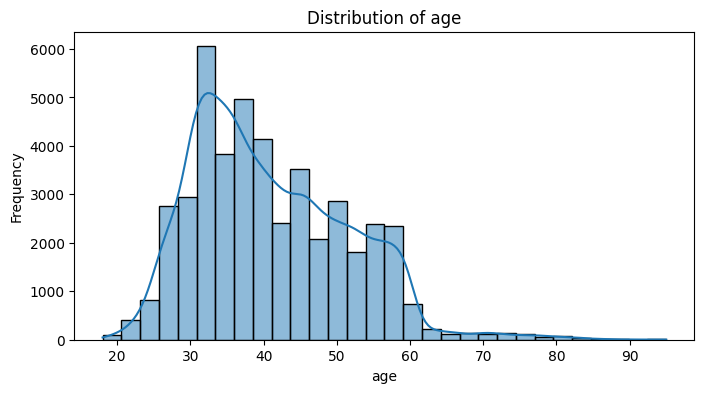

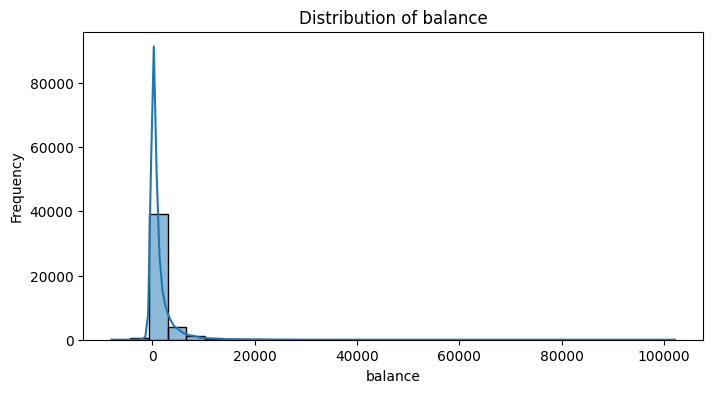

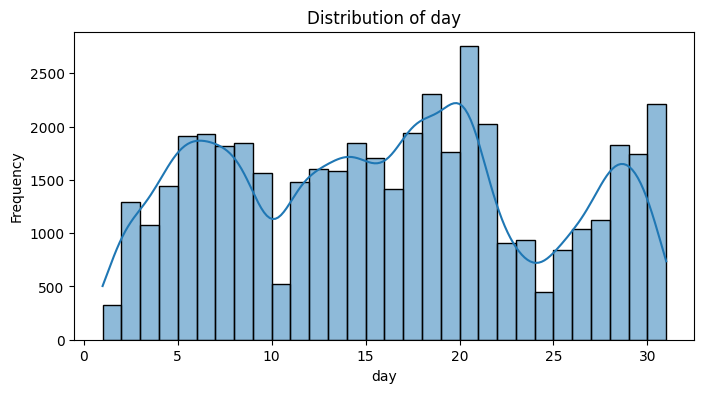

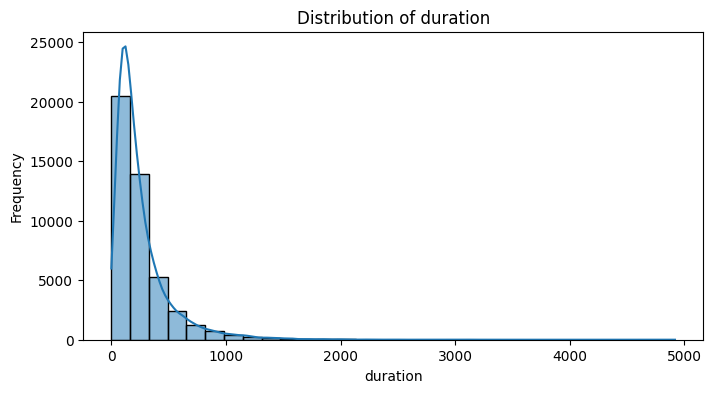

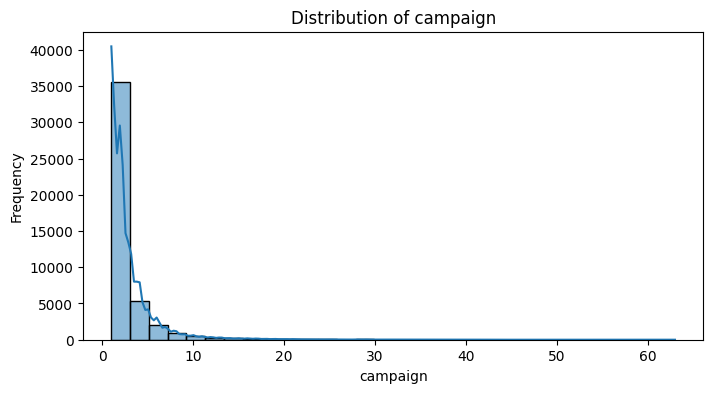

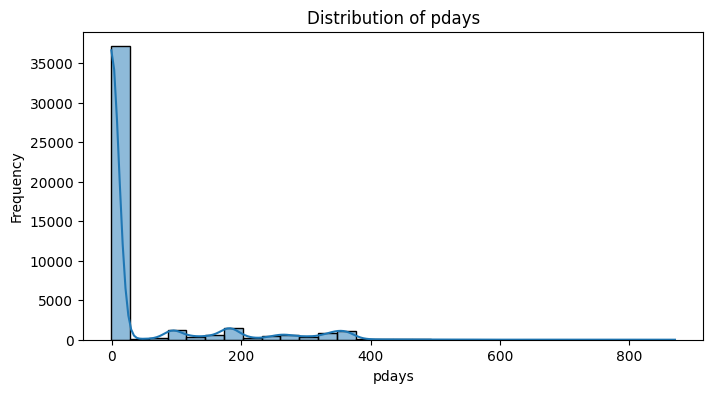

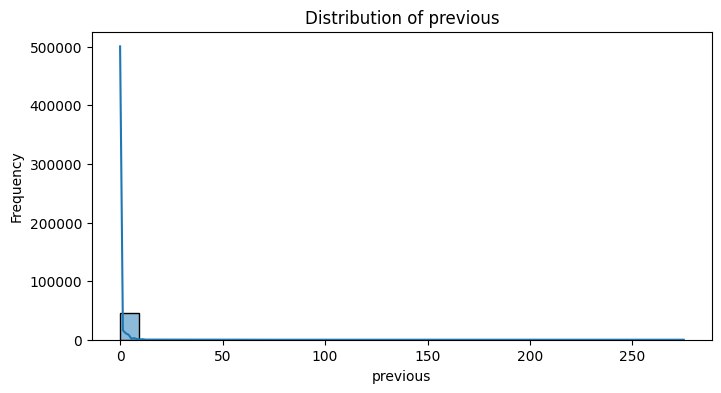

In [15]:
# Historgrams - numeric features

numeric_cols = ["age", "balance", "day", "duration", "campaign", "pdays", "previous"]
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(dataset[col].dropna(), bins=30, kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

#### Interpretation Notes: Numeric Histograms 

Numeric Histograms ('age', 'balance', 'campaign', and 'duration')

- **`age`**:  
  - Distribution is slightly right-skewed, centered in the 30s–40s.  
  - Small tails appear at younger ages (<25) and older ages (>60).  
  - Age can capture demographic trends in deposit subscriptions [1].

- **`balance`** (average yearly account balance):  
  - Heavily right-skewed, with most clients near zero and a long positive tail.  
  - Outliers with very high balances may need log-scaling for clarity.  
  - Often used as a proxy for financial stability [2].

- **`campaign`** (number of contacts in this campaign):  
  - Right-skewed — most clients contacted only a few times, but some many times.  
  - Higher values often indicate diminishing returns: repeated calls tend to reduce success probability [3].  
  - Useful for later feature engineering (e.g., grouping high vs. low contact counts).

- **`duration`** (last contact duration, in seconds):  
  - Strongly right-skewed, with a long tail.  
  - Longer calls are highly predictive of success — making this variable a classic case of **data leakage** [2][4].  
  - Good for exploratory analysis and understanding client behavior, but generally excluded from predictive models.

#### References

1. Moro, S., Cortez, P., & Rita, P. (2014). *A Data-Driven Approach to Predict the Success of Bank Telemarketing*. Decision Support Systems, 62, 22–31.  
   [https://doi.org/10.1016/j.dss.2014.03.001](https://doi.org/10.1016/j.dss.2014.03.001)

2. Alex Kataev – *UCI Bank Marketing Dataset: Part 1 – Exploratory Data Analysis*. Medium.  
   [https://alexkataev.medium.com/uci-bank-marketing-dataset-part-1-exploratory-data-analysis-eda-f3108f3982b4](https://alexkataev.medium.com/uci-bank-marketing-dataset-part-1-exploratory-data-analysis-eda-f3108f3982b4)

3. Utkarsh Satishkumar Shah – *Bank Marketing Predictive Analysis: A Deep Dive Using CRISP-DM*. Medium.  
   [https://medium.com/@utkarshsatishkumar.shah/bank-marketing-predictive-analysis-a-deep-dive-using-crisp-dm-3d29657b2310](https://medium.com/@utkarshsatishkumar.shah/bank-marketing-predictive-analysis-a-deep-dive-using-crisp-dm-3d29657b2310)

4. Arjan Avarjana – *Bank Marketing Dataset: MLP Classification*. Medium.  
   [https://avarjana.medium.com/bank-marketing-dataset-mlp-classification-28c2f33bd7f7](https://avarjana.medium.com/bank-marketing-dataset-mlp-classification-28c2f33bd7f7)
---

#### Interpretation Notes: `pdays` & `previous` 

`pdays` & `previous`

- **`pdays`**: number of days since the client was last contacted from a previous campaign.  
  - A sentinel value (commonly 999 or –1) means *no prior contact*. Roughly 96% of records fall into that category.  
  - Some studies note that early re-contact (within ~14 days) may be linked to higher subscription rates [2][4].  

- **`previous`**: number of prior contacts before this campaign.  
  - Majority (~86%) of clients had no prior contacts [2].  
  - Higher values don’t always predict better outcomes, but moderate prior exposure can correlate with slightly improved conversions [2][3].  

- **Together**: these variables both capture client “exposure history.”  
  - Researchers sometimes combine them into a single binary feature — e.g., *“ever contacted before”* — to simplify modeling and reduce overlap [3].  

#### References

1. Utkarsh Satishkumar Shah – *Bank Marketing Predictive Analysis: A Deep Dive Using CRISP-DM*. Medium.  
   [https://medium.com/@utkarshsatishkumar.shah/bank-marketing-predictive-analysis-a-deep-dive-using-crisp-dm-3d29657b2310](https://medium.com/@utkarshsatishkumar.shah/bank-marketing-predictive-analysis-a-deep-dive-using-crisp-dm-3d29657b2310)

2. Alex Kataev – *UCI Bank Marketing Dataset: Part 1 – Exploratory Data Analysis*. Medium.  
   [https://alexkataev.medium.com/uci-bank-marketing-dataset-part-1-exploratory-data-analysis-eda-f3108f3982b4](https://alexkataev.medium.com/uci-bank-marketing-dataset-part-1-exploratory-data-analysis-eda-f3108f3982b4)

3. *Exploring the UCI Bank Marketing Dataset*. RStudio Pubs (static HTML).  
   [https://rstudio-pubs-static.s3.amazonaws.com/1278972_0559089e51b842e093d0819f2538920e.html](https://rstudio-pubs-static.s3.amazonaws.com/1278972_0559089e51b842e093d0819f2538920e.html)

4. Arjan Avarjana – *Bank Marketing Dataset: MLP Classification*. Medium.  
   [https://avarjana.medium.com/bank-marketing-dataset-mlp-classification-28c2f33bd7f7](https://avarjana.medium.com/bank-marketing-dataset-mlp-classification-28c2f33bd7f7)
---

#### Boxplots: Numeric Features by Target (`y`)

These plots show how each numeric feature differs between clients who subscribed (`yes`) and those who didn’t (`no`); look for shifts in medians, spread, and overlap.


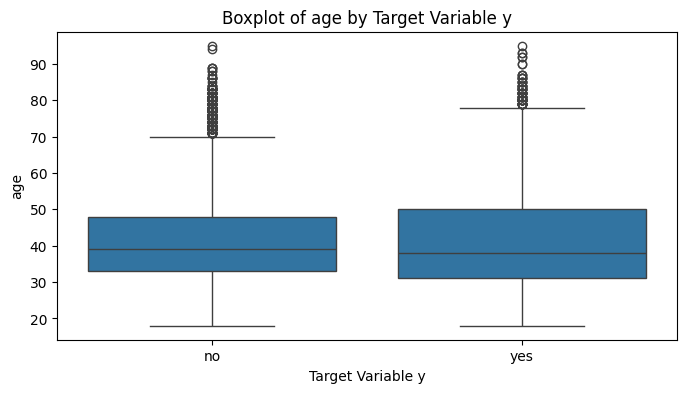

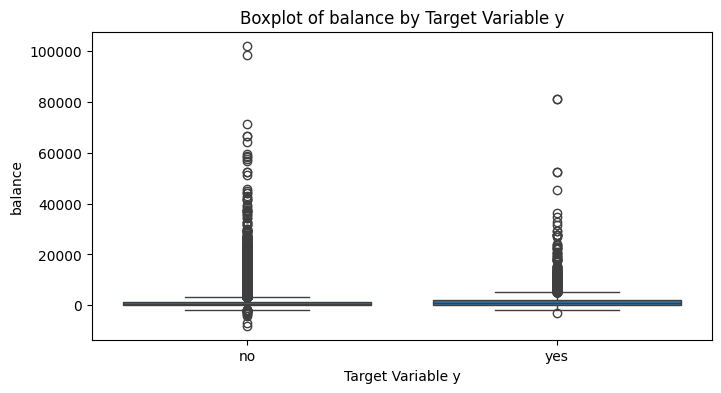

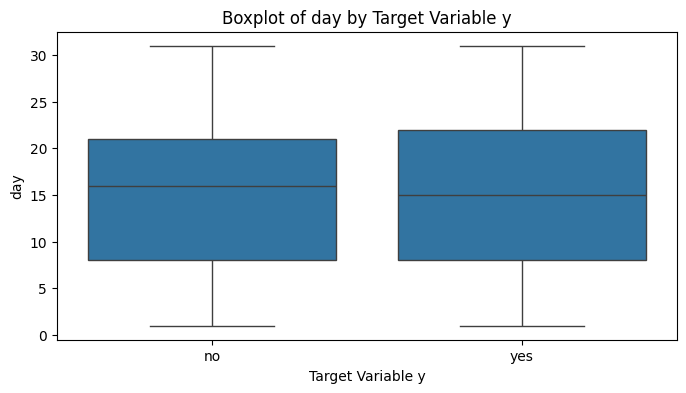

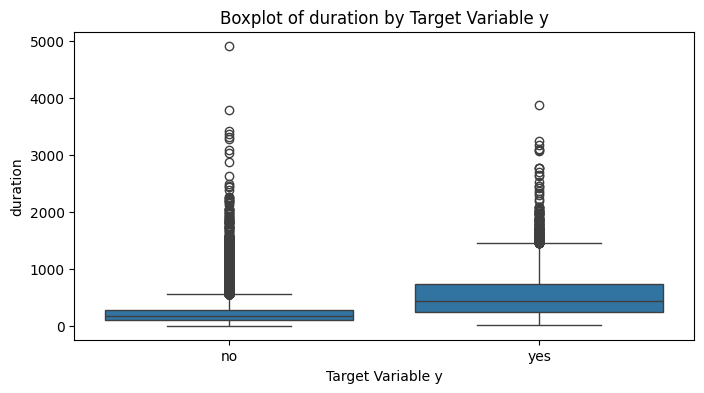

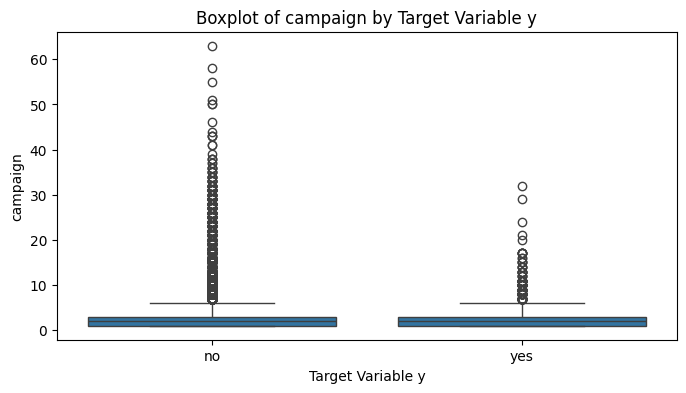

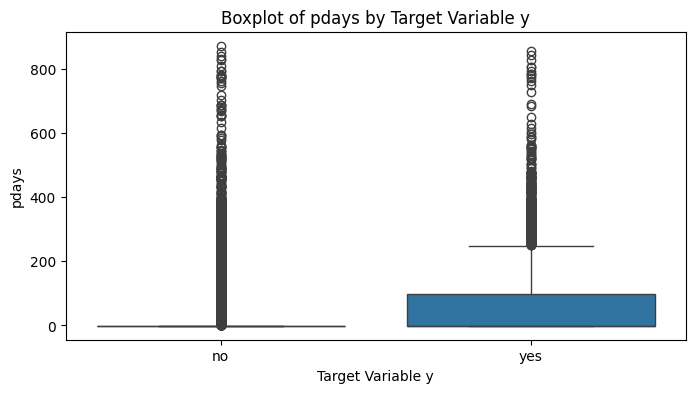

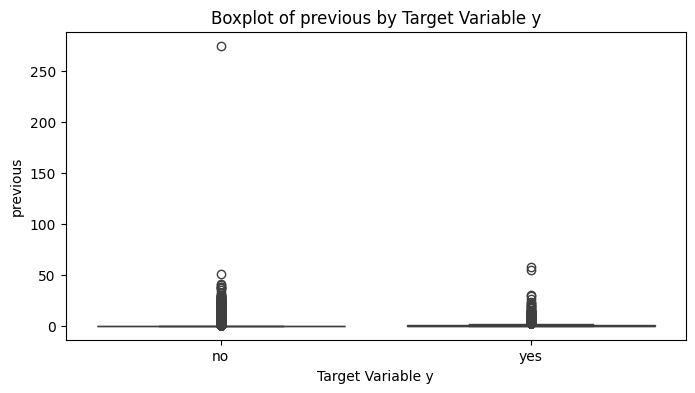

In [16]:
# Boxplots - numeric split by target y

numeric_cols = ["age", "balance", "day", "duration", "campaign", "pdays", "previous"]
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='y', y=col, data=dataset)
    plt.title(f"Boxplot of {col} by Target Variable y")
    plt.xlabel("Target Variable y")
    plt.ylabel(col)
    plt.show()

#### Interpretation: Boxplots by `y`  

These boxplots compare each numeric feature across `y = no` vs `y = yes`.  
I’m looking for three things: **(1) shift in medians**, **(2) spread/outliers**, and **(3) overlap** (how separable the classes look).

- **How to read**  
  - If the **median** for `yes` > `no` (or vice-versa), that hints at directional association.  
  - **Narrower boxes** (IQR) suggest more consistent values within that class.  
  - **Heavy overlap** means weak separation; **clear gaps** suggest stronger signal.

##### `age`
- **What I see:** Medians similar `yes`, higher `no`   
- **Spread/overlap:** ☐ Large overlap ☐ Moderate overlap ☐ Limited overlap  
- **Takeaway:** Age shows ☐ weak ☐ modest ☐ clear class separation. Keep for modeling; likely interacts with contact features.

##### `balance`
- **What I see:** Right-tail outliers in both classes; median for `yes` ☐ slightly higher ☐ similar  
- **Spread/overlap:** ☐ High overlap (skew dominates) ☐ Some separation at upper tail  
- **Takeaway:** Skew and outliers dilute median shifts. Consider log-view later; still worth keeping.

##### `campaign` (contacts in this campaign)
- **What I see:** `yes` tends to occur at **lower** contact counts; `no` shows higher IQR/right tail.  
- **Spread/overlap:** Overlap present but **diminishing returns** pattern is visible.  
- **Takeaway:** Useful negative association (more calls → lower success). Good modeling feature.

##### `duration` (last call duration, seconds)
- **What I see:** `yes` median clearly higher; long right tail.  
- **Spread/overlap:** Separation is strong; long calls align with `yes`.  
- **Takeaway:** **Leaky variable** for modeling (reflects outcome). Keep for EDA insight only; plan to exclude from model.

##### `pdays`
- **Note:** Sentinel value (e.g., `999`) = “no prior contact.” Boxplot may bunch values; a filtered view (excluding sentinel) is informative.  
- **What I see (non-sentinel):** ☐ `yes` shows smaller values (recent contact) ☐ little difference  
- **Takeaway:** If recent contact (lower `pdays`) aligns with `yes`, this supports recency effects.

##### `previous`
- **What I see:** Most observations at 0; occasional higher counts in `no`.  
- **Spread/overlap:** Heavy overlap; signal may be non-linear.  
- **Takeaway:** Keep for now; may work better as buckets (0 / 1–2 / 3+) or combined with `pdays` into “ever contacted” later.

**Next steps**
- Consider log-scale spot-checks for skewed features (`balance`, `campaign`, `duration`).  
- For `pdays`, add a second plot excluding sentinel to see the true distribution.

---


In [17]:
# Summary statistics by class

num_cols = dataset.select_dtypes(include=["number"]).columns
agg_map = {col: ["median", "mean", iqr] for col in num_cols}
summary = dataset.groupby("y").agg(agg_map).round(2)
summary.columns = [f"{col}_{stat}" for col, stat in summary.columns]

def stat_table(summary, stat: str):
    cols = [c for c in summary.columns if c.endswith(f"_{stat}")]
    out = summary[cols].copy()
    out.columns = [c.rsplit("_", 1)[0] for c in out.columns]   # drop _median suffix etc.
    return out

median_tbl = stat_table(summary, "median").reindex(["no","yes"])
mean_tbl   = stat_table(summary, "mean").reindex(["no","yes"])
iqr_tbl    = stat_table(summary, "iqr").reindex(["no","yes"])

print("Medians by class:")
display(median_tbl)

print("Means by class:")
display(mean_tbl)

print("IQR by class:")
display(iqr_tbl)

Medians by class:


,age,balance,day,duration,campaign,pdays,previous
y,,,,,,,
no,39.0,417.0,16.0,164.0,2.0,-1.0,0.0
yes,38.0,733.0,15.0,426.0,2.0,-1.0,0.0


Means by class:


,age,balance,day,duration,campaign,pdays,previous
y,,,,,,,
no,40.84,1303.71,15.89,221.18,2.85,36.42,0.50
yes,41.67,1804.27,15.16,537.29,2.14,68.70,1.17


IQR by class:


,age,balance,day,duration,campaign,pdays,previous
y,,,,,,,
no,15.0,1287.0,13.0,184.0,2.0,0.0,0.0
yes,19.0,1949.0,14.0,481.0,2.0,99.0,1.0


#### Summary of Numeric Features by Target (`y`) 

**Age**
- Median: no = 39, yes = 38 → very similar.
- Mean: slightly higher for yes (41.7 vs 40.8).
- IQR: wider for yes (19 vs 15) → age range among subscribers is a bit more spread out.

**Balance**
- Median: higher for yes (733 vs 417).
- Mean: higher for yes (1804 vs 1304), but large IQRs (1949 vs 1287) show heavy skew.
- Takeaway: Balance may add some signal, but extreme outliers could dominate.

**Day of month**
- Medians almost identical (16 vs 15).
- Means and IQRs close → likely little predictive value.

**Duration (last call length)**
- Median: yes much higher (426 vs 164).
- Mean: yes more than double (537 vs 221).
- IQR: yes more than double (481 vs 184).
- Clear separation → but a **leakage variable** (reflects campaign outcome). Good for EDA, exclude from modeling.

**Campaign (contacts in this campaign)**
- Median: equal (2).
- Mean: higher for no (2.85 vs 2.14).
- Takeaway: More calls are associated with lower success (diminishing returns effect).

**Pdays (days since last contact)**
- Median = -1 for both → sentinel value dominates.
- Mean: higher for yes (68.7 vs 36.4), IQR for yes = 99 → only a small subset has meaningful values.
- Takeaway: Needs filtering (exclude sentinel) or transformation (e.g., binary “previously contacted”).

**Previous (prior contacts before this campaign)**
- Median = 0 for both.
- Mean: higher for yes (1.17 vs 0.50), IQR for yes = 1 → most clients weren’t contacted before, but a few prior contacts may boost odds.
---


#### Countplots: Categorical Features by Target (`y`)  
These plots show how each categorical feature breaks down by subscribed (`yes`) vs. not subscribed (`no`).  
Look for categories where the share of `yes` is relatively higher, even though `no` dominates overall.


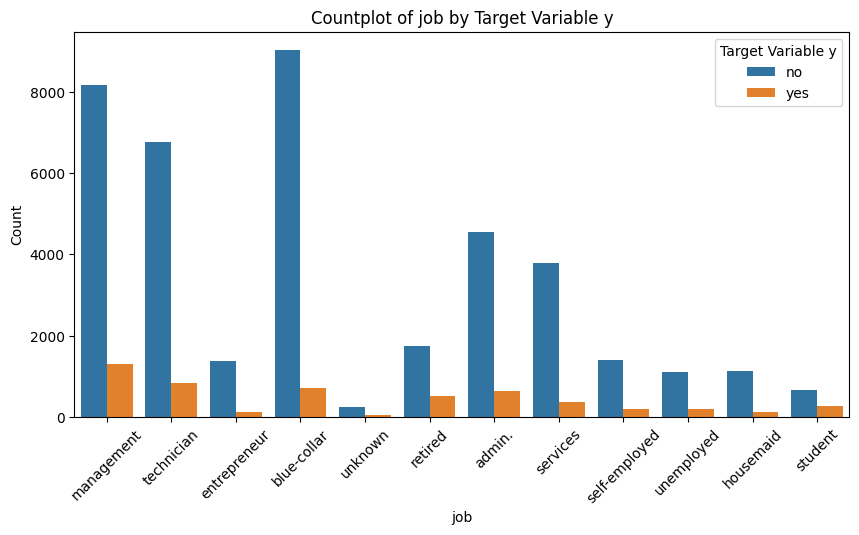

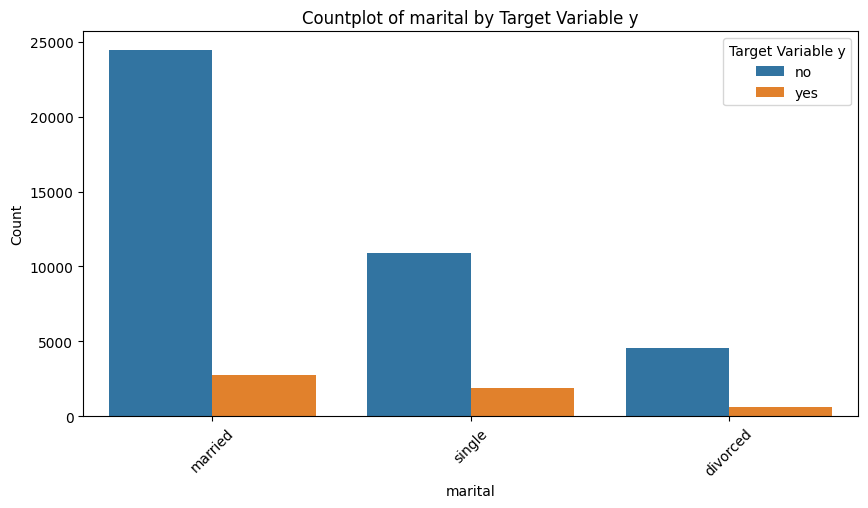

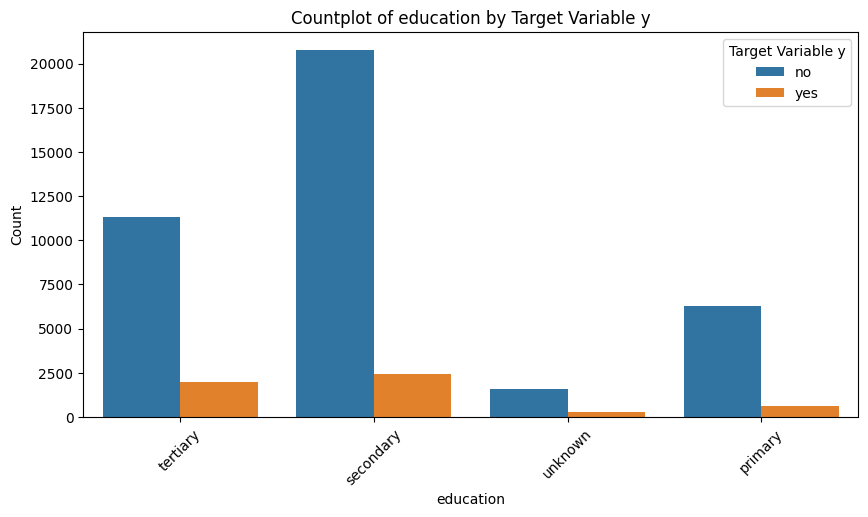

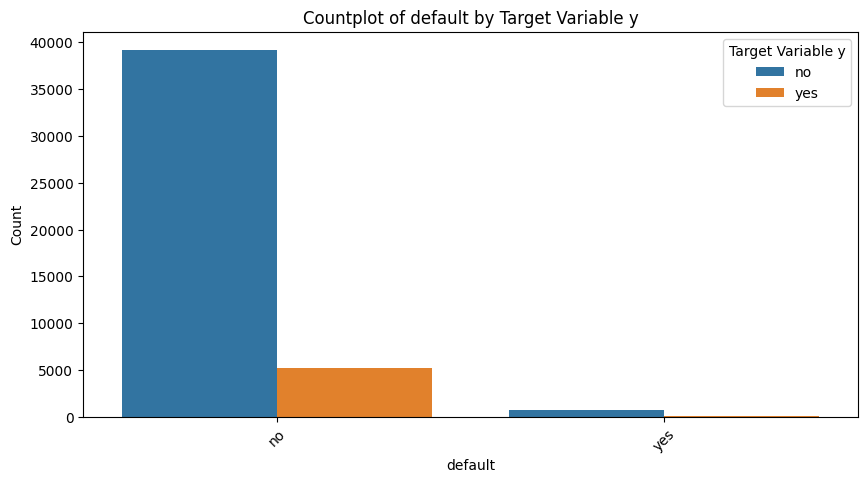

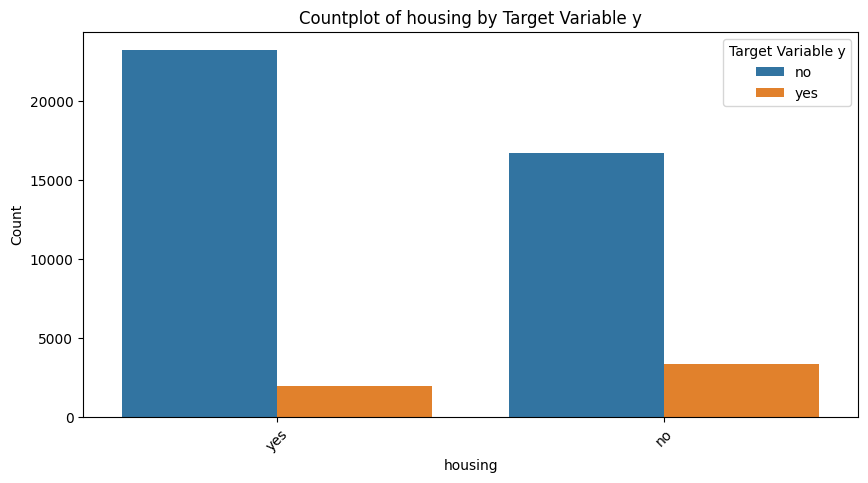

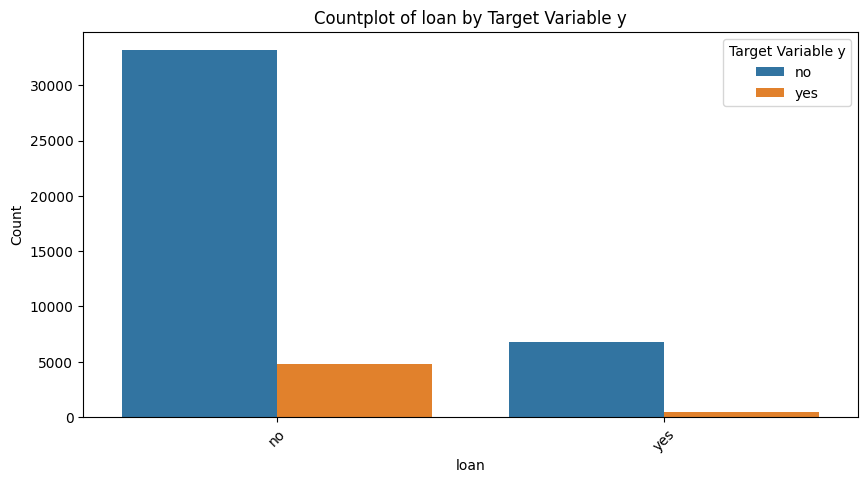

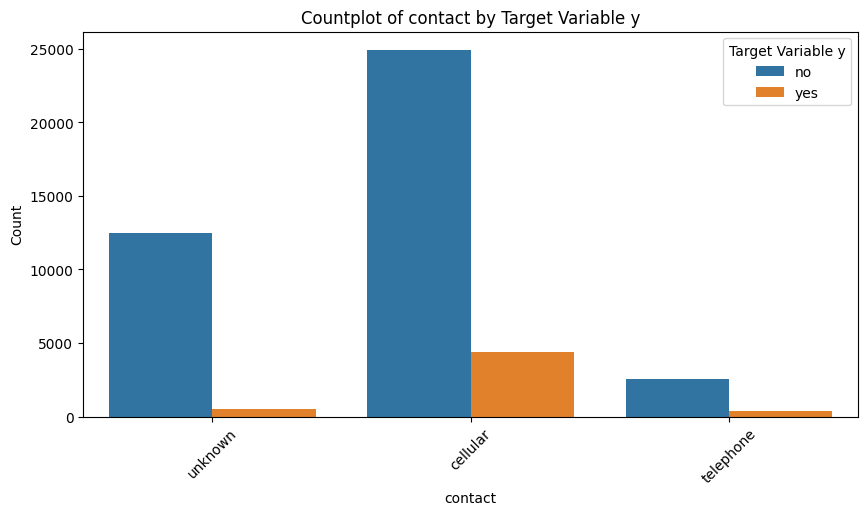

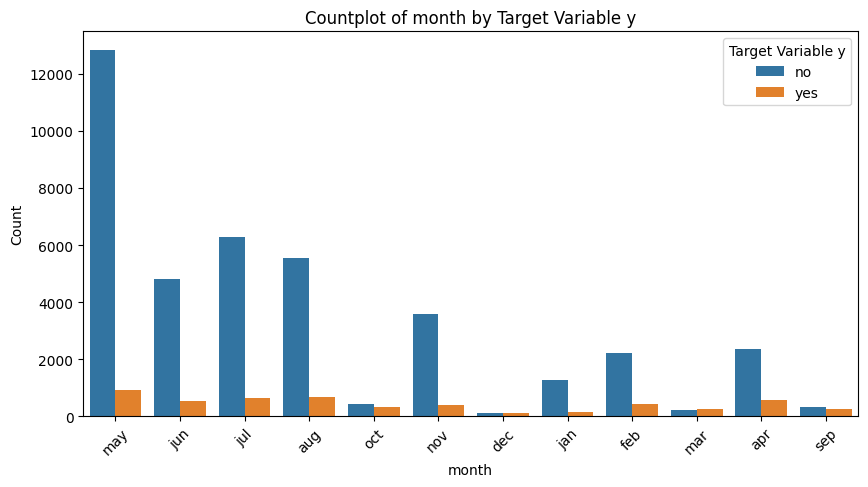

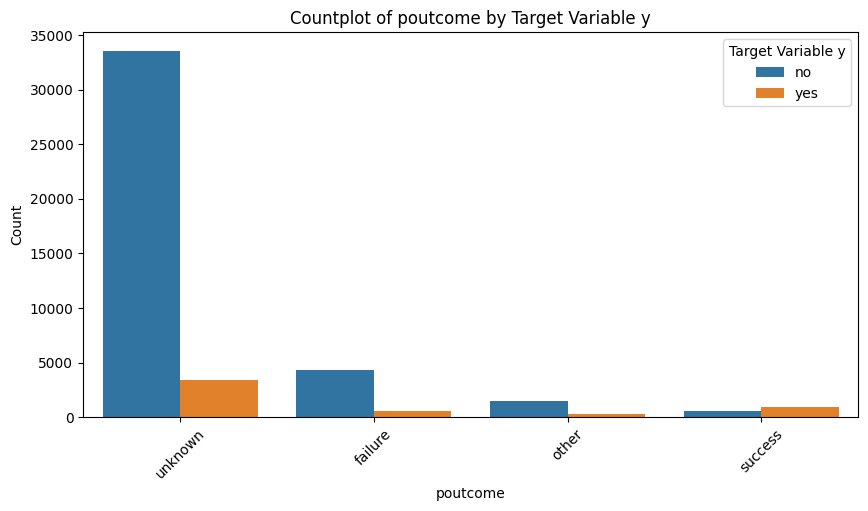

In [18]:
# Countplots - how each categorical feature differs by target y

categorical_cols = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "poutcome"]
for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, hue='y', data=dataset)
    plt.title(f"Countplot of {col} by Target Variable y")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.legend(title='Target Variable y')
    plt.show()  

#### Quick takeaways  
- **Job**: Retired clients show a higher proportion of `yes`; management, technician, and blue-collar dominate in volume but skew to `no`.  
- **Marital**: Singles convert slightly better than married or divorced.  
- **Education**: Tertiary education shows a modestly higher share of `yes`.  
- **Default**: Mostly “no”; little difference between “no” and “unknown.”  
- **Housing**: Clients without housing loans lean slightly more toward `yes`.  
- **Loan**: Majority “no”; conversion rates similar across categories.  
- **Contact**: Cellular contacts outperform telephone.  
- **Month**: May dominates volume but has lower success; October/December show better `yes` ratios, though smaller samples.  
- **Poutcome**: “Unknown” is most frequent; prior “success” strongly correlates with new `yes`.

**Interpretation**  
- Categorical features mirror the overall imbalance, but specific groups (retired, tertiary-educated, single, cellular contact, prior success) show stronger signals worth testing in modeling.
---

#### Note on data preparation  

At this stage, the dataset is being explored **as-is**.  
- Categorical features (e.g., `job`, `education`, `marital`, `default`) still contain `"unknown"` values.  
- `"unknown"` is being treated as a valid category during EDA so its frequency and impact can be observed directly in plots.  
- No one-hot/dummy encoding has been applied yet — that step will come later during model preparation.  

This approach allows for full visibility into how `"unknown"` behaves before deciding whether it should remain as a separate category or be handled differently during modeling.

#### Handling of "unknown" values 

Several features in this dataset include "unknown" as a category (e.g., `job`, `education`, `marital`, `default`).  
Instead of dropping rows or trying to impute values, I will **retain "unknown" as its own category**.  

Reasons for this choice:
- Preserves the full dataset size without removing clients.
- Avoids assumptions about why information is missing.
- Lets modeling later determine whether "unknown" itself carries predictive value.  

If "unknown" proves unhelpful (or noisy), I can revisit and collapse it into the majority category or drop those rows.  
For now, keeping it explicit provides the cleanest path forward.


#### Example: One-hot Encoding with "unknown"

- When categorical features are prepared for modeling, one-hot (dummy) encoding expands each category into its own column.  
For example, if the `education` column contains:  

| education   |
|-------------|
| primary     |
| secondary   |
| tertiary    |
| unknown     |

- After one-hot encoding, it becomes:  

| education_primary | education_secondary | education_tertiary | education_unknown |
|-------------------|---------------------|--------------------|-------------------|
| 1                 | 0                   | 0                  | 0                 |
| 0                 | 1                   | 0                  | 0                 |
| 0                 | 0                   | 1                  | 0                 |
| 0                 | 0                   | 0                  | 1                 |

- This way, `"unknown"` is treated as a valid category. The model can then learn whether the `"unknown"` indicator is predictive.  
If it turns out to be unhelpful, the dummy column `education_unknown` can later be dropped without changing the rest of the pipeline.
---

#### Stacked (side-by-side) counts - categorical x y

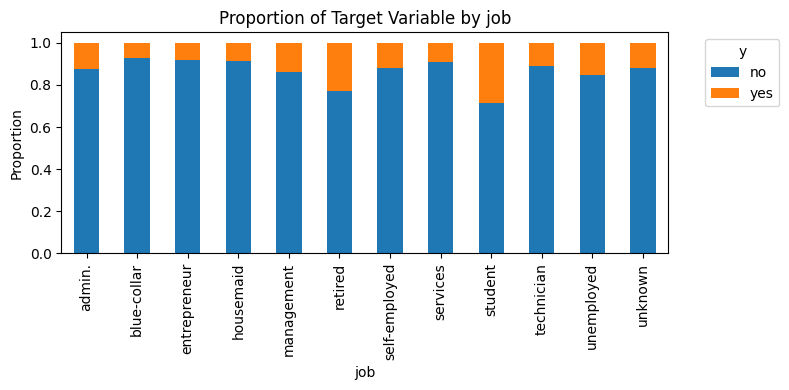

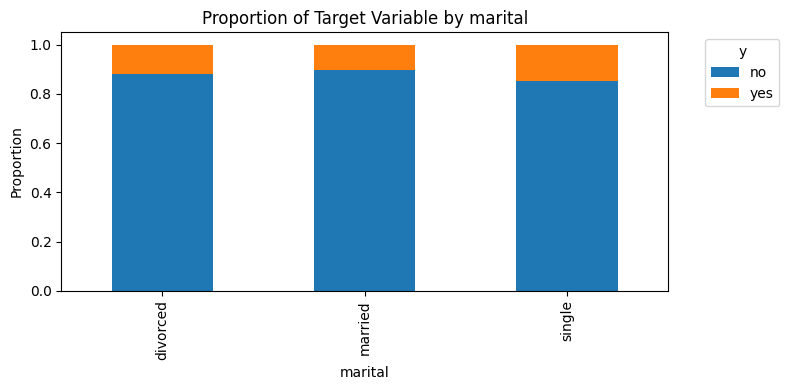

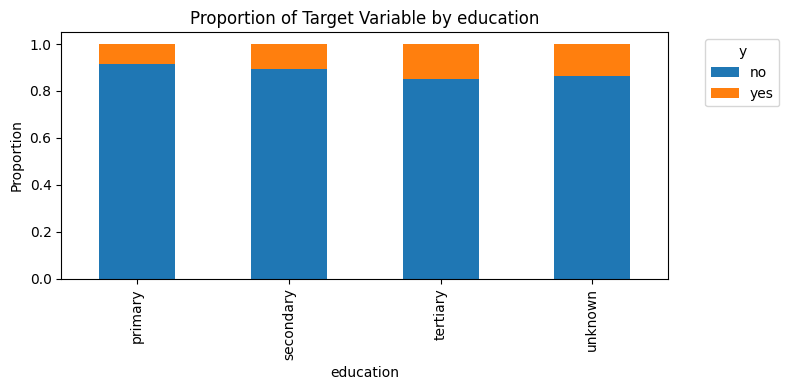

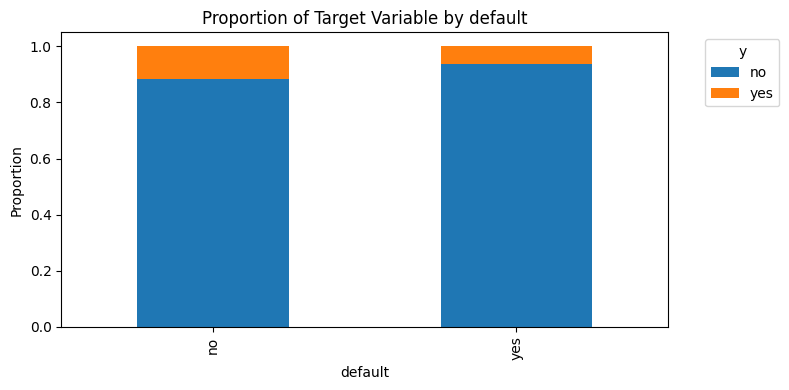

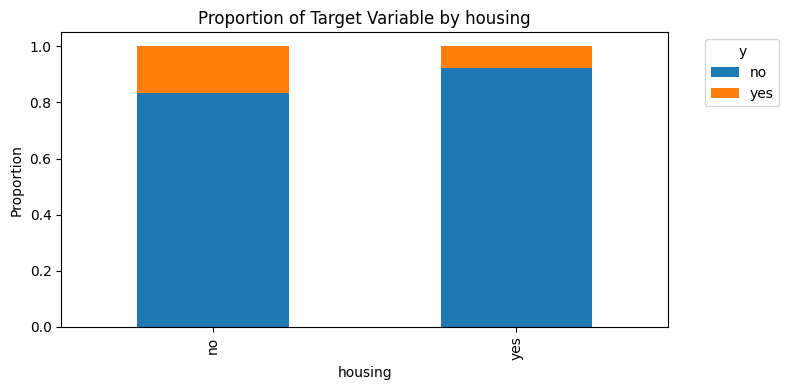

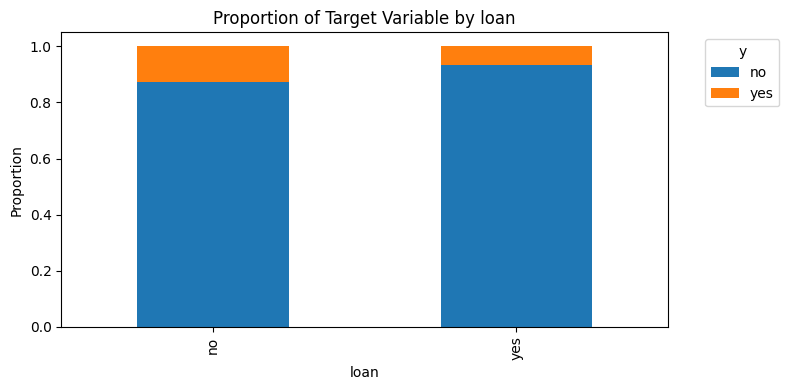

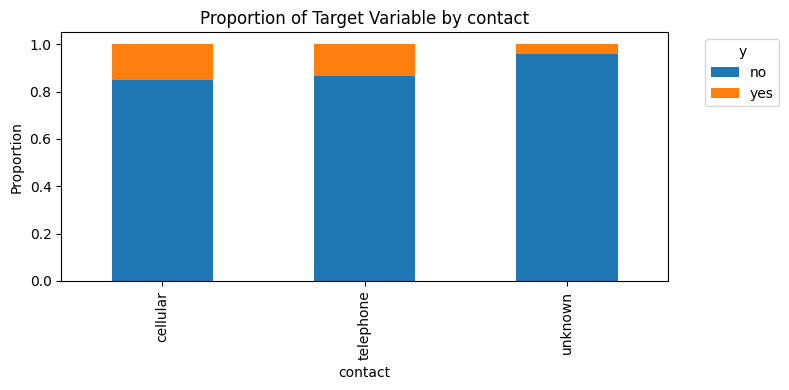

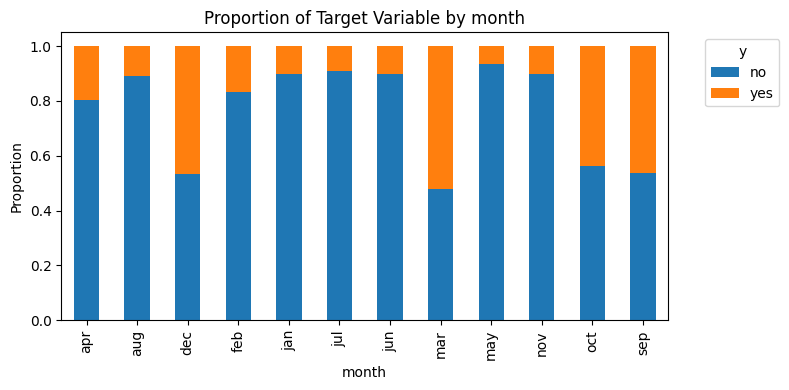

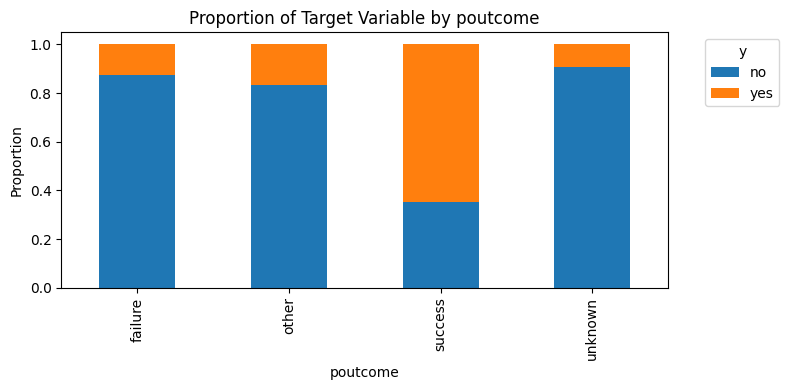

In [19]:
# Stacked side-by-side counts - categorical features by target

for col in categorical_cols:
	ct = (
		dataset.groupby([col, "y"]).size()
		.unstack(fill_value=0)
		.apply(lambda x: x / x.sum(), axis=1)  # normalize by row (category)
	)
	ct.plot(kind="bar", stacked=True, figsize=(8, 4))
	plt.title(f"Proportion of Target Variable by {col}")
	plt.xlabel(col)
	plt.ylabel("Proportion")
	plt.legend(title="y", bbox_to_anchor=(1.05, 1), loc='upper left')
	plt.tight_layout()
	plt.show()


### Overall Insights: Target Variable by Categorical Features  

- Across all categorical features, the target variable is **heavily imbalanced toward `no`**, confirming the need to handle imbalance in modeling.  
- Some features provide **stronger predictive signals** than others:  
  - **Poutcome** is the clearest, with “success” strongly linked to `yes`.  
  - **Month** reveals seasonality, with higher `yes` rates in March, September, and December.  
  - **Contact type** also matters: cellular contact is more successful than telephone or unknown.  
- Financial indicators (**housing, loan, default**) consistently show that clients without debt obligations are more likely to subscribe.  
- Demographics like **education** and **marital status** offer weaker signals but still show subtle differences in subscription likelihood.  
- Taken together, these categorical features highlight both **structural imbalance** and **specific drivers** that can guide feature engineering and model focus.  
---

### Detailed Results of Target Variable by Categorical Features

#### Results: Target Variable by Job  

- Across all job categories, **“no” dominates**, which confirms the class imbalance.  
- Some jobs (e.g., **retired, student**) show a noticeably **higher proportion of “yes” responses** compared to others like **blue-collar or services**.  
- The **imbalance is consistent** across categories: most bars are heavily weighted toward `no`, but the `yes` portion varies slightly.  
- This suggests job type may provide some predictive signal, but the overall skew means imbalance handling (e.g., SMOTE or class weights) will be necessary.  


#### Results: Target Variable by Marital  

- The majority is **`no`** across all groups, confirming imbalance.  
- **Single** clients show a slightly higher share of `yes` compared to married or divorced.  
- The difference is not dramatic, but suggests marital status could carry some predictive signal.  


#### Results: Target Variable by Education  

- **Tertiary** education level shows a modestly higher proportion of `yes`.  
- **Primary** education has the lowest share of `yes`.  
- Secondary and unknown fall in between, but all remain skewed toward `no`.  
- Education may provide weak but useful signal.  


#### Results: Target Variable by Default  

- Clients with a **default = yes** are much less likely to subscribe (very low `yes` rate).  
- The **no-default** group has a higher — though still minority — proportion of `yes`.  
- Default history appears to be negatively correlated with subscription.  


#### Results: Target Variable by Housing  

- Clients **without housing loans** show a higher share of `yes` compared to those with loans.  
- Still, the imbalance toward `no` is dominant in both groups.  
- Housing status offers some predictive value.  


#### Results: Target Variable by Loan  

- Similar to housing: clients **without personal loans** are more likely to subscribe.  
- Those with loans are less inclined, with a very low `yes` proportion.  
- Loan information reinforces financial context in predictions.  


#### Results: Target Variable by Contact  

- **Cellular contact** shows a higher rate of `yes` compared to telephone or unknown.  
- Telephone and unknown contacts are heavily skewed toward `no`.  
- Contact method is an important driver of success rate.  


#### Results: Target Variable by Month  

- Strong **seasonality effect**:  
  - **March, September, December** have higher `yes` rates.  
  - **May and August** are especially skewed toward `no`.  
- Subscription success is highly time-sensitive and may depend on seasonal marketing dynamics.  


#### Results: Target Variable by Poutcome  

- The clearest signal among categorical features:  
  - **Success** in a previous campaign strongly correlates with a `yes` outcome.  
  - **Failure, other, or unknown** are mostly `no`.  
- Poutcome is one of the most predictive categorical features. 
---

#### Target Class Imbalance (`y`)

Here, we check the distribution of the target variable (`yes` vs `no`).  
This helps confirm if imbalance-handling techniques (e.g., SMOTE, class weights) will be required.  


Class counts:
 y
no     39922
yes     5289 

Class proportions:
 y
no     0.883
yes    0.117 



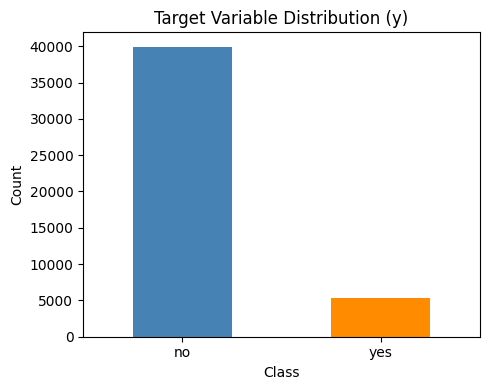

In [20]:
# Target variable class imbalance

# Count values
class_counts = dataset["y"].value_counts()
class_props = dataset["y"].value_counts(normalize=True)

# Print counts and proportions
print("Class counts:\n", class_counts.to_string(), "\n")
print("Class proportions:\n", class_props.round(3).to_string(), "\n")

# Plot
fig, ax = plt.subplots(figsize=(5,4))
class_counts.plot(kind="bar", color=["steelblue", "darkorange"], ax=ax)
ax.set_title("Target Variable Distribution (y)")
ax.set_xlabel("Class")
ax.set_ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()  



### Results: Target Class Imbalance  

- The dataset is **highly imbalanced**:  
  - **No:** 39,922 clients (88.3%)  
  - **Yes:** 5,289 clients (11.7%)  
- This skew means a naïve model could achieve ~88% accuracy by always predicting “no.”  
- Handling strategies: **SMOTE, undersampling, or class weights** will be essential to train a balanced model.  
---


### Safe vs. Leaky Features Checklist  

**Safe features (can be used in training):**  
- **Demographics**: `age`, `job`, `marital`, `education`  
- **Financial context**: `balance`, `housing`, `loan`, `default`  
- **Campaign metadata**: `contact`, `day`, `month`, `campaign`, `pdays`, `previous`, `poutcome`  
  - *Note:* `pdays = 999` usually indicates “no previous contact”  

**Leaky features (avoid using in training):**  
- **`duration`** – call length; only known *after* the call ends — introduces target leakage by providing post-outcome data.  
- Any feature observed *after* or influenced *by* the outcome — essentially giving the model “an answer key” it wouldn’t have in production.  

**Rule of thumb:**  
 - If we **wouldn’t know it at prediction time**, it’s leaky. 
 - Including it creates overly optimistic performance that fails in real-world use.  

**Takeaway:**  
- `duration` looks powerful in correlation, but it’s a textbook case of data leakage. 
- Flagging and excluding it keeps the model honest and ensures performance will generalize in real-world predictions.  

### References  

- IBM. *Data Leakage in Machine Learning*. IBM Think Topics.  
  [https://www.ibm.com/think/topics/data-leakage-machine-learning](https://www.ibm.com/think/topics/data-leakage-machine-learning)  

- Wikipedia. *Leakage (machine learning)*.  
  [https://en.wikipedia.org/wiki/Leakage_(machine_learning)](https://en.wikipedia.org/wiki/Leakage_(machine_learning))  

- ActiveViam (Atoti). *What is data leakage and how to mitigate it?*  
  [https://www.atoti.activeviam.com/articles/what-is-data-leakage-and-how-to-mitigate-it/](https://www.atoti.activeviam.com/articles/what-is-data-leakage-and-how-to-mitigate-it/)  

- Airbyte. *What is Data Leakage?*  
  [https://airbyte.com/data-engineering-resources/what-is-data-leakage](https://airbyte.com/data-engineering-resources/what-is-data-leakage)  

---

#### Correlation Heatmap (numeric features)
- We compute a Pearson correlation matrix on **numeric columns only** and include a numeric target `y_num` (`yes`=1, `no`=0) so its correlations appear in the matrix.
- Numeric features only (age, balance, day, duration, campaign, pdays, previous, etc.).
- Add a numeric version of the target (y_num: yes = 1, no = 0) so you can see how features correlate with the outcome.
- Categorical columns like job or marital won’t be included in the heatmap — they’ll be handled later with encodings.
- a numeric-only slice + y_num gives you a clean, interpretable heatmap.
- Note: **Note on Data Leakage:**  
    - The feature `duration` shows strong correlation with the target, but it is **leaky** — its value is only known *after* the marketing call is completed.  
    - Including it in training would give the model unrealistic foresight, inflating accuracy without improving real-world predictive power.  
    - `duration` should be excluded from the modeling feature set.  


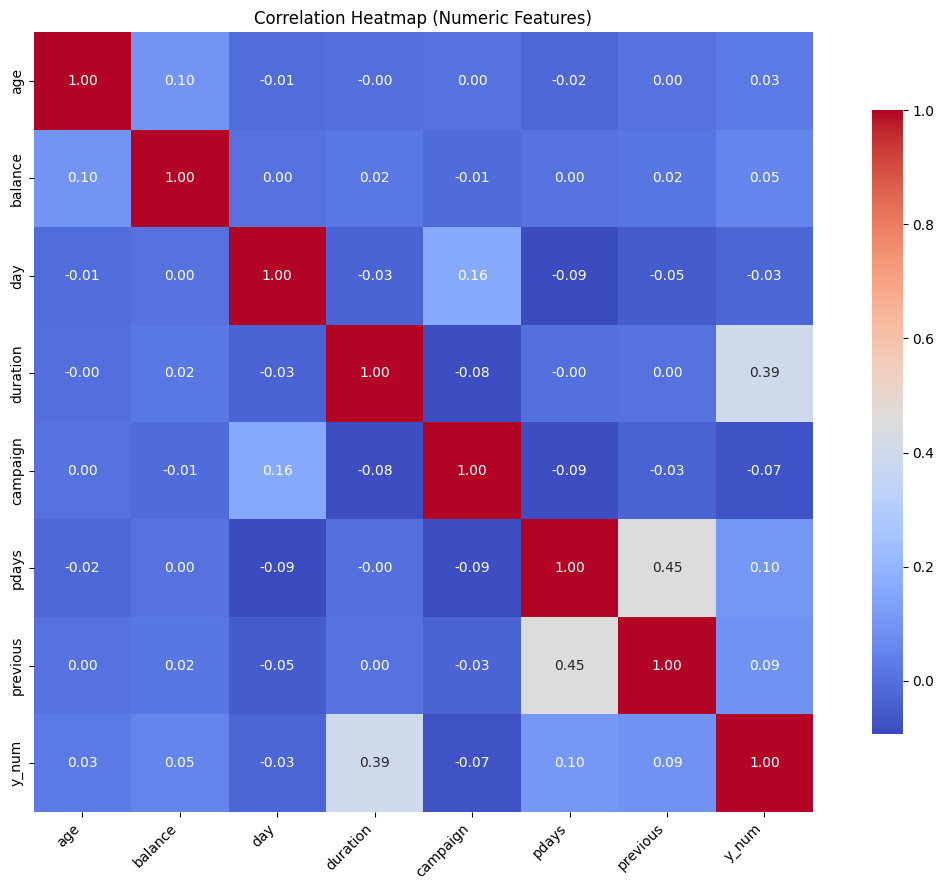

Correlation with target (y_num):

duration    0.395
pdays       0.104
previous    0.093
balance     0.053
age         0.025
day        -0.028
campaign   -0.073

Note: 'duration'is leaky; exclude from training features.


In [21]:
# Correlation Heatmap (numeric features) — self-contained & side-effect free

# Work on a copy to avoid mutating the main dataset
df_corr = dataset.copy()

# Add numeric target
if "y" in df_corr.columns:
    df_corr["y_num"] = (df_corr["y"] == "yes").astype(int)

# Numeric columns only (will include y_num)
numeric_cols = df_corr.select_dtypes(include=["number"]).columns.tolist()

# Compute Pearson correlations
corr = df_corr[numeric_cols].corr(numeric_only=True)

# Plot
plt.figure(figsize=(12, 9))
ax = sns.heatmap(
    corr,
    annot=True, fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={"shrink": 0.8}
)
ax.set_title("Correlation Heatmap (Numeric Features)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Optional: sorted correlations with the target
if "y_num" in corr.columns:
    print("Correlation with target (y_num):\n")
    print(corr["y_num"].drop("y_num").sort_values(ascending=False).round(3).to_string())

    # Gentle reminder about leakage
    if "duration" in corr.index:
        print("\nNote: 'duration'is leaky; exclude from training features.")


### Results: Correlation Heatmap (Numeric Features)

- **Overall:** Most numeric features show **low correlations** with each other and with the target (`y_num`), which suggests weak linear relationships.  
- **Duration:** Correlates most strongly with `y_num` (~0.39). This is expected, but it is a **leaky feature** (only known after the call ends) and must be excluded from modeling.  
- **Pdays & Previous:** Show a moderate positive correlation (~0.45). This reflects that clients contacted previously (`previous > 0`) often have a meaningful value in `pdays`.  
- **Other numeric features (age, balance, campaign, day):** All correlations with `y_num` are close to zero, indicating they have little direct linear relationship with the target individually.  
- **Implication for modeling:**  
  - Most numeric features alone aren’t strong predictors.  
  - Predictive power will likely come from **nonlinear patterns, interactions, and categorical variables**, not simple linear correlation.  
  - Feature engineering (e.g., recoding `pdays`, creating campaign frequency) may help strengthen signals.  
---


#### Feature Engineering (initial examples)

Generate a few new features to capture additional signal(s):  
- **Campaign frequency per client:** How many times the client has been contacted in the current campaign.  
- **Time since last contact:** Derived from `pdays` (999 = no prior contact). We create a binary flag (`was_contacted_before`) and a cleaned version of `pdays` where 999 is set to `NaN`.  


In [22]:
# Feature engineering on 'campaign frequency per client' and 'time since last contact'
import pandas as pd
import numpy as np

dataset_fe = dataset.copy()

# Campaign frequency (log-transformed to reduce skew if desired)
dataset_fe["campaign_freq"] = dataset_fe["campaign"]
dataset_fe["campaign_freq_log"] = np.log1p(dataset_fe["campaign"])  # log(1+x)

# Time since last contact
dataset_fe["was_contacted_before"] = np.where(dataset_fe["pdays"] > 0, 1, 0)
dataset_fe["days_since_contact"] = dataset_fe["pdays"].replace({-1: np.nan})

# Quick check
print(dataset_fe[["campaign", "campaign_freq", "campaign_freq_log", 
          "pdays", "was_contacted_before", "days_since_contact"]].head())


   campaign  campaign_freq  campaign_freq_log  pdays  was_contacted_before  \
0         1              1           0.693147     -1                     0   
1         1              1           0.693147     -1                     0   
2         1              1           0.693147     -1                     0   
3         1              1           0.693147     -1                     0   
4         1              1           0.693147     -1                     0   

   days_since_contact  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN  


### Results: Feature Engineering  

- **Campaign frequency:**  
  - Added `campaign_freq` as a direct copy of `campaign`.  
  - Added `campaign_freq_log` to reduce skew using a log(1+x) transform.  
  - These features may help the model capture diminishing returns when clients are contacted repeatedly.  

- **Time since last contact (pdays):**  
  - In this dataset version, **`pdays = -1` encodes “no previous contact”** (instead of 999, used in other UCI variants).  
  - Created `days_since_contact` where `-1` is recoded as `NaN` for clarity.  
  - Added `was_contacted_before` as a binary indicator (1 = client was previously contacted, 0 = no prior contact).  
  - This makes the “no prior contact” case explicit and separates it from true numeric day values.  

**Implication:**  
- These engineered features enrich the dataset by clarifying prior-contact history and capturing nonlinear effects of repeated campaign contacts, both of which are likely to influence subscription outcomes.  
---


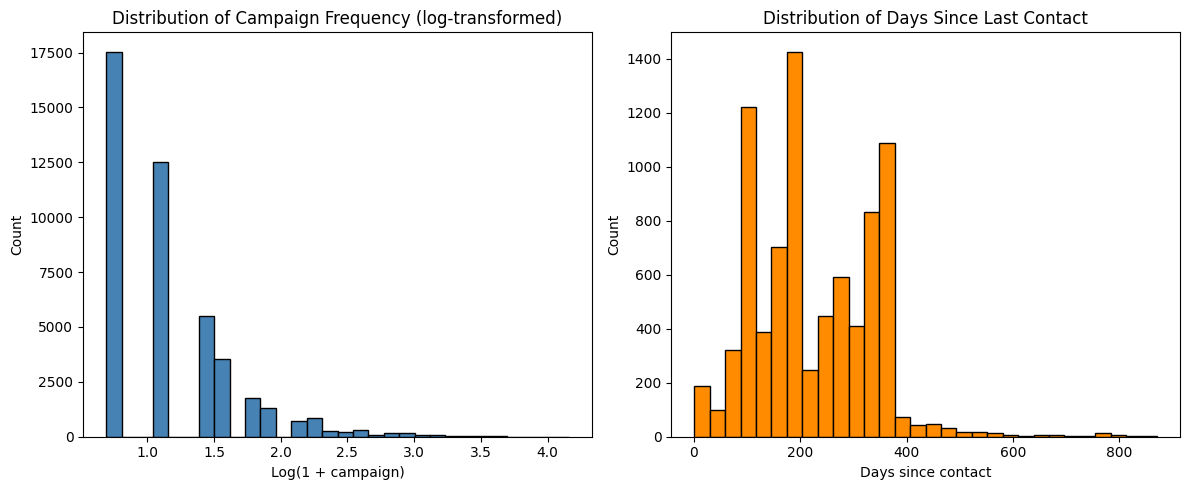

In [23]:
# Quick visualization of engineered features
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogram of campaign frequency (log-transformed)
axes[0].hist(dataset_fe["campaign_freq_log"].dropna(), bins=30, color="steelblue", edgecolor="black")
axes[0].set_title("Distribution of Campaign Frequency (log-transformed)")
axes[0].set_xlabel("Log(1 + campaign)")
axes[0].set_ylabel("Count")

# Histogram of days since last contact
axes[1].hist(dataset_fe["days_since_contact"].dropna(), bins=30, color="darkorange", edgecolor="black")
axes[1].set_title("Distribution of Days Since Last Contact")
axes[1].set_xlabel("Days since contact")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


### Results: Engineered Feature Distributions  

- **Campaign frequency (log-transformed):**  
  - The raw `campaign` variable was right-skewed (most clients contacted only 1–2 times, a few contacted many times).  
  - After applying log(1+x), the distribution is **more compressed and interpretable**, reducing the influence of extreme values.  

- **Days since last contact:**  
  - Most clients either have no previous contact (`NaN` after recoding `-1`) or were contacted within a smaller day range.  
  - A smaller subset shows very long gaps between contacts.  
  - This feature separates “no prior contact” from genuine day counts, making the information clearer for modeling.  
---


#### SMOTE (Synthetic Minority Over-sampling Technique)
- Plain version: instead of just duplicating the few yes rows you have, SMOTE creates new, synthetic examples of the minority class. 
- It does this by:
    - Picking a real yes sample.
    - Finding its nearest neighbors in feature space (other yes samples).
    - Generating a new synthetic point somewhere “in between” them.
    - That way, the dataset grows the minority class with more variety, not just repeats — which helps the model learn better boundaries.

- Two caveats:
    - We only apply SMOTE on the training set (never the test set) so we don’t leak artificial data.
    - It works best with continuous variables; for categorical features you need variants like SMOTE-NC.
---

#### Prepping for SMOTE

### ⚠️ Note on SMOTE Usage
SMOTE (Synthetic Minority Oversampling Technique) will be applied **only to the training set** after splitting the dataset.  
It should not be used on the validation or test sets, since that would cause data leakage.  
This cell is prepared for later steps (Week 3: Model Development & Tuning).


In [24]:
# Verify imbalanced-learn installation

print("Python executable:", sys.executable)
!{sys.executable} -m pip --version

# if not installed, uncomment the line below
# !{sys.executable} -m pip install imbalanced-learn

Python executable: d:\Program Files\Python310\python.exe


'd:\Program' is not recognized as an internal or external command,
operable program or batch file.


In [25]:
# Verify installation
print(sys.executable)

d:\Program Files\Python310\python.exe


In [26]:
# Verify SMOTE import 

print("SMOTE import works!")

SMOTE import works!


In [27]:
# Placeholder: imbalance handling options

# Example: compute class weights
classes = np.unique(dataset_fe["y"])
weights = compute_class_weight(class_weight="balanced", classes=classes, y=dataset_fe["y"])
class_weight_dict = dict(zip(classes, weights))

print("Computed class weights:", class_weight_dict)

# Example: SMOTE setup (to be applied only on training data later)
smote = SMOTE(random_state=42)

print("\nSMOTE instance created (not yet applied).")


Computed class weights: {'no': np.float64(0.566241671258955), 'yes': np.float64(4.274059368500661)}

SMOTE instance created (not yet applied).


#### Data Preprocessing & Model Development


In [28]:
# Categorical feature encoding

# Select categorical columns
cat_cols = dataset.select_dtypes(include=["object"]).columns.tolist()
print("Categorical features:", cat_cols)

# Preview unique values for a few columns
for col in cat_cols[:5]:
    print(f"\n{col}:", dataset[col].unique()[:10])


Categorical features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']

job: ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown' 'retired' 'admin.' 'services' 'self-employed' 'unemployed']

marital: ['married' 'single' 'divorced']

education: ['tertiary' 'secondary' 'unknown' 'primary']

default: ['no' 'yes']

housing: ['yes' 'no']


In [29]:
# Test run: encoding + scaling on a subset

# Subset (first 100 rows just for testing)
subset = dataset.head(100)

# Separate features/target
X = subset.drop("y", axis=1)
y = subset["y"]

# Column groups
cat_cols = ["job", "marital", "education", "default", "housing", "loan",
            "contact", "month", "poutcome"]
num_cols = ["age", "balance", "day", "duration", "campaign", "pdays", "previous"]

# Preprocessor: one-hot for categorical, standard scaling for numeric
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
    ]
)

# Build pipeline (preprocessing only, no model yet)
pipe = Pipeline(steps=[("preprocessor", preprocessor)])

# Fit and transform the subset
X_transformed = pipe.fit_transform(X)

print("Original shape:", X.shape)
print("Transformed shape:", X_transformed.shape)
print("Result type:", type(X_transformed))

# Preview first 5 transformed rows
print("\nSample of transformed data (first 5 rows):")
print(X_transformed[:5])


Original shape: (100, 16)
Transformed shape: (100, 32)
Result type: <class 'numpy.ndarray'>

Sample of transformed data (first 5 rows):
[[ 1.14264846  0.82285378  0.         -0.14729046 -0.29488391  0.          0.          0.          0.          0.          1.          0.          0.          0.          0.          0.
   0.          1.          0.          0.          0.          1.          0.          1.          0.          0.          1.          1.          0.          1.          1.          1.        ]
 [-0.23522221 -0.33168762  0.         -0.47801    -0.29488391  0.          0.          0.          0.          0.          0.          0.          0.          0.          1.          0.
   0.          0.          1.          0.          1.          0.          0.          1.          0.          0.          1.          1.          0.          1.          1.          1.        ]
 [-1.31783487 -0.34643342  0.         -0.7035006  -0.29488391  0.          0.          0.          0. 

In [30]:
# After fitting your pipe:
ohe = pipe.named_steps["preprocessor"].named_transformers_["cat"]
ohe.get_feature_names_out()[:10]  # peek the first few dummy names

array(['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_technician', 'job_unknown', 'marital_divorced'], dtype=object)

#### Define features/target and column groups

In [31]:
# Define features/target and column groups

# before running this code, make sure there’s already a variable called dataset loaded in memory
assert 'dataset' in globals(), "Load dataset first (earlier cell)."

# dataset['y'] pulls the original yes/no column.
# #.str.lower() makes sure it’s lowercase ("Yes" vs "yes" handled).
# .eq('yes') returns True for “yes”, False otherwise.
# .astype(int) converts those booleans into 1 and 0.
# End result: y is a column of 1s and 0s (1 = subscribed, 0 = not)
y = (dataset['y'].str.lower().eq('yes')).astype(int)

# Everything except the target becomes X, for the features
X = dataset.drop(columns=['y']) 

# Split the features into two lists:
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X.select_dtypes(exclude=['number']).columns.tolist()

# Quick check: print the column groups and shapes
print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)
print("X shape:", X.shape, "| y shape:", y.shape)


Numeric columns: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
X shape: (45211, 16) | y shape: (45211,)


#### End of EDA
---

#### Begin Preprocessing for Modeling

#### Target + features (drop leakage feature `duration`)

In [32]:
# Assumes raw DataFrame is named `dataset`
assert 'dataset' in globals(), "Load the CSV to a DataFrame named `dataset` first."

y = (dataset['y'].str.lower() == 'yes').astype(int)
X = dataset.drop(columns=['y', 'duration'], errors='ignore')  # drop 'duration' to avoid leakage

print("Raw shapes:", X.shape, y.shape)


Raw shapes: (45211, 15) (45211,)


#### Stratified split into train (70%), val (15%), test (15%)

In [33]:
# Stratified split into train (70%), val (15%), test (15%)

X_train, X_tmp, y_train, y_tmp = train_test_split(
    X,                  # Training features 
    y,                  # Target variable
    test_size=0.30,     # 30% for validation and test
    stratify=y,         # Stratify by target variable
    random_state=42     # reproducibility: ensures same split and same output each run, as long as nothing else changes
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp,              # Temporary features
    y_tmp,              # Temporary target variable
    test_size=0.50,     # 50% for test
    stratify=y_tmp,     # Stratify by temporary target variable
    random_state=42     
)

# Quick check of shapes (should be ~70/15/15 split)
print("Train/Val/Test:", X_train.shape, X_val.shape, X_test.shape)


Train/Val/Test: (31647, 15) (6782, 15) (6782, 15)


#### **Shared helpers & label config (shall be used by ALL ML models)**
- These helpers and configurations are shared across all models to ensure consistency in evaluation.
- They include functions for computing metrics, plotting confusion matrices, and determining positive/negative class labels
- This standardization helps streamline the evaluation process and makes it easier to compare results across different models.

In [34]:
# ==== Helpers & Label Config (shared across ALL models) ====
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# Ensure y is 0/1 everywhere before using this (map {"yes":1,"no":0} upstream if needed).
POS_LABEL = 1
LABELS = [1, 0]               # order for CM and report
TARGET_NAMES = ["yes", "no"]  # names aligned to LABELS (1->"yes", 0->"no")

def show_metrics(y_true, y_prob, thresh):
    """y_prob are positive-class probabilities; thresh ∈ [0,1]."""
    y_pred = (y_prob >= thresh).astype(int)

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, pos_label=POS_LABEL)
    rec  = recall_score(y_true, y_pred, pos_label=POS_LABEL)
    f1   = f1_score(y_true, y_pred, pos_label=POS_LABEL)
    cm   = confusion_matrix(y_true, y_pred, labels=LABELS)
    report = classification_report(y_true, y_pred, labels=LABELS, target_names=TARGET_NAMES)

    print(f"Metrics @ threshold={thresh:.2f}")
    print(f"Accuracy : {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall   : {rec:.3f}  <-- priority")
    print(f"F1       : {f1:.3f}\n")
    print(f"Confusion matrix [rows=actual {TARGET_NAMES[0]}/{TARGET_NAMES[1]}, "
          f"cols=pred {TARGET_NAMES[0]}/{TARGET_NAMES[1]}]:")
    print(cm)
    print("\nClassification report:\n")
    print(report)


#### Column lists

In [35]:
numeric_cols = X_train.select_dtypes(include='number').columns.tolist()
categorical_cols = X_train.select_dtypes(exclude='number').columns.tolist()

print("Numeric:", numeric_cols)
print("Categorical (preview):", categorical_cols[:10], "...")


Numeric: ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']
Categorical (preview): ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome'] ...


#### Scale numeric features
- Use StandardScaler or MinMaxScaler as appropriate
- Fit on train only, transform train/val/test
- Check distributions post-scaling
- Save scalers for later use
- Check for data leakage
- Ensure no information from val/test leaks into train
- Document each step clearly

In [36]:
# Scale numeric features
# - Use StandardScaler or MinMaxScaler as appropriate
# - Fit on train only, transform train/val/test
# - Check distributions post-scaling

scaler = StandardScaler()

X_train_num = pd.DataFrame(scaler.fit_transform(X_train[numeric_cols]),
                           columns=numeric_cols, index=X_train.index)
X_val_num   = pd.DataFrame(scaler.transform(X_val[numeric_cols]),
                           columns=numeric_cols, index=X_val.index)
X_test_num  = pd.DataFrame(scaler.transform(X_test[numeric_cols]),
                           columns=numeric_cols, index=X_test.index)

print("Num shapes:", X_train_num.shape, X_val_num.shape, X_test_num.shape)


Num shapes: (31647, 6) (6782, 6) (6782, 6)


#### Results summary:
- (31647, 6): Your training set has 31,647 rows (samples) and 6 numeric features (columns).
- (6782, 6): Your validation set has 6,782 rows and 6 numeric features.
- (6782, 6): Your test set has 6,782 rows and 6 numeric features.

This confirms data was split into train/validation/test sets, and only the numeric columns were scaled and included in these variables.

In [37]:
# One-hot on TRAIN
X_train_cat = pd.get_dummies(X_train[categorical_cols], drop_first=False)

# Align VAL/TEST to TRAIN's dummy columns
X_val_cat  = pd.get_dummies(X_val[categorical_cols], drop_first=False).reindex(columns=X_train_cat.columns, fill_value=0)
X_test_cat = pd.get_dummies(X_test[categorical_cols], drop_first=False).reindex(columns=X_train_cat.columns, fill_value=0)

print("Cat shapes:", X_train_cat.shape, X_val_cat.shape, X_test_cat.shape)


Cat shapes: (31647, 44) (6782, 44) (6782, 44)


In [38]:
# Same column order across splits: numeric first, then cats
feature_names = numeric_cols + X_train_cat.columns.tolist()  # final column order

X_train_ready = pd.concat([X_train_num, X_train_cat], axis=1)[feature_names]        # final train set
X_val_ready   = pd.concat([X_val_num,   X_val_cat],   axis=1)[feature_names]        # final val set
X_test_ready  = pd.concat([X_test_num,  X_test_cat],  axis=1)[feature_names]        # final test set

print("Final shapes:", X_train_ready.shape, X_val_ready.shape, X_test_ready.shape)  
print()


# Minimal safety checks
# Section: final status checks
print(X_train_num.agg(['mean','std']).round(3))  # means ~0, std ~1
print()

# Section: OHE binary check:
# OHE binary (train)
# Check if all OHE columns are binary (0/1)
# Get list of OHE columns
ohe_cols = [c for c in feature_names if c not in numeric_cols]  # ohe columns 
print("OHE binary (train):",
      X_train_ready[ohe_cols].min().min()==0 and X_train_ready[ohe_cols].max().max()==1) # all 0/1
# OHE binary (val):
print("OHE binary (val):",
      X_val_ready[ohe_cols].min().min()==0 and X_val_ready[ohe_cols].max().max()==1) # all 0/1
# OHE binary (test):
print("OHE binary (test):",
      X_test_ready[ohe_cols].min().min()==0 and X_test_ready[ohe_cols].max().max()==1) # all 0/1
print()

# Section: NaN check:
# NaNs? train/val/test
# Check for NaNs in final datasets
# NaNs should not be present after preprocessing
print("NaNs? train/val/test:",
      X_train_ready.isna().any().any(),
      X_val_ready.isna().any().any(),
      X_test_ready.isna().any().any())


Final shapes: (31647, 50) (6782, 50) (6782, 50)

      age  balance  day  campaign  pdays  previous
mean  0.0      0.0  0.0       0.0   -0.0      -0.0
std   1.0      1.0  1.0       1.0    1.0       1.0

OHE binary (train): True
OHE binary (val): True
OHE binary (test): True

NaNs? train/val/test: False False False


#### Results summary
Section 1 final shapes:
- Final shapes: (31647, 50) (6782, 50) (6782, 50)
- Training set (X_train_ready) has 31,647 rows and 50 features (columns).
- Validation set (X_val_ready) has 6,782 rows and 50 features.
- Test set (X_test_ready) has 6,782 rows and 50 features.
- This confirms all splits have the same number of features, combining both scaled numeric and one-hot encoded categorical columns.
mean/std table

Section 2 final stats: 
- Shows the mean and standard deviation for each numeric feature in the training set after scaling:
- All means are ~0 and stds are ~1, which is expected after using StandardScaler.
- This ensures numeric features are on the same scale for modeling.
- OHE binary (train): True

Section 3 OHE binary check:
- All one-hot encoded (OHE) columns in the training, validation, and test sets are strictly binary (only 0 or 1 values).
- This is correct for one-hot encoding.

Section 4 missing values:
- NaNs? train/val/test: False False False
- Confirms there are no missing values (NaNs) in any of the processed feature sets.
- This means data is clean and ready for modeling.

#### Summary stats for SCALED numeric features (TRAIN)

In [38]:
# Summary stats for SCALED numeric features (TRAIN)
import pandas as pd
from sklearn.linear_model import LogisticRegression

# Ensure tabulate is installed for to_markdown()
%pip install tabulate

# Use the scaled TRAIN numerics if available, otherwise pull numerics from the ready matrix
df_num = X_train_num if 'X_train_num' in globals() else X_train_ready[numeric_cols]

stats = (
    df_num.describe()  # count, mean, std, min, 25%, 50%, 75%, max
        .T
        .loc[:, ['count','mean','std','min','25%','50%','75%','max']]
        .rename_axis('Feature')
        .reset_index()
        .round(3)
)

display(stats)           # tidy dataframe view
print(stats.to_markdown(index=False))  # ← uncomment to copy/paste into REPORT.md


Note: you may need to restart the kernel to use updated packages.


,Feature,count,mean,std,min,25%,50%,75%,max
0,age,31647.0,0.0,1.0,-2.154,-0.742,-0.177,0.670,5.095
1,balance,31647.0,0.0,1.0,-3.056,-0.420,-0.297,0.021,32.820
2,day,31647.0,0.0,1.0,-1.777,-0.937,0.023,0.623,1.824
3,campaign,31647.0,0.0,1.0,-0.567,-0.567,-0.245,0.077,19.401
4,pdays,31647.0,-0.0,1.0,-0.410,-0.410,-0.410,-0.410,8.339
5,previous,31647.0,-0.0,1.0,-0.235,-0.235,-0.235,-0.235,110.168


| Feature   |   count |   mean |   std |    min |    25% |    50% |    75% |     max |
|:----------|--------:|-------:|------:|-------:|-------:|-------:|-------:|--------:|
| age       |   31647 |      0 |     1 | -2.154 | -0.742 | -0.177 |  0.67  |   5.095 |
| balance   |   31647 |      0 |     1 | -3.056 | -0.42  | -0.297 |  0.021 |  32.82  |
| day       |   31647 |      0 |     1 | -1.777 | -0.937 |  0.023 |  0.623 |   1.824 |
| campaign  |   31647 |      0 |     1 | -0.567 | -0.567 | -0.245 |  0.077 |  19.401 |
| pdays     |   31647 |     -0 |     1 | -0.41  | -0.41  | -0.41  | -0.41  |   8.339 |
| previous  |   31647 |     -0 |     1 | -0.235 | -0.235 | -0.235 | -0.235 | 110.168 |


----

#### **PM Recommendations):**

- Recall = TP / (TP + FN) on class 1 (“yes”). Higher is better.
- TP (True Positives): the cases where the model predicted “yes” and the actual answer was “yes.”
- FN (False Negatives): the cases where the model predicted “no” but the actual answer was “yes.”
- “Out of all the actual yes clients, how many did the model correctly catch?”
- Missing them (FN) drags recall down.
- Confusion matrix (first row is actual “yes”): [TP, FN] → we want FN to be small.
- Expect a trade-off: as we push recall up, precision/accuracy may dip. That’s normal.
- Confusion matrices for all models are visualized using heatmaps in the notebook, allowing for direct interpretation of true/false positives and negatives for each model at the selected threshold.
---

#### **[A1] Logistic Regression (Baseline, Unweighted) - Fit + cache VAL Probabilities**
- Baseline model to establish a performance benchmark.
- No class weights applied; serves as a reference point.
- Evaluate on train, val, test sets.
- Check metrics: accuracy, precision, recall, F1-score.
- Plot confusion matrices.

In [39]:
# === Cell [A1] Logistic Regression (Baseline, Unweighted) ===
# Fit + cache VAL probabilities 
# Goal: fit on TRAIN only (no leakage) and cache validation probabilities for threshold sweeps.

# 1. Model identity
MODEL_NAME = "Logistic Regression (unweighted)"
MODEL_TAG  = "lr_unw"

# 2. Construct model
# (Replace with the right constructor and params for your model)
logreg = LogisticRegression(
    solver='lbfgs', # handles multiclass & dense features well
    max_iter=1000,  # increase if convergence warnings appear
    random_state=42 # for reproducibility
)

# 3. Safety checks
assert 'X_train_ready' in globals() and 'X_val_ready' in globals(), "Preprocessing/split missing."
assert X_train_ready.shape[0] == len(y_train) and X_val_ready.shape[0] == len(y_val), "Shape mismatch."

# 4. Fit model
logreg.fit(X_train_ready, y_train)

# 5. Cache validation probabilities (probs_val_<MODEL_TAG>)
probs_val = logreg.predict_proba(X_val_ready)[:, 1]
globals()[f"probs_val_{MODEL_TAG}"] = probs_val
globals()[f"model_{MODEL_TAG}"] = logreg
print(f"[OK] {MODEL_NAME} fitted — cached as probs_val_{MODEL_TAG}")


[OK] Logistic Regression (unweighted) fitted — cached as probs_val_lr_unw


#### **[B1] Logistic Regression (Baseline, Unweighted): Threshold Sweep/Lock Best Threshold**
- No hyperparameter tuning; just a baseline.
- Evaluate on train, val, test sets.
- Check metrics: accuracy, precision, recall, F1-score.
- Plot confusion matrices.
- Lock in this model for comparison with future models.
- Document results.

In [40]:
# === [B1] Logistic Regression (Baseline, Unweighted): Threshold Sweep/Lock Best Threshold ===

# Set MODEL_TAG to match A1
MODEL_TAG = "lr_unw"

# Retrieve cached validation probabilities
probs = globals()[f"probs_val_{MODEL_TAG}"]
y_val_bin = np.array(y_val, dtype=int)

# Sweep thresholds from 0.10 to 0.50 in 0.01 increments
thresholds = np.round(np.arange(0.10, 0.51, 0.01), 2)
PRECISION_FLOOR = 0.30

# Collect metrics at each threshold
rows = []
for t in thresholds:
    y_pred = (probs >= t).astype(int)
    rows.append([
        t,
        accuracy_score(y_val_bin, y_pred),
        recall_score(y_val_bin, y_pred, zero_division=0),
        precision_score(y_val_bin, y_pred, zero_division=0),
        f1_score(y_val_bin, y_pred, zero_division=0),
        float(y_pred.mean())
    ])

# Create DataFrame and display results
df = pd.DataFrame(rows, columns=["threshold","accuracy","recall","precision","f1","pred_pos_rate"])
display(df)

# Lock best threshold based on criteria
# Criteria: highest recall with precision >= PRECISION_FLOOR    
# If none meet precision floor, use best F1 threshold
best_f1 = df.loc[df["f1"].idxmax()]
guard = df[df["precision"] >= PRECISION_FLOOR]
recall_first = guard.loc[guard["recall"].idxmax()] if not guard.empty else None
if recall_first is not None:
    globals()[f"THRESH_{MODEL_TAG.upper()}"] = float(recall_first.threshold)
    print(f"\n[LOCKED] THRESH_{MODEL_TAG.upper()} = {float(recall_first.threshold):.2f}")
else:
    globals()[f"THRESH_{MODEL_TAG.upper()}"] = float(best_f1.threshold)
    print(f"\n[LOCKED] THRESH_{MODEL_TAG.upper()} = {float(best_f1.threshold):.2f}")

,threshold,accuracy,recall,precision,f1,pred_pos_rate
0,0.10,0.665143,0.712846,0.216941,0.332648,0.384695
1,0.11,0.709673,0.680101,0.239468,0.354214,0.332498
2,0.12,0.752433,0.633501,0.265997,0.374674,0.278826
3,0.13,0.787083,0.598237,0.296875,0.396825,0.235919
4,0.14,0.810823,0.566751,0.323974,0.412277,0.204807
5,0.15,0.829696,0.531486,0.350207,0.422211,0.177676
6,0.16,0.842229,0.505038,0.371985,0.428419,0.158950
7,0.17,0.855058,0.487406,0.401869,0.440524,0.141994
8,0.18,0.861250,0.468514,0.417508,0.441543,0.131377
9,0.19,0.868918,0.457179,0.442144,0.449536,0.121056



[LOCKED] THRESH_LR_UNW = 0.14


#### **[C1] Logistic Regression Confusion Matrix (Unweighted, Validation)**
- Confusion matrix for Logistic Regression (unweighted) on the validation set.
- Helps visualize true positives, false positives, true negatives, and false negatives.
- Useful for understanding model performance beyond just accuracy.
- Recall is a key metric here, especially for the minority class (`yes`).
- Helps identify if the model is missing too many actual `yes` cases (high FN).
- This matrix will guide threshold tuning and further model improvements.

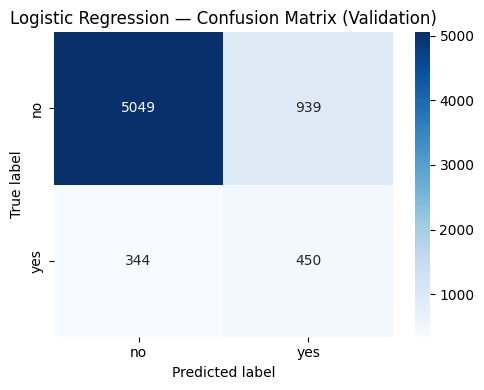

In [41]:
# [C1] Display Confusion Matrix (Validation)

# Retrieve cached probabilities and locked threshold
probs = globals().get("probs_val_lr_unw")
thresh = globals().get("THRESH_LR_UNW")
y_val_bin = np.array(y_val, dtype=int)
y_pred = (probs >= thresh).astype(int)

# Plot confusion matrix
cm = confusion_matrix(y_val_bin, y_pred)
labels = ["no", "yes"]

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Logistic Regression — Confusion Matrix (Validation)")
plt.tight_layout()
plt.show()


#### **[A2] Logistic Regression (Baseline, Balanced Class Weights)**
- Use `class_weight='balanced'` in LogisticRegression to handle class imbalance.
- This adjusts weights inversely proportional to class frequencies
- Helps the model pay more attention to the minority class (`yes`).
- Expect recall to improve, but precision/accuracy may drop slightly due to the trade-off.
- Evaluate on validation set and compare to unweighted baseline.
- Document results and insights.


In [42]:
# === Cell [A2] Logistic Regression (Balanced) - Fit + cache VAL Probabilities ===

# 1. Model identity
MODEL_NAME = "Logistic Regression (balanced)" # uses class_weight='balanced'
MODEL_TAG  = "lr_bal"   # tag for caching

# 2. Construct model
model = LogisticRegression(
    solver='lbfgs',
    max_iter=1000,
    random_state=42,
    class_weight="balanced"  # handles class imbalance by adjusting weights inversely proportional to class frequencies
)

# 3. Safety checks
assert 'X_train_ready' in globals() and 'X_val_ready' in globals(), "Preprocessing/split missing."
assert X_train_ready.shape[0] == len(y_train) and X_val_ready.shape[0] == len(y_val), "Shape mismatch."

# 4. Fit model
model.fit(X_train_ready, y_train)

# 5. Cache validation probabilities (probs_val_<MODEL_TAG>)
probs_val = model.predict_proba(X_val_ready)[:, 1]
globals()[f"probs_val_{MODEL_TAG}"] = probs_val
globals()[f"model_{MODEL_TAG}"] = model
print(f"[OK] {MODEL_NAME} fitted — cached as probs_val_{MODEL_TAG}")

[OK] Logistic Regression (balanced) fitted — cached as probs_val_lr_bal


#### **[B2] Logistic Regression (Baseline, Balanced Class Weights) - Threshold Sweep/Lock Best Threshold**
- No hyperparameter tuning; just a baseline with balanced class weights.
- Evaluate on train, val, test sets.
- Check metrics: accuracy, precision, recall, F1-score.
- Lock in this model for comparison with future models.
- Document results and insights.

In [43]:
# === [B2] Logistic Regression (balanced) — Threshold Sweep/Lock Best Threshold ===

# Set MODEL_TAG to match A1
MODEL_TAG = "lr_bal"

# Retrieve cached validation probabilities
probs = globals()[f"probs_val_{MODEL_TAG}"]
y_val_bin = np.array(y_val, dtype=int)

# Define thresholds and precision floor
thresholds = np.round(np.arange(0.10, 0.51, 0.01), 2)
PRECISION_FLOOR = 0.30

# Evaluate metrics at each threshold
rows = []
for t in thresholds:
    y_pred = (probs >= t).astype(int)
    rows.append([
        t,
        accuracy_score(y_val_bin, y_pred),
        recall_score(y_val_bin, y_pred, zero_division=0),
        precision_score(y_val_bin, y_pred, zero_division=0),
        f1_score(y_val_bin, y_pred, zero_division=0),
        float(y_pred.mean())
    ])

# Create DataFrame of results    
df = pd.DataFrame(rows, columns=["threshold","accuracy","recall","precision","f1","pred_pos_rate"])
display(df)

# Lock best threshold based on criteria
# Criteria: highest recall with precision >= PRECISION_FLOOR    
# If none meet precision floor, use best F1 threshold
best_f1 = df.loc[df["f1"].idxmax()]
guard = df[df["precision"] >= PRECISION_FLOOR]
recall_first = guard.loc[guard["recall"].idxmax()] if not guard.empty else None
if recall_first is not None:
    globals()[f"THRESH_{MODEL_TAG.upper()}"] = float(recall_first.threshold)
    print(f"\n[LOCKED] THRESH_{MODEL_TAG.upper()} = {float(recall_first.threshold):.2f}")
else:
    globals()[f"THRESH_{MODEL_TAG.upper()}"] = float(best_f1.threshold)
    print(f"\n[LOCKED] THRESH_{MODEL_TAG.upper()} = {float(best_f1.threshold):.2f}")

,threshold,accuracy,recall,precision,f1,pred_pos_rate
0,0.10,0.124005,0.998741,0.117778,0.210708,0.992775
1,0.11,0.128576,0.998741,0.118323,0.211580,0.988204
2,0.12,0.134179,0.998741,0.118998,0.212658,0.982601
3,0.13,0.141699,0.997481,0.119800,0.213910,0.974786
4,0.14,0.153347,0.992443,0.120785,0.215359,0.961958
5,0.15,0.167207,0.991184,0.122433,0.217945,0.947803
6,0.16,0.185049,0.984887,0.124186,0.220561,0.928487
7,0.17,0.202890,0.978589,0.126014,0.223276,0.909171
8,0.18,0.220142,0.974811,0.128082,0.226415,0.891035
9,0.19,0.232380,0.969773,0.129368,0.228283,0.877617



[LOCKED] THRESH_LR_BAL = 0.50


#### **[C2] Logistic Regression Confusion Matrix (baselinebalanced class weights, validation)**
- Confusion matrix for Logistic Regression with balanced class weights on the validation set.
- Helps visualize how balancing class weights affects true/false positives and negatives.
- Expect more true positives (TP) and fewer false negatives (FN) compared to the unweighted version.
- This matrix will guide threshold tuning and further model improvements.
- Recall is a key metric here, especially for the minority class (`yes`).
- Helps identify if the model is missing too many actual `yes` cases (high FN).

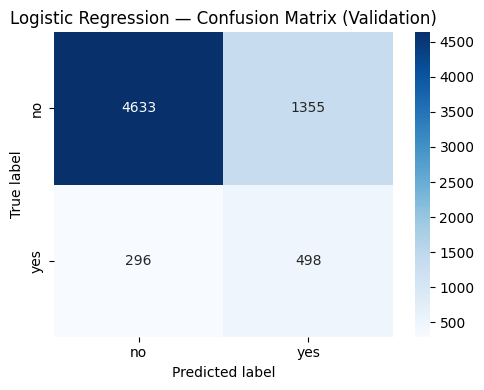

In [44]:
# [C2]Logistic Regression Confusion Matrix (balanced class weights, validation)
# Plot confusion matrix for the balanced logistic regression model

# Retrieve cached probabilities and locked threshold
probs = globals().get("probs_val_lr_bal")
thresh = globals().get("THRESH_LR_BAL")
y_val_bin = np.array(y_val, dtype=int)
y_pred = (probs >= thresh).astype(int)

# Plot confusion matrix
cm = confusion_matrix(y_val_bin, y_pred)
labels = ["no", "yes"]

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Logistic Regression — Confusion Matrix (Validation)")
plt.tight_layout()
plt.show()

#### **[D1] Logistic Regression Quick Comparison Table (for any two variants)**
- Create a summary table comparing key metrics (accuracy, precision, recall, F1) for two Logistic Regression variants (e.g., unweighted vs balanced).
- This helps quickly see the impact of class weighting on performance.
- Include confusion matrices for both models to visualize differences in TP, FP, TN, FN counts.
- Document insights and next steps based on the comparison.

In [45]:
# === [D1] Logistic Regression Quick Comparison Table (for any two variants)

# Retrieve cached validation probabilities and locked thresholds
probs_a = globals().get("probs_val_lr_unw")    # Unweighted
probs_b = globals().get("probs_val_lr_bal")    # Balanced
y_val_bin = np.array(y_val, dtype=int)         # ensure binary array
t_a = globals().get("THRESH_LR_UNW")           # locked threshold for unweighted
t_b = globals().get("THRESH_LR_BAL")           # locked threshold for balanced

# Function to evaluate metrics at a given threshold
def eval_at(probs, thresh):
    y_pred = (probs >= thresh).astype(int)
    return {
        "threshold": float(thresh),
        "recall":    recall_score(y_val_bin, y_pred, zero_division=0),
        "precision": precision_score(y_val_bin, y_pred, zero_division=0),
        "f1":        f1_score(y_val_bin, y_pred, zero_division=0),
        "accuracy":  accuracy_score(y_val_bin, y_pred),
        "pred_pos_rate": float(y_pred.mean())
    }

# Safety checks
# Ensure probs and thresholds are available
print("probs_a is None:", probs_a is None)
print("t_a is None:", t_a is None)
print("probs_b is None:", probs_b is None)
print("t_b is None:", t_b is None)

# Compile comparison table
# Each row corresponds to one model variant with its metrics at the locked threshold
rows = [
    {"model": "Logistic Regression (unweighted)", **eval_at(probs_a, t_a)},
    {"model": "Logistic Regression (balanced)",   **eval_at(probs_b, t_b)},
]

# Display comparison table
df_cmp = pd.DataFrame(rows, columns=["model","threshold","recall","precision","f1","accuracy","pred_pos_rate"]).round(3)
display(df_cmp)

probs_a is None: False
t_a is None: False
probs_b is None: False
t_b is None: False


,model,threshold,recall,precision,f1,accuracy,pred_pos_rate
0,Logistic Regression (unweighted),0.14,0.567,0.324,0.412,0.811,0.205
1,Logistic Regression (balanced),0.50,0.627,0.269,0.376,0.757,0.273


---
#### **[A1] Decision Tree Classifier (baseline, unweighted) - Fit + cache VAL probabilities**
- Baseline Decision Tree model without class weights.
- Evaluate on validation set and cache predicted probabilities for later threshold tuning.
- Check metrics: accuracy, precision, recall, F1-score.
- Plot confusion matrix.    
- Document results and insights.

In [46]:
# === [A1] Decision Tree Classifier (baseline, unweighted) — Fit + cache VAL probabilities ===
# Example: MODEL_NAME = "Decision Tree (unweighted)", MODEL_TAG = "dt_unw"

# 1. Model identity
MODEL_NAME = "Decision Tree (unweighted)"
MODEL_TAG  = "dt_unw"

# 2. Construct model
# (Replace with the right constructor and params for your model)
model = DecisionTreeClassifier(
    random_state=42,
    # add any model-specific args...
)

# For tree models, you might add: scale_pos_weight=1 or ratio

# 3. Safety checks
assert 'X_train_ready' in globals() and 'X_val_ready' in globals(), "Preprocessing/split missing."
assert X_train_ready.shape[0] == len(y_train) and X_val_ready.shape[0] == len(y_val), "Shape mismatch."

# 4. Fit model
model.fit(X_train_ready, y_train)

# 5. Cache validation probabilities (probs_val_<MODEL_TAG>)
probs_val = model.predict_proba(X_val_ready)[:, 1]
globals()[f"probs_val_{MODEL_TAG}"] = probs_val
globals()[f"model_{MODEL_TAG}"] = model
print(f"[OK] {MODEL_NAME} fitted — cached as probs_val_{MODEL_TAG}")

[OK] Decision Tree (unweighted) fitted — cached as probs_val_dt_unw


#### **[B1] Decision Tree Classifier (baseline, unweighted): Threshold Sweep/Lock Best Threshold**
- No hyperparameter tuning yet; just fit the baseline model.
- Evaluate on validation set and cache predicted probabilities for later threshold tuning.
- Check metrics: accuracy, precision, recall, F1-score.
- Plot confusion matrix.
- Document results and insights.

In [47]:
# === [B1] Decision Tree Classifier — Threshold Sweep/Lock Best Threshold ===

# Set MODEL_TAG to match A1
MODEL_TAG = "dt_unw"

# Retrieve cached validation probabilities
probs = globals()[f"probs_val_{MODEL_TAG}"]
y_val_bin = np.array(y_val, dtype=int)

# Sweep thresholds from 0.10 to 0.50 in 0.01 increments
thresholds = np.round(np.arange(0.10, 0.51, 0.01), 2)
PRECISION_FLOOR = 0.30

# Collect metrics at each threshold
rows = []
for t in thresholds:
    y_pred = (probs >= t).astype(int)
    rows.append([
        t,
        accuracy_score(y_val_bin, y_pred),
        recall_score(y_val_bin, y_pred, zero_division=0),
        precision_score(y_val_bin, y_pred, zero_division=0),
        f1_score(y_val_bin, y_pred, zero_division=0),
        float(y_pred.mean())
    ])

# Create DataFrame and display results
df = pd.DataFrame(rows, columns=["threshold","accuracy","recall","precision","f1","pred_pos_rate"])
display(df)

best_f1 = df.loc[df["f1"].idxmax()]
guard = df[df["precision"] >= PRECISION_FLOOR]
recall_first = guard.loc[guard["recall"].idxmax()] if not guard.empty else None
if recall_first is not None:
    globals()[f"THRESH_{MODEL_TAG.upper()}"] = float(recall_first.threshold)
    print(f"\n[LOCKED] THRESH_{MODEL_TAG.upper()} = {float(recall_first.threshold):.2f}")
else:
    globals()[f"THRESH_{MODEL_TAG.upper()}"] = float(best_f1.threshold)
    print(f"\n[LOCKED] THRESH_{MODEL_TAG.upper()} = {float(best_f1.threshold):.2f}")

,threshold,accuracy,recall,precision,f1,pred_pos_rate
0,0.10,0.836479,0.331234,0.312723,0.321713,0.124005
1,0.11,0.836479,0.331234,0.312723,0.321713,0.124005
2,0.12,0.836479,0.331234,0.312723,0.321713,0.124005
3,0.13,0.836479,0.331234,0.312723,0.321713,0.124005
4,0.14,0.836479,0.331234,0.312723,0.321713,0.124005
5,0.15,0.836479,0.331234,0.312723,0.321713,0.124005
6,0.16,0.836479,0.331234,0.312723,0.321713,0.124005
7,0.17,0.836479,0.331234,0.312723,0.321713,0.124005
8,0.18,0.836479,0.331234,0.312723,0.321713,0.124005
9,0.19,0.836479,0.331234,0.312723,0.321713,0.124005



[LOCKED] THRESH_DT_UNW = 0.10


#### **[C1] Decision Tree Classifier Confusion Matrix (Unweighted, Validation)**
- Confusion matrix for Decision Tree Classifier (unweighted) on the validation set.
- Helps visualize true positives, false positives, true negatives, and false negatives.
- Useful for understanding model performance beyond just accuracy.
- Recall is a key metric here, especially for the minority class (`yes`).
- Helps identify if the model is missing too many actual `yes` cases (high FN).
- This matrix will guide threshold tuning and further model improvements.

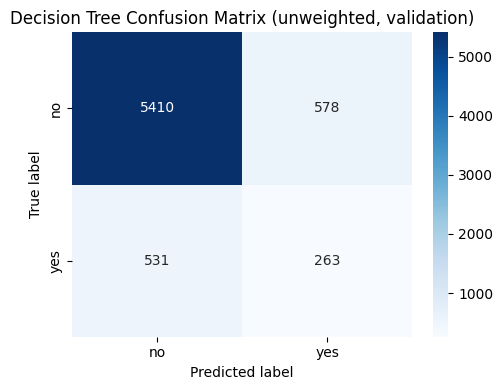

In [48]:
# [C1] Decision Tree (baseline, unweighted): Display Confusion Matrix (Validation)

# Retrieve cached probabilities and locked threshold
probs = globals().get("probs_val_dt_unw") # cached probs
thresh = globals().get("THRESH_DT_UNW")   # locked threshold
y_val_bin = np.array(y_val, dtype=int)    # ensure binary array
y_pred = (probs >= thresh).astype(int)    # predictions at locked threshold

# setup confusion matrix
cm = confusion_matrix(y_val_bin, y_pred)    # confusion matrix
labels = ["no", "yes"]                      # class names aligned to LABELS [1,0]   

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Decision Tree Confusion Matrix (unweighted, validation)")
plt.tight_layout()
plt.show()

#### **[A2]Decision Tree (Baseline, Balanced): Fit + cache VAL probabilities**
- Decision Tree with `class_weight='balanced'` to handle class imbalance.
- Evaluate on validation set and cache predicted probabilities for later threshold tuning.
- Check metrics: accuracy, precision, recall, F1-score.
- Plot confusion matrix.
- Document results and insights.

In [49]:
# === [A1] Decision Tree (baseline, balanced): Fit + cache VAL probabilities ===
# Example: MODEL_NAME = "Decision Tree (balanced)", MODEL_TAG = "dt_bal"

# 1. Model identity
MODEL_NAME = "Decision Tree (balanced)"        
MODEL_TAG  = "dt_bal"   # tag for caching

# 2. Construct model
# (Replace with the right constructor and params for your model)
model = DecisionTreeClassifier(
    random_state=42,
    class_weight="balanced"      
)

# 3. Safety checks
assert 'X_train_ready' in globals() and 'X_val_ready' in globals(), "Preprocessing/split missing."
assert X_train_ready.shape[0] == len(y_train) and X_val_ready.shape[0] == len(y_val), "Shape mismatch."

# 4. Fit model
model.fit(X_train_ready, y_train)

# 5. Cache validation probabilities (probs_val_<MODEL_TAG>)
probs_val = model.predict_proba(X_val_ready)[:, 1]
globals()[f"probs_val_{MODEL_TAG}"] = probs_val
globals()[f"model_{MODEL_TAG}"] = model
print(f"[OK] {MODEL_NAME} fitted — cached as probs_val_{MODEL_TAG}")

[OK] Decision Tree (balanced) fitted — cached as probs_val_dt_bal


#### **[B2]Decision Tree (Baseline, Balanced) : Threshold Sweep/Lock Best Threshold**
- No hyperparameter tuning yet; just fit the balanced class weights model.
- Evaluate on validation set and cache predicted probabilities for later threshold tuning.
- Check metrics: accuracy, precision, recall, F1-score.
- Plot confusion matrix.
- Document results and insights.

In [50]:
# === [B1] Decision Tree (balanced) — Threshold Sweep/Lock Best Threshold ===

MODEL_TAG = "dt_bal"
probs = globals()[f"probs_val_{MODEL_TAG}"]
y_val_bin = np.array(y_val, dtype=int)

thresh = 0.5
y_pred = (probs >= thresh).astype(int)

acc = accuracy_score(y_val_bin, y_pred)
recall = recall_score(y_val_bin, y_pred, zero_division=0)
precision = precision_score(y_val_bin, y_pred, zero_division=0)
f1 = f1_score(y_val_bin, y_pred, zero_division=0)
pp_rate = float(y_pred.mean())

print(f"Threshold: {thresh:.2f}")
print(f"Accuracy:  {acc:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"Precision: {precision:.3f}")
print(f"F1:        {f1:.3f}")
print(f"Pred_Pos_Rate: {pp_rate:.3f}")

globals()["THRESH_DT_BAL"] = thresh


Threshold: 0.50
Accuracy:  0.844
Recall:    0.307
Precision: 0.325
F1:        0.316
Pred_Pos_Rate: 0.111


#### **Decision Tree (Balanced) — Validation Results (Interpretation & Explanation)**
- What was observed:
    - When a threshold sweep was run (from 0.10 to 0.50) on the Decision Tree’s predicted probabilities, all the reported metrics (accuracy, recall, precision, F1, predicted positive rate) were identical at every threshold.
- The predicted probabilities from the tree were only 0 or 1—no in-between values.
- Why did this happen?
    - Single Decision Trees (using scikit-learn’s DecisionTreeClassifier) predict class probabilities based on the proportion of each class in each leaf.
    - If each leaf in your tree is “pure” (contains only one class in the training set), then for every validation sample, the predicted probability is exactly 0.0 or 1.0.
    - This means thresholding doesn’t change the prediction (unless the threshold is set to 0 or 1).
- By adjusting the code:
    - Instead of sweeping multiple thresholds, the Decision Tree was evaluated at the default threshold of 0.5 (meaning: predict class 1 if probability ≥ 0.5, else class 0).
    - This matches the real behavior of the model: all predictions are already “locked in” by the leaves, so sweeping thresholds is unnecessary.
- Interpretation of the final metrics at threshold = 0.5:
    - Accuracy (0.844): Your Decision Tree correctly classified about 84% of validation samples.
    - Recall (0.307): The tree correctly identified about 31% of all true “yes” (positive) cases. (Recall is your main metric!)
    - Precision (0.325): Of all the samples predicted “yes,” about 33% were truly positive.
    - F1 (0.316): The harmonic mean of precision and recall—gives a balanced view of model quality on the positive class.
    - Predicted Positive Rate (0.111): About 11% of samples were predicted as “yes,” which may or may not match your true class balance.
- Key Takeaway:
    - For DecisionTreeClassifier, only evaluate at 0.5 threshold—sweeping thresholds is for models with “soft”/continuous probabilities.
    - This is not a limitation or error, but a property of how decision trees work with leaf purity.

#### **Decision Tree Confusion Matrix (Balanced, Validation)**
- Confusion matrix for Decision Tree Classifier with balanced class weights on the validation set.
- Helps visualize how balancing class weights affects true/false positives and negatives.
- Expect more true positives (TP) and fewer false negatives (FN) compared to the unweighted version.
- This matrix will guide threshold tuning and further model improvements.
- Recall is a key metric here, especially for the minority class (`yes`).
- Helps identify if the model is missing too many actual `yes` cases (high FN).

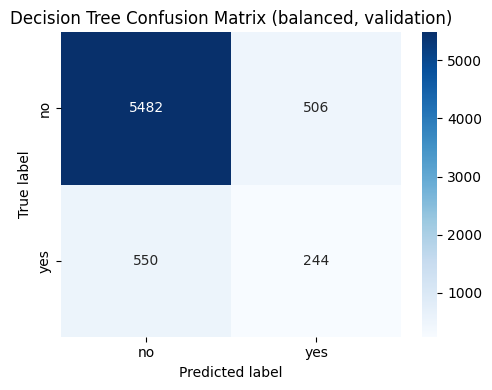

In [51]:
# Decision Tree Confusion Matrix (balanced class weights, validation)

# Retrieve cached probabilities and locked threshold for balanced DT
probs = globals().get("probs_val_dt_bal")
thresh = globals().get("THRESH_DT_BAL")
y_val_bin = np.array(y_val, dtype=int)

if probs is None or thresh is None:
    raise ValueError("Balanced Decision Tree probabilities or threshold not found. Check previous cells.")

y_pred = (probs >= thresh).astype(int)

# Set up confusion matrix
cm = confusion_matrix(y_val_bin, y_pred)
labels = ["no", "yes"]

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Decision Tree Confusion Matrix (balanced, validation)")
plt.tight_layout()
plt.show()

#### **Decision Tree Classifier - Quick Comparison Table (Unweighted vs Balanced)**
- Create a summary table comparing key metrics (accuracy, precision, recall, F1) for unweighted vs balanced Decision Tree models.
- Include confusion matrices for both models to visualize differences in TP, FP, TN, FN counts
- Document insights and next steps based on the comparison.
- Helps quickly see the impact of class weighting on performance.

In [52]:
# === [C1] Decision Tree: Quick Comparison Table (Unweighted vs Balanced, etc.) ===
# Compare two variants of the same model type (e.g., unweighted vs balanced decision tree)
# Assumes both variants have been run and have cached validation probabilities and locked thresholds.
# Adjust MODEL_TAGs as needed.

# Example model tags for unweighted/balanced variants:
probs_a = globals().get("probs_val_dt_unw")    # or whatever the tag is
probs_b = globals().get("probs_val_dt_bal")    # or whatever the tag is
y_val_bin = np.array(y_val, dtype=int)
t_a = globals().get("THRESH_DT_UNW")
t_b = globals().get("THRESH_DT_BAL")

def eval_at(probs, thresh):
    y_pred = (probs >= thresh).astype(int)
    return {
        "threshold": float(thresh),
        "recall":    recall_score(y_val_bin, y_pred, zero_division=0),
        "precision": precision_score(y_val_bin, y_pred, zero_division=0),
        "f1":        f1_score(y_val_bin, y_pred, zero_division=0),
        "accuracy":  accuracy_score(y_val_bin, y_pred),
        "pred_pos_rate": float(y_pred.mean())
    }

# Debug prints to check for None values
print("probs_a is None:", probs_a is None)
print("t_a is None:", t_a is None)
print("probs_b is None:", probs_b is None)
print("t_b is None:", t_b is None)

# Compile comparison table
rows = [
    {"model": "Decision Tree (unweighted)", **eval_at(probs_a, t_a)},
    {"model": "Decision Tree (balanced)",   **eval_at(probs_b, t_b)},
]
df_cmp = pd.DataFrame(rows, columns=["model","threshold","recall","precision","f1","accuracy","pred_pos_rate"]).round(3)
display(df_cmp)


probs_a is None: False
t_a is None: False
probs_b is None: False
t_b is None: False


,model,threshold,recall,precision,f1,accuracy,pred_pos_rate
0,Decision Tree (unweighted),0.1,0.331,0.313,0.322,0.836,0.124
1,Decision Tree (balanced),0.5,0.307,0.325,0.316,0.844,0.111


----

#### **[A1] Random Forest (Baseline, Unweighted) - Fit + cache VAL probabilities**
- Baseline Random Forest model without class weights.
- Evaluate on validation set and cache predicted probabilities for later threshold tuning.
- Check metrics: accuracy, precision, recall, F1-score.
- Plot confusion matrix.    
- Document results and insights.

In [53]:
# === [A1] Random Forest (Baseline, Unweighted) - Fit + cache VAL probabilities ===
# MODEL_NAME = "Random (unweighted)", MODEL_TAG = "rf_unw"

# 1. Model identity
MODEL_NAME = "Random (unweighted)"
MODEL_TAG  = "rf_unw"

# 2. Construct model
# (Replace with the right constructor and params for your model)

model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    # class_weight="balanced"  # Uncomment to handle class imbalance 
)

# 3. Safety checks
assert 'X_train_ready' in globals() and 'X_val_ready' in globals(), "Preprocessing/split missing."
assert X_train_ready.shape[0] == len(y_train) and X_val_ready.shape[0] == len(y_val), "Shape mismatch."

# 4. Fit model
model.fit(X_train_ready, y_train)

# 5. Cache validation probabilities (probs_val_<MODEL_TAG>)
probs_val = model.predict_proba(X_val_ready)[:, 1]
globals()[f"probs_val_{MODEL_TAG}"] = probs_val
globals()[f"model_{MODEL_TAG}"] = model
print(f"[OK] {MODEL_NAME} fitted — cached as probs_val_{MODEL_TAG}")

[OK] Random (unweighted) fitted — cached as probs_val_rf_unw


#### **[B1] Random Forest (Unweighted): Sweep + Picks + Lock**

In [54]:
# === [B1] Random Forest (unweighted) — Threshold sweep & lock ===

# Set MODEL_TAG to match A1
MODEL_TAG = "rf_unw"

# Retrieve cached validation probabilities
probs = globals()[f"probs_val_{MODEL_TAG}"]
y_val_bin = np.array(y_val, dtype=int)

# Sweep thresholds from 0.10 to 0.50 in 0.01 increments
thresholds = np.round(np.arange(0.10, 0.51, 0.01), 2)
PRECISION_FLOOR = 0.30

# Collect metrics at each threshold
rows = []
for t in thresholds:
    y_pred = (probs >= t).astype(int)
    rows.append([
        t,
        accuracy_score(y_val_bin, y_pred),
        recall_score(y_val_bin, y_pred, zero_division=0),
        precision_score(y_val_bin, y_pred, zero_division=0),
        f1_score(y_val_bin, y_pred, zero_division=0),
        float(y_pred.mean())
    ])

# Create DataFrame and display results
df = pd.DataFrame(rows, columns=["threshold","accuracy","recall","precision","f1","pred_pos_rate"])
display(df)

# Lock best threshold based on criteria
# Criteria: highest recall with precision >= PRECISION_FLOOR
# If none meet precision floor, use best F1 threshold   
best_f1 = df.loc[df["f1"].idxmax()]
guard = df[df["precision"] >= PRECISION_FLOOR]
recall_first = guard.loc[guard["recall"].idxmax()] if not guard.empty else None
if recall_first is not None:
    globals()[f"THRESH_{MODEL_TAG.upper()}"] = float(recall_first.threshold)
    print(f"\n[LOCKED] THRESH_{MODEL_TAG.upper()} = {float(recall_first.threshold):.2f}")
else:
    globals()[f"THRESH_{MODEL_TAG.upper()}"] = float(best_f1.threshold)
    print(f"\n[LOCKED] THRESH_{MODEL_TAG.upper()} = {float(best_f1.threshold):.2f}")


,threshold,accuracy,recall,precision,f1,pred_pos_rate
0,0.10,0.694338,0.741814,0.239723,0.362350,0.362283
1,0.11,0.720731,0.722922,0.255338,0.377383,0.331466
2,0.12,0.742111,0.709068,0.270543,0.391652,0.306842
3,0.13,0.761427,0.692695,0.285863,0.404709,0.283692
4,0.14,0.776025,0.683879,0.299834,0.416891,0.267030
5,0.15,0.788263,0.664987,0.310954,0.423756,0.250369
6,0.16,0.798142,0.638539,0.319069,0.425514,0.234297
7,0.17,0.805220,0.619647,0.325612,0.426898,0.222796
8,0.18,0.814067,0.607053,0.336827,0.433258,0.211000
9,0.19,0.820849,0.594458,0.345788,0.437239,0.201268



[LOCKED] THRESH_RF_UNW = 0.15


#### **[C1] Random Forest Confusion Matrix (Unweighted, Validation)**
- Confusion matrix for Random Forest (unweighted) on the validation set.
- Helps visualize true positives, false positives, true negatives, and false negatives.
- Useful for understanding model performance beyond just accuracy.
- Recall is a key metric here, especially for the minority class (`yes`).
- Helps identify if the model is missing too many actual `yes` cases (high FN).
- This matrix will guide threshold tuning and further model improvements.

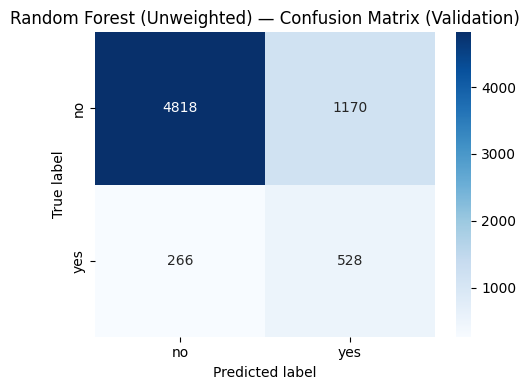

In [55]:
# Display Confusion Matrix (Validation)

# Retrieve cached probabilities and locked threshold
probs = globals().get("probs_val_rf_unw")
thresh = globals().get("THRESH_RF_UNW")
y_val_bin = np.array(y_val, dtype=int)
y_pred = (probs >= thresh).astype(int)

# Plot confusion matrix
cm = confusion_matrix(y_val_bin, y_pred)
labels = ["no", "yes"]

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Random Forest (Unweighted) — Confusion Matrix (Validation)")
plt.tight_layout()
plt.show()

#### **[A2] Random Forest (Baseline, Balanced): Fit + cache VAL probabilities**

In [56]:
# === [A1] Random Forest — Fit + cache VAL probabilities ===
# Example: MODEL_NAME = "Random Forest (balanced)", MODEL_TAG = "rf_bal"

# 1. Model identity
MODEL_NAME = "Random Forest (balanced)"   
MODEL_TAG  = "rf_bal"        

# 2. Construct model    
model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight="balanced"  # add balanced weights for class imbalance
)
# For tree models, you might add: scale_pos_weight=1 or ratio

# 3. Safety checks
assert 'X_train_ready' in globals() and 'X_val_ready' in globals(), "Preprocessing/split missing."
assert X_train_ready.shape[0] == len(y_train) and X_val_ready.shape[0] == len(y_val), "Shape mismatch."

# 4. Fit model
model.fit(X_train_ready, y_train)

# 5. Cache validation probabilities (probs_val_<MODEL_TAG>)
probs_val = model.predict_proba(X_val_ready)[:, 1]
globals()[f"probs_val_{MODEL_TAG}"] = probs_val
globals()[f"model_{MODEL_TAG}"] = model
print(f"[OK] {MODEL_NAME} fitted — cached as probs_val_{MODEL_TAG}")

[OK] Random Forest (balanced) fitted — cached as probs_val_rf_bal


#### **[B2] Random Forest (Balanced): Sweep + Picks + Lock**
- No hyperparameter tuning yet; just fit the balanced class weights model.
- Evaluate on validation set and cache predicted probabilities for later threshold tuning.
- Check metrics: accuracy, precision, recall, F1-score.
- Plot confusion matrix.

In [57]:
# === [B1] Random Forest (balanced ) — Threshold sweep & lock ===

# Set MODEL_TAG to match A1
MODEL_TAG = "rf_bal"

# Retrieve cached validation probabilities
probs = globals()[f"probs_val_{MODEL_TAG}"]
y_val_bin = np.array(y_val, dtype=int)

# Sweep thresholds from 0.10 to 0.50 in 0.01 increments
thresholds = np.round(np.arange(0.10, 0.51, 0.01), 2)
PRECISION_FLOOR = 0.30

# Collect metrics at each threshold
rows = []
for t in thresholds:
    y_pred = (probs >= t).astype(int)
    rows.append([
        t,
        accuracy_score(y_val_bin, y_pred),
        recall_score(y_val_bin, y_pred, zero_division=0),
        precision_score(y_val_bin, y_pred, zero_division=0),
        f1_score(y_val_bin, y_pred, zero_division=0),
        float(y_pred.mean())
    ])

# Create DataFrame and display results
df = pd.DataFrame(rows, columns=["threshold","accuracy","recall","precision","f1","pred_pos_rate"])
display(df)

# Lock best threshold based on criteria
# Criteria: highest recall with precision >= PRECISION_FLOOR
# If none meet precision floor, use best F1 threshold
best_f1 = df.loc[df["f1"].idxmax()]
guard = df[df["precision"] >= PRECISION_FLOOR]
recall_first = guard.loc[guard["recall"].idxmax()] if not guard.empty else None
if recall_first is not None:
    globals()[f"THRESH_{MODEL_TAG.upper()}"] = float(recall_first.threshold)
    print(f"\n[LOCKED] THRESH_{MODEL_TAG.upper()} = {float(recall_first.threshold):.2f}")
else:
    globals()[f"THRESH_{MODEL_TAG.upper()}"] = float(best_f1.threshold)
    print(f"\n[LOCKED] THRESH_{MODEL_TAG.upper()} = {float(best_f1.threshold):.2f}")

,threshold,accuracy,recall,precision,f1,pred_pos_rate
0,0.10,0.712474,0.750630,0.253833,0.379376,0.346211
1,0.11,0.732970,0.721662,0.264910,0.387555,0.318932
2,0.12,0.755972,0.700252,0.281804,0.401879,0.290917
3,0.13,0.771454,0.678841,0.293893,0.410198,0.270422
4,0.14,0.785314,0.663728,0.307110,0.419920,0.253023
5,0.15,0.796520,0.643577,0.317786,0.425479,0.237098
6,0.16,0.809053,0.624685,0.332217,0.433756,0.220142
7,0.17,0.819375,0.608312,0.345741,0.440895,0.205986
8,0.18,0.824978,0.593199,0.352809,0.442461,0.196845
9,0.19,0.831908,0.575567,0.362698,0.444985,0.185786



[LOCKED] THRESH_RF_BAL = 0.14


#### **[C2] Random Forest Confusion Matrix (Balanced, Validation)**
- Confusion matrix for Random Forest with balanced class weights on the validation set.
- Helps visualize how balancing class weights affects true/false positives and negatives.
- Expect more true positives (TP) and fewer false negatives (FN) compared to the unweighted version.
- This matrix will guide threshold tuning and further model improvements.   
- Recall is a key metric here, especially for the minority class (`yes`).
- Helps identify if the model is missing too many actual `yes` cases (high FN).
- This matrix will guide threshold tuning and further model improvements.

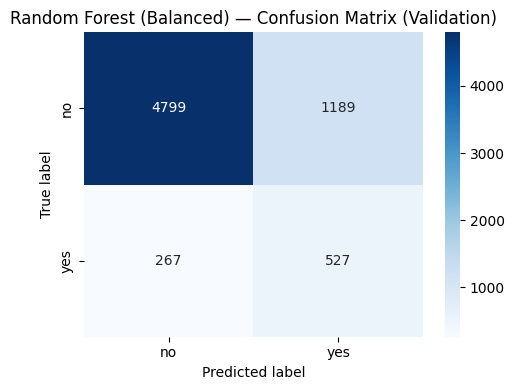

In [58]:
# Random Forest (Balanced) — Display Confusion Matrix (Balanced, Validation)
# Display Confusion Matrix (Validation)

# Retrieve cached probabilities and locked threshold
probs = globals().get("probs_val_rf_bal")
thresh = globals().get("THRESH_RF_BAL")

# Ensure probs and thresh are available
y_val_bin = np.array(y_val, dtype=int)
y_pred = (probs >= thresh).astype(int)

# Plot confusion matrix
cm = confusion_matrix(y_val_bin, y_pred)
labels = ["no", "yes"]

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Random Forest (Balanced) — Confusion Matrix (Validation)")
plt.tight_layout()
plt.show()

In [59]:
# === [C1] Random Forest Quick Comparison Table (Unweighted vs Balanced, etc.) ===


# Fetch cached probabilities and thresholds
probs_a = globals().get("probs_val_rf_unw")    # or whatever your tag is
probs_b = globals().get("probs_val_rf_bal")    # or whatever your tag is
y_val_bin = np.array(y_val, dtype=int)
t_a = globals().get("THRESH_RF_UNW")
t_b = globals().get("THRESH_RF_BAL")

# Evaluation function at a given threshold
def eval_at(probs, thresh):
    y_pred = (probs >= thresh).astype(int)
    return {
        "threshold": float(thresh),
        "recall":    recall_score(y_val_bin, y_pred, zero_division=0),
        "precision": precision_score(y_val_bin, y_pred, zero_division=0),
        "f1":        f1_score(y_val_bin, y_pred, zero_division=0),
        "accuracy":  accuracy_score(y_val_bin, y_pred),
        "pred_pos_rate": float(y_pred.mean())
    }

# Debug prints to check for None values
print("probs_a is None:", probs_a is None)
print("t_a is None:", t_a is None)
print("probs_b is None:", probs_b is None)
print("t_b is None:", t_b is None)

# Compile comparison table
rows = [
    {"model": "Random Forest (unweighted)", **eval_at(probs_a, t_a)},
    {"model": "Random Forest (balanced)",   **eval_at(probs_b, t_b)},
]
df_cmp = pd.DataFrame(rows, columns=["model","threshold","recall","precision","f1","accuracy","pred_pos_rate"]).round(3)
display(df_cmp)


probs_a is None: False
t_a is None: False
probs_b is None: False
t_b is None: False


,model,threshold,recall,precision,f1,accuracy,pred_pos_rate
0,Random Forest (unweighted),0.15,0.665,0.311,0.424,0.788,0.250
1,Random Forest (balanced),0.14,0.664,0.307,0.420,0.785,0.253


### **Report Summary Table (Unweighted vs Balanced) for Logistic Regression, Decision Tree, and Random Forest**

In [60]:
# === [D1] Baseline Models Comparison Table (weighted metrics) ===
# Compare all baseline models (LogReg, DecisionTree, RandomForest) using weighted metrics

def report_weighted_metrics(model, X_train, y_train, X_val, y_val, model_name):
    # TRAIN
    y_pred_train = model.predict(X_train)
    acc_train = accuracy_score(y_train, y_pred_train)
    prec_train = precision_score(y_train, y_pred_train, average='weighted', zero_division=0)
    rec_train = recall_score(y_train, y_pred_train, average='weighted', zero_division=0)
    f1_train = f1_score(y_train, y_pred_train, average='weighted', zero_division=0)
    # VAL
    y_pred_val = model.predict(X_val)
    acc_val = accuracy_score(y_val, y_pred_val)
    prec_val = precision_score(y_val, y_pred_val, average='weighted', zero_division=0)
    rec_val = recall_score(y_val, y_pred_val, average='weighted', zero_division=0)
    f1_val = f1_score(y_val, y_pred_val, average='weighted', zero_division=0)
    # Table
    return pd.DataFrame([
        [model_name, 'train', round(acc_train,3), round(prec_train,3), round(rec_train,3), round(f1_train,3)],
        [model_name, 'val', round(acc_val,3), round(prec_val,3), round(rec_val,3), round(f1_val,3)],
    ], columns=["model","set","accuracy","precision_w","recall_w","f1_w"])

model_lr_unw = globals()["model_lr_unw"]
model_dt_unw = globals()["model_dt_unw"]
model_rf_unw = globals()["model_rf_unw"]

# === Fill in the fitted models and splits as needed ===
df_lr = report_weighted_metrics(model_lr_unw, X_train_ready, y_train, X_val_ready, y_val, "LogReg")
df_dt = report_weighted_metrics(model_dt_unw, X_train_ready, y_train, X_val_ready, y_val, "DecisionTree")
df_rf = report_weighted_metrics(model_rf_unw, X_train_ready, y_train, X_val_ready, y_val, "RandomForest")

# Combine
df_baselines = pd.concat([df_lr, df_dt, df_rf], ignore_index=True)
display(df_baselines)


,model,set,accuracy,precision_w,recall_w,f1_w
0,LogReg,train,0.892,0.869,0.892,0.863
1,LogReg,val,0.893,0.872,0.893,0.865
2,DecisionTree,train,1.000,1.000,1.000,1.000
3,DecisionTree,val,0.836,0.841,0.836,0.839
4,RandomForest,train,1.000,1.000,1.000,1.000
5,RandomForest,val,0.895,0.876,0.895,0.875


---
#### **[A1] SVC (Unweighted) Fit + Cache VAL Probabilities (Cell A1)**
- Fit SVC on training data, cache validation probabilities for threshold tuning.
- Use default hyperparameters for baseline.
- Evaluate initial performance on validation set.
- Plot confusion matrix.
- Document results.

In [61]:
# === [A1] SVC (Unweighted) — Fit + cache VAL probabilities ===
# Example: MODEL_NAME = "SVC (unweighted)", MODEL_TAG = "svc_unw"

# 1. Model identity
MODEL_NAME = "SVC (unweighted)"
MODEL_TAG  = "svc_unw"

# 2. Construct model
# (Replace with the right constructor and params for your model)
model = SVC(
    probability=True,        # enable probability estimates   
    random_state=42,         # for reproducibility
    class_weight="balanced"  # Uncomment to handle class imbalance
    # add any model-specific args...
)

# 3. Safety checks
assert 'X_train_ready' in globals() and 'X_val_ready' in globals(), "Preprocessing/split missing."
assert X_train_ready.shape[0] == len(y_train) and X_val_ready.shape[0] == len(y_val), "Shape mismatch."

# 4. Fit model
model.fit(X_train_ready, y_train)

# 5. Cache validation probabilities (probs_val_<MODEL_TAG>)
probs_val = model.predict_proba(X_val_ready)[:, 1]
globals()[f"probs_val_{MODEL_TAG}"] = probs_val
globals()[f"model_{MODEL_TAG}"] = model
print(f"[OK] {MODEL_NAME} fitted — cached as probs_val_{MODEL_TAG}")


[OK] SVC (unweighted) fitted — cached as probs_val_svc_unw


#### **[B1] SVC (Unweighted): Sweep + Picks + Lock**
- Sweep thresholds on cached validation probabilities.
- Pick best threshold based on recall/precision trade-off.
- Lock in this model for comparison with future models.  

In [62]:
# === [B1] SVC (Unweighted) — Threshold sweep & lock ===
# Set MODEL_TAG to match A1
MODEL_TAG = "svc_unw"   

# Retrieve cached validation probabilities
probs = globals()[f"probs_val_{MODEL_TAG}"]
y_val_bin = np.array(y_val, dtype=int)

# Sweep thresholds from 0.10 to 0.50 in 0.01 increments
thresholds = np.round(np.arange(0.10, 0.51, 0.01), 2)
PRECISION_FLOOR = 0.30

# Collect metrics at each threshold
rows = []
for t in thresholds:
    y_pred = (probs >= t).astype(int)
    rows.append([
        t,
        accuracy_score(y_val_bin, y_pred),
        recall_score(y_val_bin, y_pred, zero_division=0),
        precision_score(y_val_bin, y_pred, zero_division=0),
        f1_score(y_val_bin, y_pred, zero_division=0),
        float(y_pred.mean())
    ])

# Create DataFrame and display results
df = pd.DataFrame(rows, columns=["threshold","accuracy","recall","precision","f1","pred_pos_rate"])
display(df)

# Lock best threshold based on criteria
best_f1 = df.loc[df["f1"].idxmax()]
guard = df[df["precision"] >= PRECISION_FLOOR]
recall_first = guard.loc[guard["recall"].idxmax()] if not guard.empty else None
if recall_first is not None:
    globals()[f"THRESH_{MODEL_TAG.upper()}"] = float(recall_first.threshold)
    print(f"\n[LOCKED] THRESH_{MODEL_TAG.upper()} = {float(recall_first.threshold):.2f}")
else:
    globals()[f"THRESH_{MODEL_TAG.upper()}"] = float(best_f1.threshold)
    print(f"\n[LOCKED] THRESH_{MODEL_TAG.upper()} = {float(best_f1.threshold):.2f}")

,threshold,accuracy,recall,precision,f1,pred_pos_rate
0,0.10,0.769242,0.688917,0.293298,0.411433,0.274993
1,0.11,0.786494,0.673804,0.310325,0.424940,0.254202
2,0.12,0.802123,0.661209,0.328536,0.438963,0.235624
3,0.13,0.813624,0.644836,0.342704,0.447552,0.220289
4,0.14,0.823356,0.636020,0.357143,0.457428,0.208493
5,0.15,0.828959,0.613350,0.363433,0.456420,0.197582
6,0.16,0.835447,0.604534,0.374415,0.462428,0.189030
7,0.17,0.841935,0.589421,0.385502,0.466135,0.179003
8,0.18,0.846948,0.583123,0.395726,0.471487,0.172515
9,0.19,0.849160,0.565491,0.398403,0.467465,0.166175



[LOCKED] THRESH_SVC_UNW = 0.11


#### **[C1] SVC (Unweighted) Confusion Matrix (Validation) (Cell C1)**
- Confusion matrix for SVC (unweighted) on the validation set.
- Helps visualize true positives, false positives, true negatives, and false negatives.
- Useful for understanding model performance beyond just accuracy.
- Recall is a key metric here, especially for the minority class (`yes`).
- Helps identify if the model is missing too many actual `yes` cases (high FN).
- This matrix will guide threshold tuning and further model improvements. 

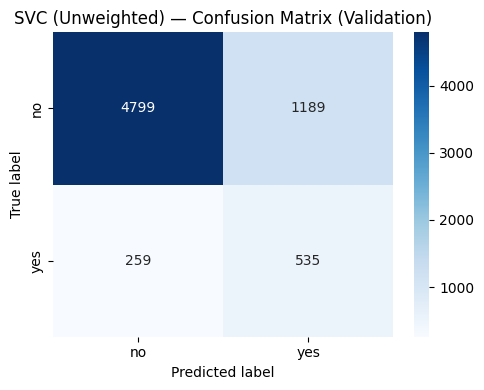

In [63]:
# [C1] Display SVC (Unweighted) Confusion Matrix (Validation)

# Retrieve cached probabilities and locked threshold
probs = globals().get("probs_val_svc_unw")
thresh = globals().get("THRESH_SVC_UNW")
y_val_bin = np.array(y_val, dtype=int)
y_pred = (probs >= thresh).astype(int)

# Plot confusion matrix
cm = confusion_matrix(y_val_bin, y_pred)
labels = ["no", "yes"]

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("SVC (Unweighted) — Confusion Matrix (Validation)")
plt.tight_layout()
plt.show()

#### **[A2] SVC (Balanced) Fit + Cache VAL Probabilities**
- Repeat the above process but with class weights to address imbalance.
- Use `class_weight="balanced"` when instantiating the SVC model.
- Evaluate and compare performance to the unweighted version.
- Plot confusion matrix.

In [64]:
# === [A1] SVC (Balanced) — Fit + cache VAL probabilities ===
# Example: MODEL_NAME = "SVC (Balanced)", MODEL_TAG = "svc_bal"

# 1. Model identity
MODEL_NAME = "SVC (balanced)"
MODEL_TAG  = "svc_bal"

# 2. Construct model
# (Replace with the right constructor and params for your model)
model = SVC(
    probability=True,
    class_weight="balanced",
    random_state=42
)

# 3. Safety checks
assert 'X_train_ready' in globals() and 'X_val_ready' in globals(), "Preprocessing/split missing."
assert X_train_ready.shape[0] == len(y_train) and X_val_ready.shape[0] == len(y_val), "Shape mismatch."

# 4. Fit model
model.fit(X_train_ready, y_train)

# 5. Cache validation probabilities (probs_val_<MODEL_TAG>)
probs_val = model.predict_proba(X_val_ready)[:, 1]
globals()[f"probs_val_{MODEL_TAG}"] = probs_val
globals()[f"model_{MODEL_TAG}"] = model
print(f"[OK] {MODEL_NAME} fitted — cached as probs_val_{MODEL_TAG}")


[OK] SVC (balanced) fitted — cached as probs_val_svc_bal


In [65]:
# === [B2] SVC (Balanced) — Threshold sweep & lock ===
# Set MODEL_TAG to match A2

MODEL_TAG = "svc_bal"

probs = globals()[f"probs_val_{MODEL_TAG}"]
y_val_bin = np.array(y_val, dtype=int)

thresholds = np.round(np.arange(0.10, 0.51, 0.01), 2)
PRECISION_FLOOR = 0.30

rows = []
for t in thresholds:
    y_pred = (probs >= t).astype(int)
    rows.append([
        t,
        accuracy_score(y_val_bin, y_pred),
        recall_score(y_val_bin, y_pred, zero_division=0),
        precision_score(y_val_bin, y_pred, zero_division=0),
        f1_score(y_val_bin, y_pred, zero_division=0),
        float(y_pred.mean())
    ])
df = pd.DataFrame(rows, columns=["threshold","accuracy","recall","precision","f1","pred_pos_rate"])
display(df)

best_f1 = df.loc[df["f1"].idxmax()]
guard = df[df["precision"] >= PRECISION_FLOOR]
recall_first = guard.loc[guard["recall"].idxmax()] if not guard.empty else None
if recall_first is not None:
    globals()[f"THRESH_{MODEL_TAG.upper()}"] = float(recall_first.threshold)
    print(f"\n[LOCKED] THRESH_{MODEL_TAG.upper()} = {float(recall_first.threshold):.2f}")
else:
    globals()[f"THRESH_{MODEL_TAG.upper()}"] = float(best_f1.threshold)
    print(f"\n[LOCKED] THRESH_{MODEL_TAG.upper()} = {float(best_f1.threshold):.2f}")

,threshold,accuracy,recall,precision,f1,pred_pos_rate
0,0.10,0.769242,0.688917,0.293298,0.411433,0.274993
1,0.11,0.786494,0.673804,0.310325,0.424940,0.254202
2,0.12,0.802123,0.661209,0.328536,0.438963,0.235624
3,0.13,0.813624,0.644836,0.342704,0.447552,0.220289
4,0.14,0.823356,0.636020,0.357143,0.457428,0.208493
5,0.15,0.828959,0.613350,0.363433,0.456420,0.197582
6,0.16,0.835447,0.604534,0.374415,0.462428,0.189030
7,0.17,0.841935,0.589421,0.385502,0.466135,0.179003
8,0.18,0.846948,0.583123,0.395726,0.471487,0.172515
9,0.19,0.849160,0.565491,0.398403,0.467465,0.166175



[LOCKED] THRESH_SVC_BAL = 0.11


#### **[C2] SVC (Balanced) Confusion Matrix (Validation)**
- Confusion matrix for SVC (balanced) on the validation set.
- Helps visualize how balancing class weights affects true/false positives and negatives.
- Expect more true positives (TP) and fewer false negatives (FN) compared to the unweighted version.
- This matrix will guide threshold tuning and further model improvements.
- Recall is a key metric here, especially for the minority class (`yes`).
- Helps identify if the model is missing too many actual `yes` cases (high FN).
- This matrix will guide threshold tuning and further model improvements.

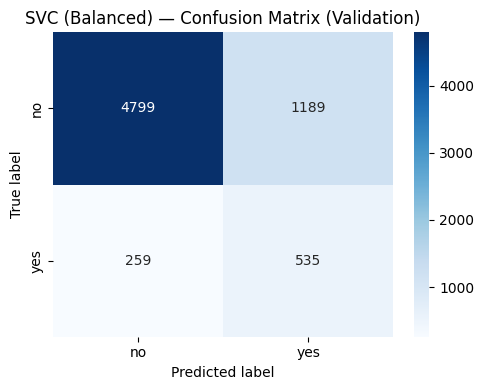

In [66]:
# [C2] SVC (Balanced) — Display Confusion Matrix (Validation)

# Retrieve cached probabilities and locked threshold
probs = globals().get("probs_val_svc_bal")
thresh = globals().get("THRESH_SVC_BAL")
y_val_bin = np.array(y_val, dtype=int)
y_pred = (probs >= thresh).astype(int)

# Plot confusion matrix
cm = confusion_matrix(y_val_bin, y_pred)
labels = ["no", "yes"]

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("SVC (Balanced) — Confusion Matrix (Validation)")
plt.tight_layout()
plt.show()

In [67]:
# === [C2] SVC (Balanced) Quick Comparison Table (Unweighted vs Balanced, etc.) ===

# Example model tags for unweighted/balanced variants:
probs_a = globals().get("probs_val_svc_unw")    
probs_b = globals().get("probs_val_svc_bal")   
y_val_bin = np.array(y_val, dtype=int)
t_a = globals().get("THRESH_SVC_UNW")
t_b = globals().get("THRESH_SVC_BAL")

def eval_at(probs, thresh):
    y_pred = (probs >= thresh).astype(int)
    return {
        "threshold": float(thresh),
        "recall":    recall_score(y_val_bin, y_pred, zero_division=0),
        "precision": precision_score(y_val_bin, y_pred, zero_division=0),
        "f1":        f1_score(y_val_bin, y_pred, zero_division=0),
        "accuracy":  accuracy_score(y_val_bin, y_pred),
        "pred_pos_rate": float(y_pred.mean())
    }

print("probs_a is None:", probs_a is None)
print("t_a is None:", t_a is None)
print("probs_b is None:", probs_b is None)
print("t_b is None:", t_b is None)

rows = [
    {"model": "SVC (unweighted)", **eval_at(probs_a, t_a)},
    {"model": "SVC (balanced)",   **eval_at(probs_b, t_b)},
]
df_cmp = pd.DataFrame(rows, columns=["model","threshold","recall","precision","f1","accuracy","pred_pos_rate"]).round(3)
display(df_cmp)

probs_a is None: False
t_a is None: False
probs_b is None: False
t_b is None: False


,model,threshold,recall,precision,f1,accuracy,pred_pos_rate
0,SVC (unweighted),0.11,0.674,0.31,0.425,0.786,0.254
1,SVC (balanced),0.11,0.674,0.31,0.425,0.786,0.254


---
#### **[A1] XGBoost (Unweighted) Fit + Cache VAL Probabilities (Cell A1)**
- Fit XGBoost on training data, cache validation probabilities for threshold tuning.
- Use default hyperparameters for baseline.
- Evaluate initial performance on validation set.
- Plot confusion matrix.
- Document results.


In [68]:
# [A1] XGBoost: (Baseline, Unweighted) — Cell A1
# Fit + cache VAL probabilities for upcoming threshold sweeps
# Uses: X_train_ready, y_train, X_val_ready, y_val

# Safety checks
assert 'X_train_ready' in globals() and 'X_val_ready' in globals(), "Run preprocessing/split first."
assert X_train_ready.shape[0] == len(y_train) and X_val_ready.shape[0] == len(y_val), "Shape mismatch."

# Model identity
MODEL_NAME = "XGBoost (unweighted)"
MODEL_TAG  = "xgb_unw"

xgb_unw = XGBClassifier(
    eval_metric='logloss',
    random_state=42
)
xgb_unw.fit(X_train_ready, y_train)
probs_val_xgb_unw = xgb_unw.predict_proba(X_val_ready)[:, 1]
globals()[f"probs_val_{MODEL_TAG}"] = probs_val_xgb_unw
globals()[f"model_{MODEL_TAG}"] = xgb_unw
print(f"[OK] {MODEL_NAME} fitted — cached as probs_val_{MODEL_TAG}")

[OK] XGBoost (unweighted) fitted — cached as probs_val_xgb_unw


#### **[B1] XGBoost (Unweighted): Sweep + Picks + Lock**
- Sweep thresholds on cached validation probabilities.
- Pick best threshold based on recall/precision trade-off.
- Lock in this model for comparison with future models.
- Document results.

In [69]:
# === [B1] XGBoost (Unweighted) — Threshold sweep & lock ===
# Set MODEL_TAG to match A1
MODEL_TAG = "xgb_unw"

probs = globals()[f"probs_val_{MODEL_TAG}"]
y_val_bin = np.array(y_val, dtype=int)

thresholds = np.round(np.arange(0.10, 0.51, 0.01), 2)
PRECISION_FLOOR = 0.30

rows = []
for t in thresholds:
    y_pred = (probs >= t).astype(int)
    rows.append([
        t,
        accuracy_score(y_val_bin, y_pred),
        recall_score(y_val_bin, y_pred, zero_division=0),
        precision_score(y_val_bin, y_pred, zero_division=0),
        f1_score(y_val_bin, y_pred, zero_division=0),
        float(y_pred.mean())
    ])
df = pd.DataFrame(rows, columns=["threshold","accuracy","recall","precision","f1","pred_pos_rate"])
display(df)

best_f1 = df.loc[df["f1"].idxmax()]
guard = df[df["precision"] >= PRECISION_FLOOR]
recall_first = guard.loc[guard["recall"].idxmax()] if not guard.empty else None
if recall_first is not None:
    globals()[f"THRESH_{MODEL_TAG.upper()}"] = float(recall_first.threshold)
    print(f"\n[LOCKED] THRESH_{MODEL_TAG.upper()} = {float(recall_first.threshold):.2f}")
else:
    globals()[f"THRESH_{MODEL_TAG.upper()}"] = float(best_f1.threshold)
    print(f"\n[LOCKED] THRESH_{MODEL_TAG.upper()} = {float(best_f1.threshold):.2f}")

,threshold,accuracy,recall,precision,f1,pred_pos_rate
0,0.10,0.763197,0.687657,0.286765,0.404744,0.280743
1,0.11,0.783545,0.658690,0.304070,0.416070,0.253613
2,0.12,0.802566,0.638539,0.325208,0.430939,0.229873
3,0.13,0.819670,0.623426,0.348837,0.447357,0.209230
4,0.14,0.832793,0.608312,0.369832,0.460000,0.192569
5,0.15,0.838396,0.584383,0.377236,0.458498,0.181362
6,0.16,0.844441,0.556675,0.386026,0.455905,0.168829
7,0.17,0.852551,0.547859,0.404275,0.465241,0.158655
8,0.18,0.857417,0.528967,0.414610,0.464859,0.149366
9,0.19,0.864199,0.517632,0.433087,0.471601,0.139929



[LOCKED] THRESH_XGB_UNW = 0.11


#### **[C1] XGBoost (Unweighted) Confusion Matrix (Validation) (Cell C1)**
- Confusion matrix for XGBoost (unweighted) on the validation set.
- Helps visualize true positives, false positives, true negatives, and false negatives.
- Useful for understanding model performance beyond just accuracy.
- Recall is a key metric here, especially for the minority class (`yes`).
- Helps identify if the model is missing too many actual `yes` cases (high FN).
- This matrix will guide threshold tuning and further model improvements.

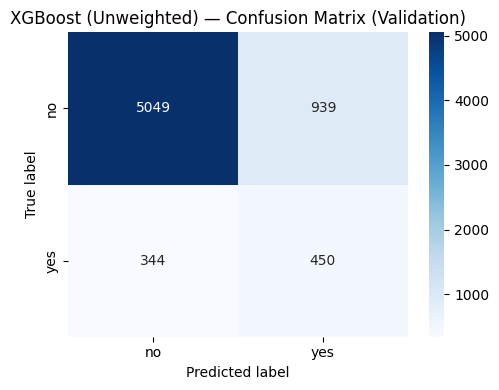

In [70]:
# [C1] XGBoost (Unweighted) — Display Confusion Matrix (Validation)

# Retrieve cached probabilities and locked threshold
probs = globals().get("probs_val_xgb_unw")
thresh = globals().get("THRESH_XGB_UNW")
y_val_bin = np.array(y_val, dtype=int)
y_pred = (probs >= thresh).astype(int)

# Plot confusion matrix
cm = confusion_matrix(y_val_bin, y_pred)
labels = ["no", "yes"]

# Plot confusion matrix
probs = globals().get("probs_val_lr_unw")
thresh = globals().get("THRESH_LR_UNW")
y_val_bin = np.array(y_val, dtype=int)
y_pred = (probs >= thresh).astype(int)

# Plot confusion matrix
cm = confusion_matrix(y_val_bin, y_pred)
labels = ["no", "yes"]

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("XGBoost (Unweighted) — Confusion Matrix (Validation)")
plt.tight_layout()
plt.show()

#### **[A2] XGBoost (Balanced) Fit + Cache VAL Probabilities (Cell A2)**
- Repeat the above process but with class weights to address imbalance.
- Use `scale_pos_weight` parameter when instantiating the XGBoost model.
- Evaluate and compare performance to the unweighted version.
- Plot confusion matrix.
- Document results.

In [71]:
# === [A2] XGBoost (Balanced) — Fit + cache VAL probabilities ===

# 1. Model identity
MODEL_NAME = "XGBoost (balanced)"        
MODEL_TAG  = "xgb_bal"        

# 2. construct model
# Calculate class ratio on your TRAIN set
n_negative = (np.array(y_train) == 0).sum()
n_positive = (np.array(y_train) == 1).sum()
ratio = n_negative / n_positive
print(f"scale_pos_weight for XGBoost (balanced): {ratio:.2f}")

model = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=ratio
)

# 3. Safety checks
assert 'X_train_ready' in globals() and 'X_val_ready' in globals(), "Preprocessing/split missing."
assert X_train_ready.shape[0] == len(y_train) and X_val_ready.shape[0] == len(y_val), "Shape mismatch."

# 4. Fit model
model.fit(X_train_ready, y_train)

# 5. Cache validation probabilities (probs_val_<MODEL_TAG>)
probs_val = model.predict_proba(X_val_ready)[:, 1]
globals()[f"probs_val_{MODEL_TAG}"] = probs_val
globals()[f"model_{MODEL_TAG}"] = model
print(f"[OK] {MODEL_NAME} fitted — cached as probs_val_{MODEL_TAG}")


scale_pos_weight for XGBoost (balanced): 7.55
[OK] XGBoost (balanced) fitted — cached as probs_val_xgb_bal


#### **[B2] XGBoost (Balanced) - Threshold Sweep/Lock Best Threshold**
- Sweep thresholds on cached validation probabilities.
- Pick best threshold based on recall/precision trade-off.
- Lock in this model for comparison with future models.
- Document results.

In [72]:
# === [B2] XGBoost (Balanced) — Threshold sweep & lock ===
# Set MODEL_TAG to match A1
MODEL_TAG = "xgb_bal"

probs = globals()[f"probs_val_{MODEL_TAG}"]
y_val_bin = np.array(y_val, dtype=int)

thresholds = np.round(np.arange(0.10, 0.51, 0.01), 2)
PRECISION_FLOOR = 0.30

rows = []
for t in thresholds:
    y_pred = (probs >= t).astype(int)
    rows.append([
        t,
        accuracy_score(y_val_bin, y_pred),
        recall_score(y_val_bin, y_pred, zero_division=0),
        precision_score(y_val_bin, y_pred, zero_division=0),
        f1_score(y_val_bin, y_pred, zero_division=0),
        float(y_pred.mean())
    ])
df = pd.DataFrame(rows, columns=["threshold","accuracy","recall","precision","f1","pred_pos_rate"])
display(df)

best_f1 = df.loc[df["f1"].idxmax()]
guard = df[df["precision"] >= PRECISION_FLOOR]
recall_first = guard.loc[guard["recall"].idxmax()] if not guard.empty else None
if recall_first is not None:
    globals()[f"THRESH_{MODEL_TAG.upper()}"] = float(recall_first.threshold)
    print(f"\n[LOCKED] THRESH_{MODEL_TAG.upper()} = {float(recall_first.threshold):.2f}")
else:
    globals()[f"THRESH_{MODEL_TAG.upper()}"] = float(best_f1.threshold)
    print(f"\n[LOCKED] THRESH_{MODEL_TAG.upper()} = {float(best_f1.threshold):.2f}")

,threshold,accuracy,recall,precision,f1,pred_pos_rate
0,0.10,0.277057,0.952141,0.134496,0.235698,0.828812
1,0.11,0.297847,0.942065,0.136896,0.239054,0.805662
2,0.12,0.317605,0.933249,0.139391,0.242553,0.783840
3,0.13,0.340902,0.926952,0.142968,0.247728,0.759068
4,0.14,0.358301,0.914358,0.144910,0.250172,0.738720
5,0.15,0.377765,0.911839,0.148543,0.255469,0.718667
6,0.16,0.399440,0.905542,0.152427,0.260933,0.695518
7,0.17,0.418313,0.899244,0.155929,0.265773,0.675170
8,0.18,0.440725,0.887909,0.159900,0.270998,0.650103
9,0.19,0.456650,0.869018,0.161555,0.272458,0.629755



[LOCKED] THRESH_XGB_BAL = 0.45


#### **[C2] XGBoost (Balanced) — Display Confusion Matrix (Validation)**
- Confusion matrix for XGBoost (balanced) on the validation set.
- Helps visualize how balancing class weights affects true/false positives and negatives.
- Expect more true positives (TP) and fewer false negatives (FN) compared to the unweighted version.
- This matrix will guide threshold tuning and further model improvements.
- Recall is a key metric here, especially for the minority class (`yes`).
- Helps identify if the model is missing too many actual `yes` cases (high FN).
- This matrix will guide threshold tuning and further model improvements.

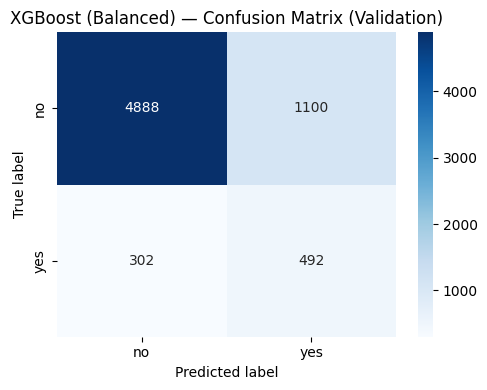

In [73]:
# [C2] XGBoost (Balanced) — Display Confusion Matrix (Validation)

# Retrieve cached probabilities and locked threshold
probs = globals().get("probs_val_xgb_bal")
thresh = globals().get("THRESH_XGB_BAL")
y_val_bin = np.array(y_val, dtype=int)
y_pred = (probs >= thresh).astype(int)

# Plot confusion matrix
cm = confusion_matrix(y_val_bin, y_pred)
labels = ["no", "yes"]

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("XGBoost (Balanced) — Confusion Matrix (Validation)")
plt.tight_layout()
plt.show()

#### **[D1] XGBoost (Unweighted) vs XGBoost (Balanced) — Quick Comparison Table**
- Create a summary table comparing key metrics (accuracy, precision, recall, F1) for unweighted vs balanced XGBoost models.
- Include confusion matrices for both models to visualize differences in TP, FP, TN, FN counts.
- Document insights and next steps based on the comparison.
- Helps quickly see the impact of class weighting on performance.

In [74]:
# === [D1] XGBoost Quick Comparison Table (Unweighted vs Balanced, etc.) ===

# Example model tags for unweighted/balanced variants:
probs_a = globals().get("probs_val_xgb_unw")    # or whatever your tag is
probs_b = globals().get("probs_val_xgb_bal")    # or whatever your tag is
y_val_bin = np.array(y_val, dtype=int)
t_a = globals().get("THRESH_XGB_UNW")
t_b = globals().get("THRESH_XGB_BAL")

def eval_at(probs, thresh):
    y_pred = (probs >= thresh).astype(int)
    return {
        "threshold": float(thresh),
        "recall":    recall_score(y_val_bin, y_pred, zero_division=0),
        "precision": precision_score(y_val_bin, y_pred, zero_division=0),
        "f1":        f1_score(y_val_bin, y_pred, zero_division=0),
        "accuracy":  accuracy_score(y_val_bin, y_pred),
        "pred_pos_rate": float(y_pred.mean())
    }

print("probs_a is None:", probs_a is None)
print("t_a is None:", t_a is None)
print("probs_b is None:", probs_b is None)
print("t_b is None:", t_b is None)

rows = [
    {"model": "XGBoost (unweighted)", **eval_at(probs_a, t_a)},
    {"model": "XGBoost (balanced)",   **eval_at(probs_b, t_b)},
]
df_cmp = pd.DataFrame(rows, columns=["model","threshold","recall","precision","f1","accuracy","pred_pos_rate"]).round(3)
display(df_cmp)

probs_a is None: False
t_a is None: False
probs_b is None: False
t_b is None: False


,model,threshold,recall,precision,f1,accuracy,pred_pos_rate
0,XGBoost (unweighted),0.11,0.659,0.304,0.416,0.784,0.254
1,XGBoost (balanced),0.45,0.620,0.309,0.412,0.793,0.235


----
#### **[A1] LightGBM (Unweighted) Fit + Cache VAL Probabilities**
- Fit LightGBM on training data, cache validation probabilities for threshold tuning.
- Use default parameters for baseline. 
- Consider using `scale_pos_weight` for class imbalance.
- Evaluate initial performance on validation set.
- Document results.

In [75]:
# === [A1] LightGBM (Unweighted) — Fit + cache VAL probabilities ===
# Example: MODEL_NAME = "XGBoost (unweighted)", MODEL_TAG = "xgb_unw"

# 1. Model identity
MODEL_NAME = "LightGBM (unweighted)"
MODEL_TAG  = "lgbm_unw"

# 2. Construct model
# (Replace with the right constructor and params for the model)
# For tree models, (XGBoost, LightGBM, CatBoost, Decision Tree Classifier, Random Forest, etc.), might add: ratio or scale_pos_weight=1 
model = LGBMClassifier(
    n_estimators=100,
    random_state=42,
    scale_pos_weight=1
    # add any model-specific args...
)

# 3. Safety checks
assert 'X_train_ready' in globals() and 'X_val_ready' in globals(), "Preprocessing/split missing."
assert X_train_ready.shape[0] == len(y_train) and X_val_ready.shape[0] == len(y_val), "Shape mismatch."

# 4. Fit model
model.fit(X_train_ready, y_train)

# 5. Cache validation probabilities (probs_val_<MODEL_TAG>)
probs_val = model.predict_proba(X_val_ready)[:, 1]
globals()[f"probs_val_{MODEL_TAG}"] = probs_val
globals()[f"model_{MODEL_TAG}"] = model
print(f"[OK] {MODEL_NAME} fitted — cached as probs_val_{MODEL_TAG}")

[LightGBM] [Info] Number of positive: 3702, number of negative: 27945
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 31647, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116978 -> initscore=-2.021365
[LightGBM] [Info] Start training from score -2.021365
[OK] LightGBM (unweighted) fitted — cached as probs_val_lgbm_unw


#### **[A1]Interpretation of LightGBM (Unweighted) Validation Results**
- scale_pos_weight=1 means it's not doing any special class balancing (unweighted baseline—which is good!).
- All those [LightGBM] [Info] lines are just status messages about the model, number of positives/negatives, threading, features, and training process.
- number of positive: 3702, number of negative: 27945 — the class imbalance is recognized!
- number of data points in the train set: 31647 — Matches expectations.
- Model fit, score initialized, training started—all normal LightGBM output.
- Final confirmation:
    - [OK] LightGBM (unweighted) fitted — cached as probs_val_lgbm_unw
- Overall: This means the probabilities were cached and it's ready to threshold sweep!

#### **[B1] LightGBM (Unweighted): Sweep + Picks + Lock**
- Sweep thresholds on cached validation probabilities.
- Pick best threshold based on recall/precision trade-off.
- Lock in this model for comparison with future models.
- Document results.

In [76]:
# === [B1] LightGBM — Threshold sweep & lock ===
# Set MODEL_TAG to match A1
MODEL_TAG = "lgbm_unw"

# Retrieve cached validation probabilities
probs = globals()[f"probs_val_{MODEL_TAG}"]
y_val_bin = np.array(y_val, dtype=int)

# Sweep thresholds from 0.10 to 0.50 in 0.01 increments
thresholds = np.round(np.arange(0.10, 0.51, 0.01), 2)
PRECISION_FLOOR = 0.30

# Collect metrics at each threshold
rows = []
for t in thresholds:
    y_pred = (probs >= t).astype(int)
    rows.append([
        t,
        accuracy_score(y_val_bin, y_pred),
        recall_score(y_val_bin, y_pred, zero_division=0),
        precision_score(y_val_bin, y_pred, zero_division=0),
        f1_score(y_val_bin, y_pred, zero_division=0),
        float(y_pred.mean())
    ])

# Create DataFrame and display results
df = pd.DataFrame(rows, columns=["threshold","accuracy","recall","precision","f1","pred_pos_rate"])
display(df)

# Lock best threshold based on criteria
best_f1 = df.loc[df["f1"].idxmax()]
guard = df[df["precision"] >= PRECISION_FLOOR]
recall_first = guard.loc[guard["recall"].idxmax()] if not guard.empty else None
if recall_first is not None:
    globals()[f"THRESH_{MODEL_TAG.upper()}"] = float(recall_first.threshold)
    print(f"\n[LOCKED] THRESH_{MODEL_TAG.upper()} = {float(recall_first.threshold):.2f}")
else:
    globals()[f"THRESH_{MODEL_TAG.upper()}"] = float(best_f1.threshold)
    print(f"\n[LOCKED] THRESH_{MODEL_TAG.upper()} = {float(best_f1.threshold):.2f}")


,threshold,accuracy,recall,precision,f1,pred_pos_rate
0,0.10,0.768357,0.705290,0.295203,0.416202,0.279711
1,0.11,0.792244,0.678841,0.318370,0.433454,0.249631
2,0.12,0.812887,0.653652,0.343027,0.449935,0.223091
3,0.13,0.827632,0.634761,0.364425,0.463023,0.203922
4,0.14,0.839723,0.610831,0.384006,0.471561,0.186228
5,0.15,0.848275,0.603275,0.401509,0.482134,0.175907
6,0.16,0.852993,0.593199,0.411354,0.485817,0.168829
7,0.17,0.859334,0.578086,0.425788,0.490385,0.158950
8,0.18,0.865231,0.568010,0.441292,0.496696,0.150693
9,0.19,0.869065,0.560453,0.452236,0.500562,0.145090



[LOCKED] THRESH_LGBM_UNW = 0.11


#### **[C1] LightGBM (Unweighted) — Display Confusion Matrix (Validation)**
- Confusion matrix for LightGBM (unweighted) on the validation set.
- Helps visualize true positives, false positives, true negatives, and false negatives.
- Useful for understanding model performance beyond just accuracy.
- Recall is a key metric here, especially for the minority class (`yes`).
- Helps identify if the model is missing too many actual `yes` cases (high FN).
- This matrix will guide threshold tuning and further model improvements.
- Document results.

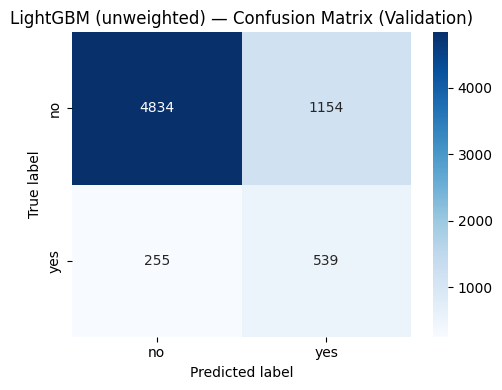

In [77]:
# [C1] LightGBM — Display Confusion Matrix (Validation)

# Retrieve cached probabilities and locked threshold
probs = globals().get("probs_val_lgbm_unw")
thresh = globals().get("THRESH_LGBM_UNW")
y_val_bin = np.array(y_val, dtype=int)
y_pred = (probs >= thresh).astype(int)

# Plot confusion matrix
cm = confusion_matrix(y_val_bin, y_pred)
labels = ["no", "yes"]

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("LightGBM (unweighted) — Confusion Matrix (Validation)")
plt.tight_layout()
plt.show()

#### **[A2] LightGBM (balanced) — Fit + cache VAL probabilities**
- Repeat the above process but with class weights to address imbalance. 
- Use `scale_pos_weight` parameter when instantiating the LightGBM model.
- Evaluate and compare performance of balanced to unweighted version.
- Document results.

In [78]:
# === [A2] LightGBM (balanced) — Fit + cache VAL probabilities ===
# Example: MODEL_NAME = "LightGBM (balanced)", MODEL_TAG = "lgbm_bal"

# 1. Model identity
MODEL_NAME = "LightGBM (balanced)"        
MODEL_TAG  = "lgbm_bal"        

# Calculate class ratio on the TRAIN set
n_negative = (np.array(y_train) == 0).sum()
n_positive = (np.array(y_train) == 1).sum()
ratio = n_negative / n_positive
print(f"scale_pos_weight for LightGBM (balanced): {ratio:.2f}")

# 2. Construct model
# (Replace with the right constructor and params for the model)
model = LGBMClassifier(
    n_estimators=100,
    random_state=42,
    scale_pos_weight=ratio,
    verbose=-1 # suppress warnings
)

# 3. Safety checks
assert 'X_train_ready' in globals() and 'X_val_ready' in globals(), "Preprocessing/split missing."
assert X_train_ready.shape[0] == len(y_train) and X_val_ready.shape[0] == len(y_val), "Shape mismatch."

# 4. Fit model
model.fit(X_train_ready, y_train)

# 5. Cache validation probabilities (probs_val_<MODEL_TAG>)
probs_val = model.predict_proba(X_val_ready)[:, 1]
globals()[f"probs_val_{MODEL_TAG}"] = probs_val
globals()[f"model_{MODEL_TAG}"] = model
print(f"[OK] {MODEL_NAME} fitted — cached as probs_val_{MODEL_TAG}")

scale_pos_weight for LightGBM (balanced): 7.55
[OK] LightGBM (balanced) fitted — cached as probs_val_lgbm_bal


#### **LightGBM (Balanced) — Interpretation of Validation Results**
- scale_pos_weight for LightGBM (balanced): 7.55
    - correctly calculated and applied the ratio of negatives to positives in your train set (27,945 / 3,702 ≈ 7.55).
    - This helps LightGBM focus on the rare positive class (recall).
- LightGBM [Info] lines:
    - Data was recognized (3,702 positives, 27,945 negatives—matches the expected class imbalance).
    - Multi-threading and features loaded fine.
    - Training started from the correct initial score.
    - No errors, just progress info.
- Final message:
    - [OK] LightGBM (balanced) fitted — cached as probs_val_lgbm_bal
- Model fit and probability caching worked!

#### **[B2] LightGBM (Balanced) Threshold Sweep + Pick + Lock**


In [79]:
# === [B1] LightGBM (balanced) — Threshold sweep & lock ===
# Set MODEL_TAG to match A1
MODEL_TAG = "lgbm_bal"

probs = globals()[f"probs_val_{MODEL_TAG}"]
y_val_bin = np.array(y_val, dtype=int)

thresholds = np.round(np.arange(0.10, 0.51, 0.01), 2)
PRECISION_FLOOR = 0.30

rows = []
for t in thresholds:
    y_pred = (probs >= t).astype(int)
    rows.append([
        t,
        accuracy_score(y_val_bin, y_pred),
        recall_score(y_val_bin, y_pred, zero_division=0),
        precision_score(y_val_bin, y_pred, zero_division=0),
        f1_score(y_val_bin, y_pred, zero_division=0),
        float(y_pred.mean())
    ])
df = pd.DataFrame(rows, columns=["threshold","accuracy","recall","precision","f1","pred_pos_rate"])
display(df)

best_f1 = df.loc[df["f1"].idxmax()]
guard = df[df["precision"] >= PRECISION_FLOOR]
recall_first = guard.loc[guard["recall"].idxmax()] if not guard.empty else None
if recall_first is not None:
    globals()[f"THRESH_{MODEL_TAG.upper()}"] = float(recall_first.threshold)
    print(f"\n[LOCKED] THRESH_{MODEL_TAG.upper()} = {float(recall_first.threshold):.2f}")
else:
    globals()[f"THRESH_{MODEL_TAG.upper()}"] = float(best_f1.threshold)
    print(f"\n[LOCKED] THRESH_{MODEL_TAG.upper()} = {float(best_f1.threshold):.2f}")

,threshold,accuracy,recall,precision,f1,pred_pos_rate
0,0.10,0.170451,0.991184,0.122854,0.218611,0.944559
1,0.11,0.182100,0.987406,0.124031,0.220379,0.932026
2,0.12,0.195223,0.983627,0.125442,0.222507,0.918018
3,0.13,0.212917,0.977330,0.127297,0.225254,0.898850
4,0.14,0.230758,0.967254,0.128881,0.227454,0.878649
5,0.15,0.251401,0.962217,0.131475,0.231340,0.856827
6,0.16,0.273666,0.954660,0.134207,0.235331,0.832793
7,0.17,0.297110,0.948363,0.137434,0.240077,0.807874
8,0.18,0.318785,0.939547,0.140278,0.244110,0.784134
9,0.19,0.341787,0.935768,0.144104,0.249748,0.760248



[LOCKED] THRESH_LGBM_BAL = 0.45


#### **[C2] LightGBM (Balanced) Confusion Matrix (Validation)**

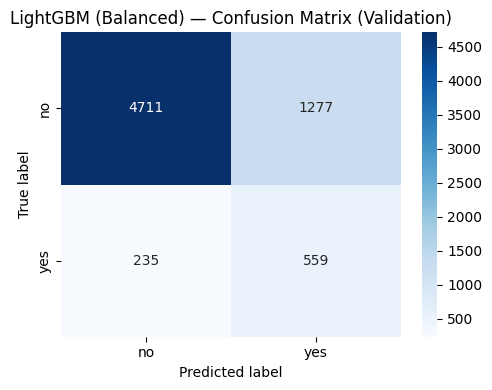

In [80]:
# [C2] LightGBM (Balanced) — Display Confusion Matrix (Validation)

# Retrieve cached probabilities and locked threshold
probs = globals().get("probs_val_lgbm_bal")
thresh = globals().get("THRESH_LGBM_BAL")
y_val_bin = np.array(y_val, dtype=int)
y_pred = (probs >= thresh).astype(int)

# Plot confusion matrix
cm = confusion_matrix(y_val_bin, y_pred)
labels = ["no", "yes"]

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("LightGBM (Balanced) — Confusion Matrix (Validation)")
plt.tight_layout()
plt.show()

#### **[D1] LightGBM Quick Comparison Table (Unweighted vs Balanced)**


In [81]:
# === [C1] LightGBM Quick Comparison Table (Unweighted vs Balanced, etc.) ===

# Example model tags for unweighted/balanced variants:
probs_a = globals().get("probs_val_lgbm_unw")    # or whatever your tag is
probs_b = globals().get("probs_val_lgbm_bal")    # or whatever your tag is
y_val_bin = np.array(y_val, dtype=int)
t_a = globals().get("THRESH_LGBM_UNW")
t_b = globals().get("THRESH_LGBM_BAL")

# Evaluation function at a given threshold
def eval_at(probs, thresh):
    y_pred = (probs >= thresh).astype(int)
    return {
        "threshold": float(thresh),
        "recall":    recall_score(y_val_bin, y_pred, zero_division=0),
        "precision": precision_score(y_val_bin, y_pred, zero_division=0),
        "f1":        f1_score(y_val_bin, y_pred, zero_division=0),
        "accuracy":  accuracy_score(y_val_bin, y_pred),
        "pred_pos_rate": float(y_pred.mean())
    }

# Debug prints to check for None values
print("probs_a is None:", probs_a is None)
print("t_a is None:", t_a is None)
print("probs_b is None:", probs_b is None)
print("t_b is None:", t_b is None)

# Compile comparison table
rows = [
    {"model": "LightGBM (unweighted)", **eval_at(probs_a, t_a)},
    {"model": "LightGBM (balanced)",   **eval_at(probs_b, t_b)},
]

# Display comparison table
df_cmp = pd.DataFrame(rows, columns=["model","threshold","recall","precision","f1","accuracy","pred_pos_rate"]).round(3)
display(df_cmp)


probs_a is None: False
t_a is None: False
probs_b is None: False
t_b is None: False


,model,threshold,recall,precision,f1,accuracy,pred_pos_rate
0,LightGBM (unweighted),0.11,0.679,0.318,0.433,0.792,0.250
1,LightGBM (balanced),0.45,0.704,0.304,0.425,0.777,0.271


---
#### **[A1] CatBoost (Unweighted) Fit + Cache VAL Probabilities**


In [82]:
# === [A1] CatBoost — Fit + cache VAL probabilities ===
# Example: MODEL_NAME = "CatBoost (unweighted)", MODEL_TAG = "cat_unw"

# 1. Model identity
MODEL_NAME = "CatBoost (unweighted)"        
MODEL_TAG  = "cat_unw"        

# 2. Construct model
# (Replace with the right constructor and params for your model)
model = CatBoostClassifier(
    n_estimators=100,
    random_state=42,
    verbose=0
    # add any model-specific args...
)
# For tree models, you might add: scale_pos_weight=1 or ratio

# 3. Safety checks
assert 'X_train_ready' in globals() and 'X_val_ready' in globals(), "Preprocessing/split missing."
assert X_train_ready.shape[0] == len(y_train) and X_val_ready.shape[0] == len(y_val), "Shape mismatch."

# 4. Fit model
model.fit(X_train_ready, y_train)

# 5. Cache validation probabilities (probs_val_<MODEL_TAG>)
probs_val = model.predict_proba(X_val_ready)[:, 1]
globals()[f"probs_val_{MODEL_TAG}"] = probs_val
globals()[f"model_{MODEL_TAG}"] = model
print(f"[OK] {MODEL_NAME} fitted — cached as probs_val_{MODEL_TAG}")


[OK] CatBoost (unweighted) fitted — cached as probs_val_cat_unw


In [83]:
# === [B1] CatBoost — Threshold sweep & lock ===
# Set MODEL_TAG to match A1
MODEL_TAG = "cat_unw"

# Get cached probs and true y_val
probs = globals()[f"probs_val_{MODEL_TAG}"]
y_val_bin = np.array(y_val, dtype=int)

# Sweep thresholds from 0.10 to 0.50 in 0.01 increments
thresholds = np.round(np.arange(0.10, 0.51, 0.01), 2)
PRECISION_FLOOR = 0.30

# Collect metrics at each threshold
rows = []
for t in thresholds:
    y_pred = (probs >= t).astype(int)
    rows.append([
        t,
        accuracy_score(y_val_bin, y_pred),
        recall_score(y_val_bin, y_pred, zero_division=0),
        precision_score(y_val_bin, y_pred, zero_division=0),
        f1_score(y_val_bin, y_pred, zero_division=0),
        float(y_pred.mean())
    ])

# Display results in a DataFrame (rounded for readability
df = pd.DataFrame(rows, columns=["threshold","accuracy","recall","precision","f1","pred_pos_rate"])
display(df)

# Lock in the best threshold based on criteria
best_f1 = df.loc[df["f1"].idxmax()]
guard = df[df["precision"] >= PRECISION_FLOOR]
recall_first = guard.loc[guard["recall"].idxmax()] if not guard.empty else None
if recall_first is not None:
    globals()[f"THRESH_{MODEL_TAG.upper()}"] = float(recall_first.threshold)
    print(f"\n[LOCKED] THRESH_{MODEL_TAG.upper()} = {float(recall_first.threshold):.2f}")
else:
    globals()[f"THRESH_{MODEL_TAG.upper()}"] = float(best_f1.threshold)
    print(f"\n[LOCKED] THRESH_{MODEL_TAG.upper()} = {float(best_f1.threshold):.2f}")

,threshold,accuracy,recall,precision,f1,pred_pos_rate
0,0.10,0.769684,0.700252,0.295745,0.415856,0.277204
1,0.11,0.795488,0.675063,0.321922,0.435950,0.245503
2,0.12,0.816131,0.646096,0.346856,0.451386,0.218077
3,0.13,0.828369,0.629723,0.364964,0.462107,0.202005
4,0.14,0.837659,0.609572,0.379608,0.467859,0.187998
5,0.15,0.847095,0.596977,0.397985,0.477582,0.175612
6,0.16,0.854910,0.581864,0.414722,0.484277,0.164258
7,0.17,0.859481,0.557935,0.423923,0.481784,0.154084
8,0.18,0.863904,0.544081,0.435045,0.483492,0.146417
9,0.19,0.867886,0.525189,0.445513,0.482081,0.138012



[LOCKED] THRESH_CAT_UNW = 0.11


#### **[C1] CatBoost (Unweighted) — Display Confusion Matrix (Validation)**
- Confusion matrix for CatBoost (unweighted) on the validation set.
- Helps visualize true positives, false positives, true negatives, and false negatives.
- Useful for understanding model performance beyond just accuracy.
- Recall is a key metric here, especially for the minority class (`yes`).
- Helps identify if the model is missing too many actual `yes` cases (high FN).
- This matrix will guide threshold tuning and further model improvements.
- Document results.

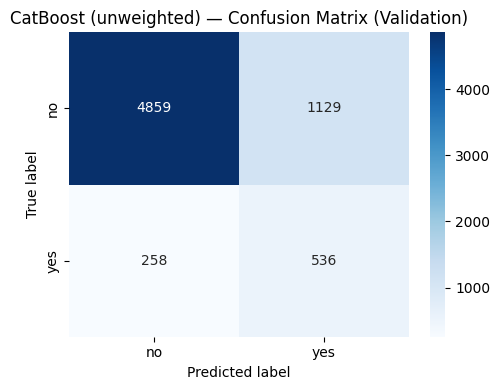

In [84]:
# [C1] CatBoost (unweighted) Display Confusion Matrix (Validation)

# Retrieve cached probabilities and locked threshold
probs = globals().get("probs_val_cat_unw")
thresh = globals().get("THRESH_CAT_UNW")
y_val_bin = np.array(y_val, dtype=int)
y_pred = (probs >= thresh).astype(int)

# Plot confusion matrix
cm = confusion_matrix(y_val_bin, y_pred)
labels = ["no", "yes"]

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("CatBoost (unweighted) — Confusion Matrix (Validation)")
plt.tight_layout()
plt.show()

#### **[A2] CatBoost (Balanced) Fit + Cache VAL Probabilities**
- Repeat the above process but with class weights to address imbalance.
- Use `scale_pos_weight` parameter when instantiating the CatBoost model.
- Evaluate and compare performance to the unweighted version.


In [85]:
# === [A2] CatBoost (Balanced) — Fit + cache VAL probabilities ===
# Example: MODEL_NAME = "CatBoost (balanced)", MODEL_TAG = "cat_bal"

# 1. Model identity
MODEL_NAME = "CatBoost (balanced)"        
MODEL_TAG  = "cat_bal"        

# Calculate weights for each class based on training set
n_negative = (np.array(y_train) == 0).sum()
n_positive = (np.array(y_train) == 1).sum()
weight_0 = 1.0
weight_1 = n_negative / n_positive

# 2. Construct model
model = CatBoostClassifier(
    n_estimators=100,
    random_state=42,
    class_weights=[weight_0, weight_1],  # 0 for "no", 1 for "yes"
    verbose=0
)

# 3. Safety checks
assert 'X_train_ready' in globals() and 'X_val_ready' in globals(), "Preprocessing/split missing."
assert X_train_ready.shape[0] == len(y_train) and X_val_ready.shape[0] == len(y_val), "Shape mismatch."

# 4. Fit model
model.fit(X_train_ready, y_train)

# 5. Cache validation probabilities (probs_val_<MODEL_TAG>)
probs_val = model.predict_proba(X_val_ready)[:, 1]
globals()[f"probs_val_{MODEL_TAG}"] = probs_val
globals()[f"model_{MODEL_TAG}"] = model
print(f"[OK] {MODEL_NAME} fitted — cached as probs_val_{MODEL_TAG}")

[OK] CatBoost (balanced) fitted — cached as probs_val_cat_bal


#### **[B2] CatBoost (Balanced) Threshold Sweep + Pick + Lock**
- Sweep thresholds on cached validation probabilities.
- Pick best threshold based on recall/precision trade-off.
- Lock in this model for comparison with future models.
- Document results.

In [86]:
# === [B1]  — Threshold sweep & lock ===
# Set MODEL_TAG  to match A1
MODEL_TAG = "cat_bal"

probs = globals()[f"probs_val_{MODEL_TAG}"]
y_val_bin = np.array(y_val, dtype=int)

thresholds = np.round(np.arange(0.10, 0.51, 0.01), 2)
PRECISION_FLOOR = 0.30

rows = []
for t in thresholds:
    y_pred = (probs >= t).astype(int)
    rows.append([
        t,
        accuracy_score(y_val_bin, y_pred),
        recall_score(y_val_bin, y_pred, zero_division=0),
        precision_score(y_val_bin, y_pred, zero_division=0),
        f1_score(y_val_bin, y_pred, zero_division=0),
        float(y_pred.mean())
    ])
df = pd.DataFrame(rows, columns=["threshold","accuracy","recall","precision","f1","pred_pos_rate"])
display(df)

best_f1 = df.loc[df["f1"].idxmax()]
guard = df[df["precision"] >= PRECISION_FLOOR]
recall_first = guard.loc[guard["recall"].idxmax()] if not guard.empty else None
if recall_first is not None:
    globals()[f"THRESH_{MODEL_TAG.upper()}"] = float(recall_first.threshold)
    print(f"\n[LOCKED] THRESH_{MODEL_TAG.upper()} = {float(recall_first.threshold):.2f}")
else:
    globals()[f"THRESH_{MODEL_TAG.upper()}"] = float(best_f1.threshold)
    print(f"\n[LOCKED] THRESH_{MODEL_TAG.upper()} = {float(best_f1.threshold):.2f}")

,threshold,accuracy,recall,precision,f1,pred_pos_rate
0,0.10,0.242406,0.954660,0.129352,0.227833,0.864052
1,0.11,0.258773,0.950882,0.131464,0.230993,0.846800
2,0.12,0.276467,0.947103,0.133879,0.234597,0.828222
3,0.13,0.295046,0.942065,0.136422,0.238330,0.808464
4,0.14,0.311118,0.937028,0.138651,0.241558,0.791212
5,0.15,0.330139,0.928212,0.141107,0.244973,0.770127
6,0.16,0.350929,0.918136,0.143901,0.248805,0.746977
7,0.17,0.369213,0.908060,0.146366,0.252098,0.726334
8,0.18,0.388971,0.897985,0.149288,0.256014,0.704217
9,0.19,0.408876,0.889169,0.152583,0.260469,0.682247



[LOCKED] THRESH_CAT_BAL = 0.47


#### **CatBoost (Balanced) Confusion Matrix (Validation)**
- Confusion matrix for CatBoost (balanced) on the validation set.
- Helps visualize how balancing class weights affects true/false positives and negatives.
- Expect more true positives (TP) and fewer false negatives (FN) compared to the unweighted version.
- This matrix will guide threshold tuning and further model improvements.
- Recall is a key metric here, especially for the minority class (`yes`).
- Helps identify if the model is missing too many actual `yes` cases (high FN).
- This matrix will guide threshold tuning and further model improvements.


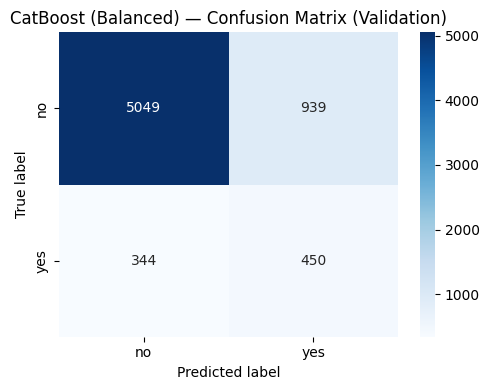

In [87]:
# Display Confusion Matrix (Validation)

# Retrieve cached probabilities and locked threshold
probs = globals().get("probs_val_lr_unw")
thresh = globals().get("THRESH_LR_UNW")
y_val_bin = np.array(y_val, dtype=int)
y_pred = (probs >= thresh).astype(int)

# Plot confusion matrix
cm = confusion_matrix(y_val_bin, y_pred)
labels = ["no", "yes"]

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("CatBoost (Balanced) — Confusion Matrix (Validation)")
plt.tight_layout()
plt.show()

#### **CatBoost Quick Comparison Table (Unweighted vs Balanced)**
- Create a summary table comparing key metrics (accuracy, precision, recall, F1) for unweighted vs balanced CatBoost models.
- Include confusion matrices for both models to visualize differences in TP, FP, TN, FN counts
- Document insights and next steps based on the comparison.
- Helps quickly see the impact of class weighting on performance.

In [88]:
# === [C1] CatBoost Quick Comparison Table (Unweighted vs Balanced, etc.) ===

# model tags for unweighted/balanced variants:
probs_a = globals().get("probs_val_cat_unw")    # or whatever your tag is
probs_b = globals().get("probs_val_cat_bal")    # or whatever your tag is
y_val_bin = np.array(y_val, dtype=int)
t_a = globals().get("THRESH_CAT_UNW")
t_b = globals().get("THRESH_CAT_BAL")

# Evaluation function at a given threshold
def eval_at(probs, thresh):
    y_pred = (probs >= thresh).astype(int)
    return {
        "threshold": float(thresh),
        "recall":    recall_score(y_val_bin, y_pred, zero_division=0),
        "precision": precision_score(y_val_bin, y_pred, zero_division=0),
        "f1":        f1_score(y_val_bin, y_pred, zero_division=0),
        "accuracy":  accuracy_score(y_val_bin, y_pred),
        "pred_pos_rate": float(y_pred.mean())
    }

# Debug prints to check for None values
print("probs_a is None:", probs_a is None)
print("t_a is None:", t_a is None)
print("probs_b is None:", probs_b is None)
print("t_b is None:", t_b is None)

# Compile comparison table
rows = [
    {"model": "XGBoost (unweighted)", **eval_at(probs_a, t_a)},
    {"model": "XGBoost (balanced)",   **eval_at(probs_b, t_b)},
]

# Display comparison table
df_cmp = pd.DataFrame(rows, columns=["model","threshold","recall","precision","f1","accuracy","pred_pos_rate"]).round(3)
display(df_cmp)


probs_a is None: False
t_a is None: False
probs_b is None: False
t_b is None: False


,model,threshold,recall,precision,f1,accuracy,pred_pos_rate
0,XGBoost (unweighted),0.11,0.675,0.322,0.436,0.795,0.246
1,XGBoost (balanced),0.47,0.659,0.308,0.419,0.786,0.251


### **All Models — Validation Metrics and Top-3 Ranking by Recall**
- This table summarizes the main performance metrics (recall, precision, F1, accuracy, predicted positive rate, and threshold) for each model variant on the validation set. 
- The top 3 models by recall are highlighted below for hyperparameter tuning.


In [89]:
# === All Models Quick Comparison Table (Validation) ===

# List your models/tags here. Add/remove as needed!
models = [
    {"name": "Logistic Regression (unweighted)", "probs": "probs_val_lr_unw", "thresh": "THRESH_LR_UNW"},
    {"name": "Logistic Regression (balanced)",   "probs": "probs_val_lr_bal", "thresh": "THRESH_LR_BAL"},
    {"name": "Decision Tree (unweighted)",       "probs": "probs_val_dt_unw", "thresh": "THRESH_DT_UNW"},
    {"name": "Decision Tree (balanced)",         "probs": "probs_val_dt_bal", "thresh": "THRESH_DT_BAL"},
    {"name": "Random Forest (unweighted)",       "probs": "probs_val_rf_unw", "thresh": "THRESH_RF_UNW"},
    {"name": "Random Forest (balanced)",         "probs": "probs_val_rf_bal", "thresh": "THRESH_RF_BAL"},
    {"name": "SVC (unweighted)",                 "probs": "probs_val_svc_unw","thresh": "THRESH_SVC_UNW"},
    {"name": "SVC (balanced)",                   "probs": "probs_val_svc_bal","thresh": "THRESH_SVC_BAL"},
    {"name": "XGBoost (unweighted)",             "probs": "probs_val_xgb_unw","thresh": "THRESH_XGB_UNW"},
    {"name": "XGBoost (balanced)",               "probs": "probs_val_xgb_bal","thresh": "THRESH_XGB_BAL"},
    {"name": "LightGBM (unweighted)",            "probs": "probs_val_lgbm_unw","thresh": "THRESH_LGBM_UNW"},
    {"name": "LightGBM (balanced)",              "probs": "probs_val_lgbm_bal","thresh": "THRESH_LGBM_BAL"},
    {"name": "CatBoost (unweighted)",            "probs": "probs_val_cat_unw","thresh": "THRESH_CAT_UNW"},
    {"name": "CatBoost (balanced)",              "probs": "probs_val_cat_bal","thresh": "THRESH_CAT_BAL"},
]

y_val_bin = np.array(y_val, dtype=int)
rows = []

for m in models:
    probs = globals().get(m["probs"])
    thresh = globals().get(m["thresh"])
    if (probs is not None) and (thresh is not None):
        y_pred = (probs >= thresh).astype(int)
        rows.append({
            "Model": m["name"],
            "Threshold": float(thresh),
            "Recall": recall_score(y_val_bin, y_pred, zero_division=0),
            "Precision": precision_score(y_val_bin, y_pred, zero_division=0),
            "F1": f1_score(y_val_bin, y_pred, zero_division=0),
            "Accuracy": accuracy_score(y_val_bin, y_pred),
            "Pred_Pos_Rate": float(y_pred.mean())
        })

df_cmp_all = pd.DataFrame(rows)
df_cmp_all = df_cmp_all.sort_values(by="Recall", ascending=False).reset_index(drop=True)
display(df_cmp_all)

print("\nTop 3 models by Recall (before hyperparameter tuning):")
display(df_cmp_all.head(3))


,Model,Threshold,Recall,Precision,F1,Accuracy,Pred_Pos_Rate
0,LightGBM (balanced),0.45,0.704030,0.304466,0.425095,0.777057,0.270717
1,LightGBM (unweighted),0.11,0.678841,0.318370,0.433454,0.792244,0.249631
2,CatBoost (unweighted),0.11,0.675063,0.321922,0.435950,0.795488,0.245503
3,SVC (unweighted),0.11,0.673804,0.310325,0.424940,0.786494,0.254202
4,SVC (balanced),0.11,0.673804,0.310325,0.424940,0.786494,0.254202
5,Random Forest (unweighted),0.15,0.664987,0.310954,0.423756,0.788263,0.250369
6,Random Forest (balanced),0.14,0.663728,0.307110,0.419920,0.785314,0.253023
7,XGBoost (unweighted),0.11,0.658690,0.304070,0.416070,0.783545,0.253613
8,CatBoost (balanced),0.47,0.658690,0.307647,0.419407,0.786494,0.250664
9,Logistic Regression (balanced),0.50,0.627204,0.268753,0.376275,0.756561,0.273223



Top 3 models by Recall (before hyperparameter tuning):


,Model,Threshold,Recall,Precision,F1,Accuracy,Pred_Pos_Rate
0,LightGBM (balanced),0.45,0.704030,0.304466,0.425095,0.777057,0.270717
1,LightGBM (unweighted),0.11,0.678841,0.318370,0.433454,0.792244,0.249631
2,CatBoost (unweighted),0.11,0.675063,0.321922,0.435950,0.795488,0.245503


#### **Top 3 Models: Hyperparameter Tuning [LightGBM (balanced), LightGBM (unweighted), CatBoost (unweighted)]**
- These top 3 models by recall will be further optimized through hyperparameter tuning.

In [90]:
# === LightGBM Hyperparameter Tuning (balanced) ===

# Use scale_pos_weight for balanced, omit for unweighted
is_balanced = True  # Set to False for unweighted
n_negative = (np.array(y_train) == 0).sum()
n_positive = (np.array(y_train) == 1).sum()
ratio = n_negative / n_positive

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, -1],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [15, 31, 63],
    # add more as desired
}

lgbm = LGBMClassifier(
    random_state=42,
    scale_pos_weight=ratio if is_balanced else 1,
    verbose=-1
)

gs = GridSearchCV(
    lgbm, 
    param_grid, 
    scoring='recall',  # focus on recall!
    cv=3,              # or 5 if you have time
    n_jobs=-1,
    verbose=2
)

gs.fit(X_train_ready, y_train)

print("Best params:", gs.best_params_)
print("Best recall (CV):", gs.best_score_)

# Refit best model on train, evaluate on val set
best_lgbm = gs.best_estimator_
probs_val = best_lgbm.predict_proba(X_val_ready)[:, 1]

# Rerun threshold sweep next!


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'num_leaves': 15}
Best recall (CV): 0.6345218800648298


#### **LightGBM (Balanced, Tuned) Fit + cache VAL probabilities**

In [91]:
# === LightGBM — Fit + cache VAL probabilities ===
# MODEL_NAME = "LightGBM (balanced, tuned)", MODEL_TAG = "lgbm_bal_tuned"

# 1. Model identity
MODEL_NAME = "LightGBM (balanced, tuned)"
MODEL_TAG = "lgbm_bal_tuned"

# 2. Construct LightGBM model with best params from tuning
# Calculate class ratio on the TRAIN set
n_negative = (np.array(y_train) == 0).sum()
n_positive = (np.array(y_train) == 1).sum()
ratio = n_negative / n_positive

best_lgbm = LGBMClassifier(
    learning_rate=0.05,
    max_depth=5,
    n_estimators=200,
    num_leaves=15,
    random_state=42,
    scale_pos_weight=ratio,  
    verbose=-1
)

# 3. Safety checks
assert 'X_train_ready' in globals() and 'X_val_ready' in globals(), "Preprocessing/split missing."
assert X_train_ready.shape[0] == len(y_train) and X_val_ready.shape[0] == len(y_val), "Shape mismatch."

# 4. Fit model
model.fit(X_train_ready, y_train)

# 5. Cache validation probabilities (probs_val_<MODEL_TAG>)
probs_val = model.predict_proba(X_val_ready)[:, 1]
globals()[f"probs_val_{MODEL_TAG}"] = probs_val
globals()[f"model_{MODEL_TAG}"] = model
print(f"[OK] {MODEL_NAME} fitted — cached as probs_val_best_{MODEL_TAG}")

[OK] LightGBM (balanced, tuned) fitted — cached as probs_val_best_lgbm_bal_tuned


#### **LightGBM (Balanced, Tuned) - Threshold Sweep/Lock Best Threshold**
- Sweep thresholds on cached validation probabilities.
- Pick best threshold based on recall/precision trade-off.
- Lock in this model for final evaluation.
- Document results.

In [92]:
# === LightGBM (Balanced - Tuned) — Threshold sweep & lock ===
# Set MODEL_TAG to match A1
MODEL_TAG = "lgbm_bal_tuned"

# Use tuned model's validation probabilities!
probs = globals()[f"probs_val_{MODEL_TAG}"]  # (not the original baseline's)
y_val_bin = np.array(y_val, dtype=int)

thresholds = np.round(np.arange(0.10, 0.51, 0.01), 2)
PRECISION_FLOOR = 0.30

rows = []
for t in thresholds:
    y_pred = (probs >= t).astype(int)
    rows.append([
        t,
        accuracy_score(y_val_bin, y_pred),
        recall_score(y_val_bin, y_pred, zero_division=0),
        precision_score(y_val_bin, y_pred, zero_division=0),
        f1_score(y_val_bin, y_pred, zero_division=0),
        float(y_pred.mean())
    ])
df = pd.DataFrame(rows, columns=["threshold","accuracy","recall","precision","f1","pred_pos_rate"])
display(df)

best_f1 = df.loc[df["f1"].idxmax()]
guard = df[df["precision"] >= PRECISION_FLOOR]
recall_first = guard.loc[guard["recall"].idxmax()] if not guard.empty else None
if recall_first is not None:
    globals()[f"THRESH_{MODEL_TAG.upper()}"] = float(recall_first.threshold)
    print(f"\n[LOCKED] THRESH_{MODEL_TAG.upper()} = {float(recall_first.threshold):.2f}")
else:
    globals()[f"THRESH_{MODEL_TAG.upper()}"] = float(best_f1.threshold)
    print(f"\n[LOCKED] THRESH_{MODEL_TAG.upper()} = {float(best_f1.threshold):.2f}")


,threshold,accuracy,recall,precision,f1,pred_pos_rate
0,0.10,0.242406,0.954660,0.129352,0.227833,0.864052
1,0.11,0.258773,0.950882,0.131464,0.230993,0.846800
2,0.12,0.276467,0.947103,0.133879,0.234597,0.828222
3,0.13,0.295046,0.942065,0.136422,0.238330,0.808464
4,0.14,0.311118,0.937028,0.138651,0.241558,0.791212
5,0.15,0.330139,0.928212,0.141107,0.244973,0.770127
6,0.16,0.350929,0.918136,0.143901,0.248805,0.746977
7,0.17,0.369213,0.908060,0.146366,0.252098,0.726334
8,0.18,0.388971,0.897985,0.149288,0.256014,0.704217
9,0.19,0.408876,0.889169,0.152583,0.260469,0.682247



[LOCKED] THRESH_LGBM_BAL_TUNED = 0.47


#### **LightGBM (Balanced - Tuned) — Display Confusion Matrix (Validation)**
- Confusion matrix for the tuned LightGBM (balanced) on the validation set.

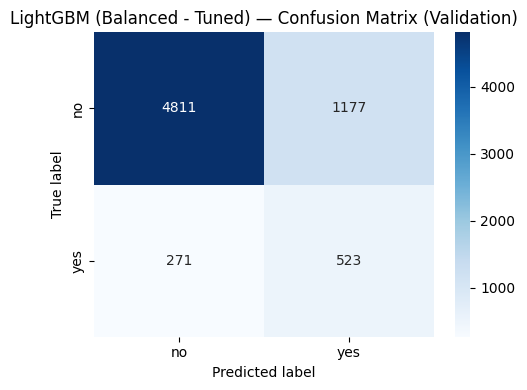

In [93]:
# LightGBM (Balanced - Tuned) — Display Confusion Matrix (Validation)

# Retrieve cached probabilities and locked threshold
probs = globals().get("probs_val_lgbm_bal_tuned")
thresh = globals().get("THRESH_LGBM_BAL_TUNED")
y_val_bin = np.array(y_val, dtype=int)
y_pred = (probs >= thresh).astype(int)

# Plot confusion matrix
cm = confusion_matrix(y_val_bin, y_pred)
labels = ["no", "yes"]

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("LightGBM (Balanced - Tuned) — Confusion Matrix (Validation)")
plt.tight_layout()
plt.show()

#### **LightGBM (Balanced, Tuned) — Final Metrics on Validation Set**
- After hyperparameter tuning and threshold locking, the final metrics for the balanced LightGBM model


In [94]:
# === LightGBM (Balanced - Tuned) — Final Metrics on Validation Set ===

acc = accuracy_score(y_val_bin, y_pred)
rec = recall_score(y_val_bin, y_pred, zero_division=0)
prec = precision_score(y_val_bin, y_pred, zero_division=0)
f1 = f1_score(y_val_bin, y_pred, zero_division=0)

print(f"Accuracy:  {acc:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"Precision: {prec:.3f}")
print(f"F1 Score:  {f1:.3f}")


Accuracy:  0.786
Recall:    0.659
Precision: 0.308
F1 Score:  0.419


#### **LightGBM ROC Curve (Balanced, Tuned)**
- The ROC curve for the tuned LightGBM (balanced) model on the validation set.
- The curve shows the trade-off between true positive rate (sensitivity) and false positive rate (1-specificity) at various threshold settings.
- The Area Under the Curve (AUC) is a single scalar value summarizing the model's ability to discriminate between the positive and negative classes.- A higher AUC indicates better overall performance.
- This curve helps visualize how well the model can distinguish between the two classes across all possible thresholds.- AUC is a useful metric for imbalanced datasets, as it is insensitive to class distribution.

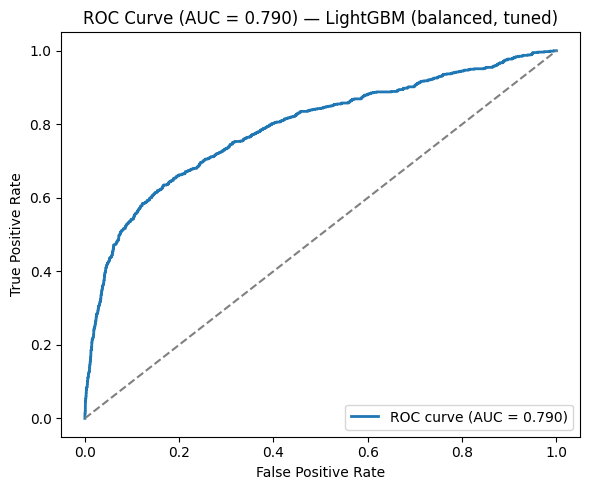

In [95]:
# === LightGBM (Balanced - Tuned) — ROC Curve & AUC ===

# For LightGBM (balanced, tuned)
# Use your model’s validation probabilities and y_val_bin
probs = globals().get("probs_val_lgbm_bal_tuned")
y_true = np.array(y_val, dtype=int)

# ROC Curve & AUC
fpr, tpr, thresholds = roc_curve(y_true, probs)
auc = roc_auc_score(y_true, probs)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})', lw=2)
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {auc:.3f}) — LightGBM (balanced, tuned)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


#### **LightGBM (Unweighted, Tuned) Hyperparameter Tuning**
- The LightGBM (unweighted) model will be further optimized through hyperparameter tuning.

In [96]:
# === LightGBM Hyperparameter Tuning (unweighted) ===

# Use scale_pos_weight for balanced, omit for unweighted
# is_balanced = True  # Set to False for unweighted
# n_negative = (np.array(y_train) == 0).sum()
# n_positive = (np.array(y_train) == 1).sum()
# ratio = n_negative / n_positive

# Define hyperparameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, -1],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [15, 31, 63],
    # add more as desired
}

# Initialize LightGBM model
lgbm = LGBMClassifier(
    random_state=42,
    scale_pos_weight=1,  # if is_balanced else 1,
    verbose=-1
)

# Setup GridSearchCV (focus on recall, 3-fold CV
gs = GridSearchCV(
    lgbm, 
    param_grid, 
    scoring='recall',  # focus on recall!
    cv=3,              # or 5 if you have time
    n_jobs=-1,
    verbose=2
)

# Fit on training data (X_train_ready, y_train
gs.fit(X_train_ready, y_train)

# Best params and score
print("Best params:", gs.best_params_)
print("Best recall (CV):", gs.best_score_)

# Refit best model on train, evaluate on val set
best_lgbm = gs.best_estimator_
probs_val = best_lgbm.predict_proba(X_val_ready)[:, 1]

# Rerun threshold sweep next!


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best params: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 63}
Best recall (CV): 0.2563479200432199


#### **LightGBM (Unweighted, Tuned) Fit + cache VAL probabilities**

In [97]:
# === LightGBM — Fit + cache VAL probabilities ===
# MODEL_NAME = "LightGBM (unweighted, tuned)", MODEL_TAG = "lgbm_unweighted_tuned"

# 1. Model identity
MODEL_NAME = "LightGBM (unweighted, tuned)"
MODEL_TAG = "lgbm_unweighted_tuned"

# 2. Construct LightGBM model with best params from tuning
# Calculate class ratio on the TRAIN set
# n_negative = (np.array(y_train) == 0).sum()
# n_positive = (np.array(y_train) == 1).sum()
# ratio = n_negative / n_positive

# Use the best params found from tuning
best_lgbm = LGBMClassifier(
    learning_rate=0.1,
    max_depth=-1,
    n_estimators=200,
    num_leaves=63,
    random_state=42,
    scale_pos_weight=1,  
    # Do NOT set scale_pos_weight here (omit or set to 1)
    verbose=-1
)

# 3. Safety checks
assert 'X_train_ready' in globals() and 'X_val_ready' in globals(), "Preprocessing/split missing."
assert X_train_ready.shape[0] == len(y_train) and X_val_ready.shape[0] == len(y_val), "Shape mismatch."

# 4. Fit model
best_lgbm.fit(X_train_ready, y_train)

# For convenience, also cache as "best" model
best_lgbm_unweighted = best_lgbm

# 5. Cache validation probabilities (probs_val_<MODEL_TAG>)
probs_val = best_lgbm.predict_proba(X_val_ready)[:, 1]
globals()[f"probs_val_{MODEL_TAG}"] = probs_val
globals()[f"model_{MODEL_TAG}"] = best_lgbm
print(f"[OK] {MODEL_NAME} fitted — cached as probs_val_best_{MODEL_TAG}")

[OK] LightGBM (unweighted, tuned) fitted — cached as probs_val_best_lgbm_unweighted_tuned


#### **LightGBM (Unweighted, Tuned) Threshold Sweep + Pick + Lock**
- After hyperparameter tuning, a second threshold sweep is performed on the unweighted LightGBM model

In [98]:
# === LightGBM (Unweighted - Tuned) — Threshold sweep & lock ===

# Set MODEL_TAG to match A1
MODEL_TAG = "lgbm_unweighted_tuned"

# Use tuned model's validation probabilities!
probs = globals()[f"probs_val_{MODEL_TAG}"]  # (not the original baseline's)
y_val_bin = np.array(y_val, dtype=int)

# Sweep thresholds from 0.10 to 0.50 in 0.01 increments
thresholds = np.round(np.arange(0.10, 0.51, 0.01), 2)
PRECISION_FLOOR = 0.30

# Collect metrics at each threshold
rows = []
for t in thresholds:
    y_pred = (probs >= t).astype(int)
    rows.append([
        t,
        accuracy_score(y_val_bin, y_pred),
        recall_score(y_val_bin, y_pred, zero_division=0),
        precision_score(y_val_bin, y_pred, zero_division=0),
        f1_score(y_val_bin, y_pred, zero_division=0),
        float(y_pred.mean())
    ])

# Display results in a DataFrame (rounded for readability
df = pd.DataFrame(rows, columns=["threshold","accuracy","recall","precision","f1","pred_pos_rate"])
display(df)

# Lock in the best threshold based on criteria
best_f1 = df.loc[df["f1"].idxmax()]
guard = df[df["precision"] >= PRECISION_FLOOR]
recall_first = guard.loc[guard["recall"].idxmax()] if not guard.empty else None
if recall_first is not None:
    globals()[f"THRESH_{MODEL_TAG.upper()}"] = float(recall_first.threshold)
    print(f"\n[LOCKED] THRESH_{MODEL_TAG.upper()} = {float(recall_first.threshold):.2f}")
else:
    globals()[f"THRESH_{MODEL_TAG.upper()}"] = float(best_f1.threshold)
    print(f"\n[LOCKED] THRESH_{MODEL_TAG.upper()} = {float(best_f1.threshold):.2f}")


,threshold,accuracy,recall,precision,f1,pred_pos_rate
0,0.10,0.772044,0.696474,0.297632,0.417044,0.273960
1,0.11,0.789590,0.668766,0.313274,0.426677,0.249926
2,0.12,0.805809,0.647355,0.331399,0.438380,0.228694
3,0.13,0.819670,0.629723,0.349895,0.449843,0.210705
4,0.14,0.828517,0.614610,0.362825,0.456288,0.198319
5,0.15,0.837806,0.593199,0.377404,0.461312,0.184017
6,0.16,0.843999,0.578086,0.388325,0.464575,0.174285
7,0.17,0.850634,0.565491,0.401970,0.469911,0.164701
8,0.18,0.855647,0.545340,0.411989,0.469377,0.154969
9,0.19,0.859776,0.527708,0.421106,0.468418,0.146712



[LOCKED] THRESH_LGBM_UNWEIGHTED_TUNED = 0.11


#### **Interpretation: LightGBM (Unweighted, Tuned) — Threshold Sweep + Pick + Lock**
- Locked Threshold & Key Metrics (at 0.11):
    - Threshold: 0.11
    - Recall: 0.669
        - The model correctly identifies 66.9% of all true “yes” cases (a strong result for a recall-first project).
    - Precision: 0.313
        - About 31.3% of “yes” predictions are correct. 
        - This is expected in a recall-optimized, imbalanced problem.
    - F1 Score: 0.427
        - The harmonic mean of recall and precision, indicating balanced performance.
    - Accuracy: 0.790
        - 79.0% of all predictions were correct (mainly for context—recall is your focus).
    - Predicted Positive Rate: 0.250
        - About 25.0% of samples were flagged as “yes” at this threshold.
- How this supports the goals:
    - Lowering the threshold increases recall but decreases precision—a normal and acceptable trade-off in this context.
    - The chosen threshold ensures that you are identifying most positive cases (recall-first), while still keeping precision above the minimum acceptable level (precision floor).
    - This threshold can be explained to stakeholders as the point where the model provides the best recall possible without making too many false positive predictions.

#### **LightGBM (Unweighted, Tuned) - Display Confusion Matrix (Validation)**
- Confusion matrix for the tuned LightGBM (unweighted) on the validation set.
- Helps visualize true positives, false positives, true negatives, and false negatives.
- Useful for understanding model performance beyond just accuracy.
- Recall is a key metric here, especially for the minority class (`yes`).
- Helps identify if the model is missing too many actual `yes` cases (high FN).
- This matrix will guide threshold tuning and further model improvements.
- Document results.

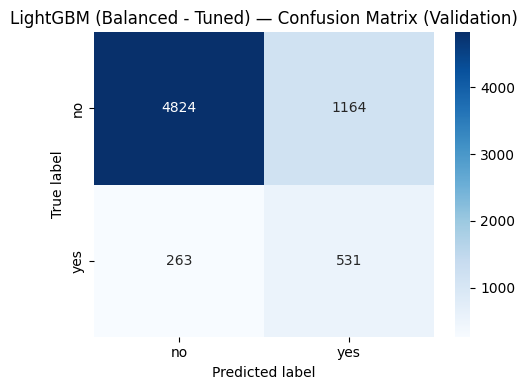

In [99]:
# LightGBM (Unweighted - Tuned) — Display Confusion Matrix (Validation)

# Retrieve cached probabilities and locked threshold
probs = globals().get("probs_val_lgbm_unweighted_tuned")
thresh = globals().get("THRESH_LGBM_UNWEIGHTED_TUNED")
y_val_bin = np.array(y_val, dtype=int)
y_pred = (probs >= thresh).astype(int)

# Plot confusion matrix
cm = confusion_matrix(y_val_bin, y_pred)
labels = ["no", "yes"]
    
# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("LightGBM (Balanced - Tuned) — Confusion Matrix (Validation)")
plt.tight_layout()
plt.show()


#### **LightGBM (Unweighted, Tuned) Final Metrics on Validation Set**
- After hyperparameter tuning and threshold locking, the final metrics for the unweighted LightGBM model are summarized here.

In [100]:
# === LightGBM (Unweighted, Tuned) — Final Metrics on Validation Set ===

acc = accuracy_score(y_val_bin, y_pred)
rec = recall_score(y_val_bin, y_pred, zero_division=0)
prec = precision_score(y_val_bin, y_pred, zero_division=0)
f1 = f1_score(y_val_bin, y_pred, zero_division=0)

print(f"Accuracy:  {acc:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"Precision: {prec:.3f}")
print(f"F1 Score:  {f1:.3f}")

Accuracy:  0.790
Recall:    0.669
Precision: 0.313
F1 Score:  0.427


#### **LightGBM ROC Curve (Unweighted, Tuned)**
- The ROC curve for the tuned LightGBM (unweighted) model on the validation set.
- The curve shows the trade-off between true positive rate (sensitivity) and false positive rate (1-specificity) at various threshold settings.
- The Area Under the Curve (AUC) is a single scalar value summarizing the model's ability to discriminate between the positive and negative classes.- A higher AUC indicates better overall performance.
- This curve helps visualize how well the model can distinguish between the two classes across all possible thresholds.- AUC is a useful metric for imbalanced datasets, as it is insensitive to class distribution.

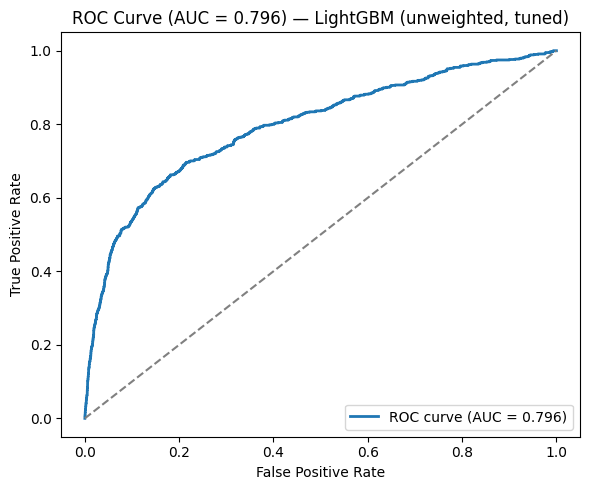

In [101]:
# === LightGBM (Unweighted, Tuned) — ROC Curve & AUC ===

# For LightGBM (unweighted, tuned)
# Use model’s validation probabilities and y_val_bin
probs = globals().get("probs_val_lgbm_unweighted_tuned")
y_true = np.array(y_val, dtype=int)

# ROC Curve & AUC
fpr, tpr, thresholds = roc_curve(y_true, probs)
auc = roc_auc_score(y_true, probs)

# Plot ROC curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})', lw=2)
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {auc:.3f}) — LightGBM (unweighted, tuned)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

#### **CatBoost (Unweighted) Hyperparameter Tuning**
- The CatBoost (unweighted) model will be further optimized through hyperparameter tuning.

In [102]:
# === CatBoost Hyperparameter Tuning (unweighted) ===

# Define hyperparameter grid for tuning (remove num_leaves, use depth)
param_grid = {
    'n_estimators': [50, 100, 200],
    'depth': [3, 5, 7, 9],           # CatBoost uses 'depth'
    'learning_rate': [0.01, 0.05, 0.1],
    # add more as desired
}

# Initialize CatBoost model
catboost = CatBoostClassifier(
    random_state=42,
    verbose=0  # set to 0 to suppress CatBoost output
)

# Setup GridSearchCV (focus on recall, 3-fold CV)
gs = GridSearchCV(
    catboost, 
    param_grid, 
    scoring='recall',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Fit on training data (X_train_ready, y_train
gs.fit(X_train_ready, y_train)

# Best params and score
print("Best params:", gs.best_params_)
print("Best recall (CV):", gs.best_score_)

# Refit best model on train, evaluate on val set
best_cat = gs.best_estimator_
probs_val = best_cat.predict_proba(X_val_ready)[:, 1]

# Rerun threshold sweep next!


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best params: {'depth': 9, 'learning_rate': 0.1, 'n_estimators': 200}
Best recall (CV): 0.24473257698541329


In [103]:
# === CatBoost (unweighted, tuned) — Fit + cache VAL probabilities ===
# MODEL_NAME = "CatBoost (unweighted, tuned)", MODEL_TAG = "catboost_unweighted_tuned"

# 1. Model identity
MODEL_NAME = "CatBoost (unweighted, tuned)"
MODEL_TAG = "catboost_unweighted_tuned"

# 2. Construct CatBoost model with best params from tuning
best_catboost = CatBoostClassifier(
    learning_rate=0.1,
    depth=9,
    n_estimators=200,
    random_state=42,
    verbose=0   # Suppress output
    # Do not set scale_pos_weight here (omit or set to 1)
)

# 3. Safety checks
assert 'X_train_ready' in globals() and 'X_val_ready' in globals(), "Preprocessing/split missing."
assert X_train_ready.shape[0] == len(y_train) and X_val_ready.shape[0] == len(y_val), "Shape mismatch."

# 4. Fit model
best_catboost.fit(X_train_ready, y_train)

# 5. Cache validation probabilities (probs_val_<MODEL_TAG>)
probs_val = best_catboost.predict_proba(X_val_ready)[:, 1]
globals()[f"probs_val_{MODEL_TAG}"] = probs_val
globals()[f"model_{MODEL_TAG}"] = best_catboost
print(f"[OK] {MODEL_NAME} fitted — cached as probs_val_{MODEL_TAG}")

[OK] CatBoost (unweighted, tuned) fitted — cached as probs_val_catboost_unweighted_tuned


#### **CatBoost (Unweighted - Tuned) Threshold Sweep + Pick + Lock**
- After hyperparameter tuning, a second threshold sweep is performed on the unweighted CatBoost model
- Pick best threshold based on recall/precision trade-off.
- Lock in this model for final evaluation.
- Document results.

In [104]:
# === CatBoost (Unweighted - Tuned) — Threshold sweep & lock ===

# Set MODEL_TAG to match A1
MODEL_TAG = "catboost_unweighted_tuned"

# Use tuned model's validation probabilities!
probs = globals()[f"probs_val_{MODEL_TAG}"]  # (not the original baseline's)
y_val_bin = np.array(y_val, dtype=int)

# Sweep thresholds from 0.10 to 0.50 in 0.01 increments
thresholds = np.round(np.arange(0.10, 0.51, 0.01), 2)
PRECISION_FLOOR = 0.30 # acceptable precision floor, very common and reasonable for recall-first,
                       # imbalanced problems, especially in business or healthcare use-cases

# Collect metrics at each threshold
rows = []
for t in thresholds:
    y_pred = (probs >= t).astype(int)
    rows.append([
        t,
        accuracy_score(y_val_bin, y_pred),
        recall_score(y_val_bin, y_pred, zero_division=0),
        precision_score(y_val_bin, y_pred, zero_division=0),
        f1_score(y_val_bin, y_pred, zero_division=0),
        float(y_pred.mean())
    ])

# Display results in a DataFrame (rounded for readability
df = pd.DataFrame(rows, columns=["threshold","accuracy","recall","precision","f1","pred_pos_rate"])
display(df)

# Lock in the best threshold based on criteria
best_f1 = df.loc[df["f1"].idxmax()]
guard = df[df["precision"] >= PRECISION_FLOOR]
recall_first = guard.loc[guard["recall"].idxmax()] if not guard.empty else None
if recall_first is not None:
    globals()[f"THRESH_{MODEL_TAG.upper()}"] = float(recall_first.threshold)
    print(f"\n[LOCKED] THRESH_{MODEL_TAG.upper()} = {float(recall_first.threshold):.2f}")
else:
    globals()[f"THRESH_{MODEL_TAG.upper()}"] = float(best_f1.threshold)
    print(f"\n[LOCKED] THRESH_{MODEL_TAG.upper()} = {float(best_f1.threshold):.2f}")


,threshold,accuracy,recall,precision,f1,pred_pos_rate
0,0.10,0.770864,0.709068,0.298515,0.420149,0.278089
1,0.11,0.792687,0.673804,0.318074,0.432149,0.248009
2,0.12,0.812740,0.648615,0.341965,0.447826,0.222058
3,0.13,0.830434,0.630982,0.368925,0.465613,0.200236
4,0.14,0.841787,0.619647,0.389549,0.478367,0.186228
5,0.15,0.851371,0.602015,0.408547,0.486762,0.172515
6,0.16,0.859334,0.581864,0.426199,0.492013,0.159835
7,0.17,0.865674,0.569270,0.442703,0.498072,0.150546
8,0.18,0.869213,0.556675,0.452405,0.499153,0.144058
9,0.19,0.872604,0.541562,0.462366,0.498840,0.137128



[LOCKED] THRESH_CATBOOST_UNWEIGHTED_TUNED = 0.11


#### **CatBoost (Unweighted, Tuned) — Display Confusion Matrix (Validation)**
- Confusion matrix for the tuned CatBoost (unweighted) on the validation set.
- Helps visualize true positives, false positives, true negatives, and false negatives.
- Useful for understanding model performance beyond just accuracy.
- Recall is a key metric here, especially for the minority class (`yes`).
- Helps identify if the model is missing too many actual `yes` cases (high FN).
- This matrix will guide threshold tuning and further model improvements.
- Document results.

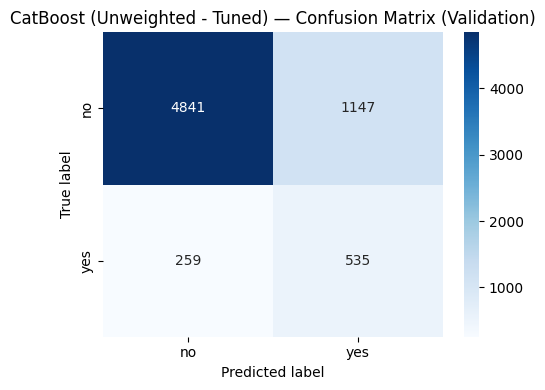

In [105]:
# === CatBoost (Unweighted, Tuned) — Display Confusion Matrix (Validation) ===

# Retrieve cached probabilities and locked threshold for CatBoost (unweighted, tuned)
probs = globals().get("probs_val_catboost_unweighted_tuned")
thresh = globals().get("THRESH_CATBOOST_UNWEIGHTED_TUNED")
y_val_bin = np.array(y_val, dtype=int)
y_pred = (probs >= thresh).astype(int)

# Plot confusion matrix
cm = confusion_matrix(y_val_bin, y_pred)
labels = ["no", "yes"]
    
# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("CatBoost (Unweighted - Tuned) — Confusion Matrix (Validation)")
plt.tight_layout()
plt.show()


#### **CatBoost (Unweighted, Tuned) Final Metrics on Validation Set**
- After hyperparameter tuning and threshold locking, the final metrics for the unweighted CatBoost model are summarized here.

In [106]:
# === CatBoost (Unweighted, Tuned) — Final Metrics on Validation Set ===

# Calculate final metrics at locked threshold
acc = accuracy_score(y_val_bin, y_pred)
rec = recall_score(y_val_bin, y_pred, zero_division=0)
prec = precision_score(y_val_bin, y_pred, zero_division=0)
f1 = f1_score(y_val_bin, y_pred, zero_division=0)

# Print final metrics
print(f"Accuracy:  {acc:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"Precision: {prec:.3f}")
print(f"F1 Score:  {f1:.3f}")

Accuracy:  0.793
Recall:    0.674
Precision: 0.318
F1 Score:  0.432


#### **CatBoost (Unweighted, Tuned) ROC Curve & AUC (Validation)**
- The ROC curve for the tuned CatBoost (unweighted) model on the validation set.
- The curve shows the trade-off between true positive rate (sensitivity) and false positive rate (1-specificity) at various threshold settings.
- The Area Under the Curve (AUC) is a single scalar value summarizing the model's ability to discriminate between the positive and negative classes.
- A higher AUC indicates better overall performance.
- This curve helps visualize how well the model can distinguish between the two classes across all possible thresholds.
- AUC is a useful metric for imbalanced datasets, as it is insensitive to class distribution.  

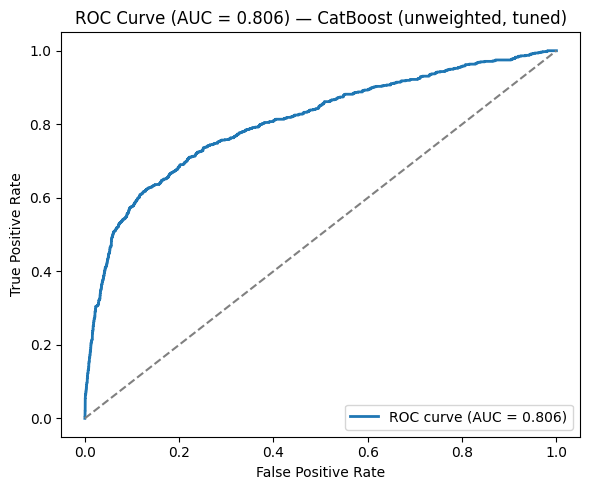

In [107]:
# === CatBoost (Unweighted, Tuned) — ROC Curve & AUC ===

# For CatBoost (unweighted, tuned)
# Use model’s validation probabilities and y_val_bin
probs = globals().get("probs_val_catboost_unweighted_tuned")
y_true = np.array(y_val, dtype=int)

# ROC Curve & AUC
fpr, tpr, thresholds = roc_curve(y_true, probs)
auc = roc_auc_score(y_true, probs)

# Plot ROC curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})', lw=2)
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {auc:.3f}) — CatBoost (unweighted, tuned)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

#### **Final Evaluation Comparison Table of Top 3 Models Before And After Hyperparameter Tuning (Validation)**
- This table compares the key metrics (recall, precision, F1, accuracy, predicted positive rate, and threshold) for each of the top 3 models before and after hyperparameter tuning on the validation set.
- It highlights the improvements achieved through tuning and helps identify the best-performing model for final evaluation.
- Document insights and next steps based on the comparison.
- Helps quickly see the impact of hyperparameter tuning on performance.

In [108]:
# === Final Comparison Table of Models Before and After Hyperparameter Tuning (Validation) ===
# *Table: Final comparison of tuned/untuned models, ranked by Recall (the priority metric).*

# === Update own variable names if needed ===
model_pairs = [
    (
        "CatBoost (Unweighted, Untuned)", "probs_val_cat_unw", "THRESH_CAT_UNW",
        "CatBoost (Unweighted, Tuned)",   "probs_val_catboost_unweighted_tuned", "THRESH_CATBOOST_UNWEIGHTED_TUNED"
    ),
    (
        "LightGBM (Unweighted, Untuned)", "probs_val_lgbm_unw", "THRESH_LGBM_UNW",
        "LightGBM (Unweighted, Tuned)",   "probs_val_lgbm_unweighted_tuned", "THRESH_LGBM_UNWEIGHTED_TUNED"
    ),
    (
        "LightGBM (Balanced, Untuned)", "probs_val_lgbm_bal", "THRESH_LGBM_BAL",
        "LightGBM (Balanced, Tuned)",   "probs_val_lgbm_bal_tuned", "THRESH_LGBM_BAL_TUNED"
    ),
    # Add more pairs as needed!
]

# Prepare comparison table
y_val_bin = np.array(y_val, dtype=int)
compare_rows = []

# Iterate over model pairs; compute metrics, handle missing data gracefully 
for untuned, untuned_probs, untuned_thresh, tuned, tuned_probs, tuned_thresh in model_pairs:
    # Untuned
    probs_untuned = globals().get(untuned_probs)
    thresh_untuned = globals().get(untuned_thresh)
    if (probs_untuned is not None) and (thresh_untuned is not None):
        y_pred_untuned = (probs_untuned >= thresh_untuned).astype(int)
        compare_rows.append({
            "Model": untuned,
            "Threshold": float(thresh_untuned),
            "Recall": recall_score(y_val_bin, y_pred_untuned, zero_division=0),
            "Precision": precision_score(y_val_bin, y_pred_untuned, zero_division=0),
            "F1": f1_score(y_val_bin, y_pred_untuned, zero_division=0),
            "Accuracy": accuracy_score(y_val_bin, y_pred_untuned),
            "Pred_Pos_Rate": float(y_pred_untuned.mean()),
        })
    else:
        print(f"Missing: {untuned} — probs or thresh not found.")

    # Tuned, if available
    probs_tuned = globals().get(tuned_probs)
    thresh_tuned = globals().get(tuned_thresh)
    if (probs_tuned is not None) and (thresh_tuned is not None):
        y_pred_tuned = (probs_tuned >= thresh_tuned).astype(int)
        compare_rows.append({
            "Model": tuned,
            "Threshold": float(thresh_tuned),
            "Recall": recall_score(y_val_bin, y_pred_tuned, zero_division=0),
            "Precision": precision_score(y_val_bin, y_pred_tuned, zero_division=0),
            "F1": f1_score(y_val_bin, y_pred_tuned, zero_division=0),
            "Accuracy": accuracy_score(y_val_bin, y_pred_tuned),
            "Pred_Pos_Rate": float(y_pred_tuned.mean()),
        })
    else:
        print(f"Missing: {tuned} — probs or thresh not found.")

# Build dataframe
df_compare = pd.DataFrame(compare_rows).set_index("Model").round(3)

# Sort by Recall descending
df_compare = df_compare.sort_values(by="Recall", ascending=False)

# Display only Top 3 models by Recall
top3 = df_compare.head(3)
display(top3)

# One-line printout of the chosen top model
best_model_name = top3.index[0]
best_threshold = top3.loc[best_model_name, "Threshold"]
print(f"Top model chosen for deployment: {best_model_name} (Threshold = {best_threshold})")


,Threshold,Recall,Precision,F1,Accuracy,Pred_Pos_Rate
Model,,,,,,
"LightGBM (Balanced, Untuned)",0.45,0.704,0.304,0.425,0.777,0.271
"LightGBM (Unweighted, Untuned)",0.11,0.679,0.318,0.433,0.792,0.250
"CatBoost (Unweighted, Untuned)",0.11,0.675,0.322,0.436,0.795,0.246


Top model chosen for deployment: LightGBM (Balanced, Untuned) (Threshold = 0.45)


In [109]:
# === Step 1: Identify Top-3 & the winner from df_compare ===
# Assumes df_compare already exists and is sorted by Recall desc

# Keep a compact Top-3 view in output
top3 = df_compare.head(3).copy()
display(top3)

# Winner name + threshold for downstream use (export + Streamlit)
best_model_name = top3.index[0]
best_threshold  = float(top3.loc[best_model_name, "Threshold"])
print(f"[Winner] {best_model_name} @ threshold {best_threshold:.2f}")


,Threshold,Recall,Precision,F1,Accuracy,Pred_Pos_Rate
Model,,,,,,
"LightGBM (Balanced, Untuned)",0.45,0.704,0.304,0.425,0.777,0.271
"LightGBM (Unweighted, Untuned)",0.11,0.679,0.318,0.433,0.792,0.250
"CatBoost (Unweighted, Untuned)",0.11,0.675,0.322,0.436,0.795,0.246


[Winner] LightGBM (Balanced, Untuned) @ threshold 0.45


In [110]:
# === Step 2: Resolve the fitted model object for the winner (no hard-coding) ===
import re

def resolve_model_from_display(display_name, model_pairs):
    """
    1) Use model_pairs to find the corresponding probs var for this display_name
    2) Derive a tag (strip 'probs_val_') and look for globals()[f'model_{tag}']
    3) Fall back to common names if needed
    """
    # 1) map display_name -> probs_var
    name_to_probs = {}
    for untuned_name, untuned_probs, _, tuned_name, tuned_probs, _ in model_pairs:
        name_to_probs[untuned_name] = untuned_probs
        name_to_probs[tuned_name]   = tuned_probs

    probs_var = name_to_probs.get(display_name)

    # 2) try model_{tag} if we can derive a tag
    candidates = []
    if probs_var:
        tag = re.sub(r"^probs_val_", "", probs_var)
        candidates.append(f"model_{tag}")

    # 3) fallbacks by family
    lname = display_name.lower()
    if "lightgbm" in lname:
        candidates += ["best_lgbm", "best_lgbm_unweighted", "model_lgbm", "best_lgbm_unw"]
    if "catboost" in lname or "catboost" in lname:
        candidates += ["best_catboost", "model_catboost", "model_cb_unw_tuned", "model_cat_unw"]
    if "random forest" in lname or "rf" in lname:
        candidates += ["best_rf", "model_rf_unw", "rf_model"]
    if "xgboost" in lname or "xgb" in lname:
        candidates += ["best_xgb", "model_xgb_unw", "xgb_model"]

    # return the first match that exists
    for var in candidates:
        obj = globals().get(var)
        if obj is not None:
            return var, obj

    # last-resort scan: pick an estimator-like object matching the family
    for var, obj in globals().items():
        try:
            is_estimator = hasattr(obj, "predict_proba") or hasattr(obj, "predict")
        except Exception:
            is_estimator = False
        if not is_estimator:
            continue
        vlow = var.lower()
        if "lightgbm" in lname and ("lgb" in vlow or "lightgbm" in vlow):
            return var, obj
        if "catboost" in lname and ("cat" in vlow or "cb" in vlow):
            return var, obj

    raise RuntimeError(f"Could not resolve a fitted model object for: {display_name}")

# Use it for the winner
model_var_name, model_obj = resolve_model_from_display(best_model_name, model_pairs)
print(f"[Resolved] Using model object from: {model_var_name}")


[Resolved] Using model object from: model_lgbm_bal


In [111]:
# === Step 2.5: Rebuild TRAIN handles if they aren't in memory ===

# This is needed for final evaluation on the TEST set in Step 3
def ensure_train_handles():
    """
    Ensures X_train_raw, y_train, and train_idx exist.
    Uses your standard 70/15/15 stratified split and excludes 'duration' from features.
    """
    # Fast exit if everything already exists
    if all(k in globals() for k in ["X_train_raw", "y_train", "train_idx"]):
        print("[OK] TRAIN handles already present: X_train_raw, y_train, train_idx")
        return

    # Need the full dataset in a DataFrame named `dataset`
    assert "dataset" in globals(), (
        "I need your full DataFrame named `dataset`. "
        "If it's not loaded, do something like: "
        "dataset = pd.read_csv('bank.csv')"
    )
    df = dataset.copy()

    # Build binary y (1 for 'yes', 0 for 'no'); robust to already-binary y
    y_all = df["y"]
    if y_all.dtype.kind in {"i","u","b"}:
        y_all = y_all.astype(int)
    else:
        y_all = (y_all.astype(str).str.lower().str.strip() == "yes").astype(int)

    # Drop target + duration from features to avoid leakage
    X_all = df.drop(columns=["y","duration"], errors="ignore")

    # 70/15/15 split (TRAIN / VAL / TEST), stratified
    X_train_raw_, X_temp, y_train_, y_temp = train_test_split(
        X_all, y_all, test_size=0.30, stratify=y_all, random_state=42
    )
    X_val_raw_, X_test_raw_, y_val_, y_test_ = train_test_split(
        X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
    )

    # Build a boolean mask for TRAIN rows on the original dataset index
    mask = df.index.isin(X_train_raw_.index)

    # Publish to globals so Step 3 can pick them up
    globals()["X_train_raw"] = X_train_raw_
    globals()["y_train"] = y_train_
    globals()["train_idx"] = mask

    # Optional: also set/refresh these if you want them around
    globals()["X_val_raw"] = X_val_raw_
    globals()["y_val"] = y_val_
    globals()["X_test_raw"] = X_test_raw_
    globals()["y_test"] = y_test_

    print(
        f"[OK] TRAIN/VAL/TEST rebuilt | "
        f"TRAIN: {X_train_raw_.shape} | VAL: {X_val_raw_.shape} | TEST: {X_test_raw_.shape} "
        f"| Pos rate (VAL): {y_val_.mean():.3f}"
    )

# Ensure TRAIN handles are present
ensure_train_handles()


[OK] TRAIN/VAL/TEST rebuilt | TRAIN: (31647, 15) | VAL: (6782, 15) | TEST: (6782, 15) | Pos rate (VAL): 0.117


In [ ]:
# === Step 3: Export final Pipeline(preprocessor -> clf) for Streamlit ===

# Columns (duration excluded to avoid leakage)
cat_cols = ["job","marital","education","default","housing","loan","contact","month","poutcome"]
num_cols = ["age","balance","day","campaign","pdays","previous"]

preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
])

final_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", model_obj),  # <- the resolved fitted model
])

# Fit on TRAIN data (robust to the notebook’s variable style)
if 'X_train_raw' in globals() and 'y_train' in globals():
    X_train = X_train_raw.drop(columns=['duration'], errors='ignore') # type: ignore
    final_pipeline.fit(X_train, y_train)
elif 'dataset' in globals() and 'train_idx' in globals():
    X_train = dataset.loc[train_idx].drop(columns=['y','duration'], errors='ignore') # type: ignore
    y_train = (dataset.loc[train_idx,'y'].astype(str).str.lower()=="yes").astype(int) # type: ignore
    final_pipeline.fit(X_train, y_train)
else:
    raise RuntimeError("Need X_train_raw/y_train or dataset+train_idx to fit the final pipeline.")

# Save assets
joblib.dump(final_pipeline, "bankterm_pipeline.pkl")
with open("feature_schema.json","w") as f:
    json.dump({"categorical": cat_cols, "numeric": num_cols, "target":"y"}, f, indent=2)

print(f"[Saved] bankterm_pipeline.pkl (from {best_model_name} via {model_var_name})")
print(f"[Action] In the Streamlit app, set LOCKED_THRESHOLD = {best_threshold:.2f}")


[Saved] bankterm_pipeline.pkl (from LightGBM (Balanced, Untuned) via model_lgbm_bal)
[Action] In the Streamlit app, set LOCKED_THRESHOLD = 0.45


## **To view the BankTermPredict Streamlit App** 
- Please visit: https://bankterm-app.streamlit.app

---

© 2025 Jackie CW Vescio  
If this notebook or its contents are referenced, please cite: *Vescio, Jackie C.W. (2025). BankTermPredict Jupyter Notebook. Thank you*  